<a href="https://colab.research.google.com/github/naphatsiri/M.Sc-IS-Fault-Detection/blob/main/IS_fault_detection_3models_4cri_231268_utd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1.Data preparation

In [ ]:
#Import working libraries.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
!wget https://github.com/naphatsiri/M.Sc-IS-Fault-Detection/raw/main/Refrigerant-leak_data/normal%20r.xls
!wget https://github.com/naphatsiri/M.Sc-IS-Fault-Detection/raw/main/Refrigerant-leak_data/rl10.xls
!wget https://github.com/naphatsiri/M.Sc-IS-Fault-Detection/raw/main/Refrigerant-leak_data/rl20.xls
!wget https://github.com/naphatsiri/M.Sc-IS-Fault-Detection/raw/main/Refrigerant-leak_data/rl30.xls
!wget https://github.com/naphatsiri/M.Sc-IS-Fault-Detection/raw/main/Refrigerant-leak_data/rl40.xls

--2025-12-23 06:19:51--  https://github.com/naphatsiri/M.Sc-IS-Fault-Detection/raw/main/Refrigerant-leak_data/normal%20r.xls
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/naphatsiri/M.Sc-IS-Fault-Detection/main/Refrigerant-leak_data/normal%20r.xls [following]
--2025-12-23 06:19:51--  https://raw.githubusercontent.com/naphatsiri/M.Sc-IS-Fault-Detection/main/Refrigerant-leak_data/normal%20r.xls
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3102208 (3.0M) [application/octet-stream]
Saving to: ‘normal r.xls’

normal r.xls        100%[===================>]   2.96M  --.-KB/s    in 0.04s   

2025-1

In [ ]:
#Use rl10%, rl20%, rl30%, rl40% and rl_normal dataset

df_normal = pd.read_excel("/content/normal r.xls", sheet_name="Reduced Data Set", engine='xlrd')
df_fault10 = pd.read_excel("/content/rl10.xls", sheet_name="Reduced Data Set", engine='xlrd')
df_fault20 = pd.read_excel("/content/rl20.xls", sheet_name="Reduced Data Set", engine='xlrd')
df_fault30 = pd.read_excel("/content/rl30.xls", sheet_name="Reduced Data Set", engine='xlrd')
df_fault40 = pd.read_excel("/content/rl40.xls", sheet_name="Reduced Data Set", engine='xlrd')

In [ ]:
df_normal.info()
df_fault10.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 433 entries, 0 to 432
Data columns (total 66 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Time (minutes)       433 non-null    float64
 1   TWE_set              433 non-null    int64  
 2   TEI                  433 non-null    float64
 3   TWEI                 433 non-null    float64
 4   TEO                  433 non-null    float64
 5   TWEO                 433 non-null    float64
 6   TCI                  433 non-null    float64
 7   TWCI                 433 non-null    float64
 8   TCO                  433 non-null    float64
 9   TWCO                 433 non-null    float64
 10  TSI                  433 non-null    float64
 11  TSO                  433 non-null    float64
 12  TBI                  433 non-null    float64
 13  TBO                  433 non-null    float64
 14  Cond Tons            433 non-null    float64
 15  Cooling Tons         433 non-null    flo

# 2.Refrigerant leakage detection : Normal condition vs 4 conditions of percent less than nominal

## 2.1 Normal vs 10% less than nominal

In [ ]:
'''Define dataset with normal operation label as 0, dataset with 10% less than nominal as 1
and then concatenate to dataframe "df10" '''

df_normal["label"] = 0
df_fault10["label"] = 1

df10 = pd.concat([df_normal, df_fault10], ignore_index=True)

In [ ]:
''' explore df10 shape as they consist of 866 rows and 67 features '''

df10.shape

(866, 67)

In [ ]:
#Clean and filter the data : removen oise, non-operational periods, and impossible values.

''' 1) Keep only rows where the unit is operating, coolting tons must >= 0
and the must be in the operating condition as Kilowatt >=0'''
''' 2) To avoid removing valid operating conditions, only physically impossible values were filtered.
Cooling capacity and power consumption were constrained to be non-negative,
while zero values were retained to preserve low-load and transient operating states that are common in real chiller systems. '''

'''df = df[df["Unit Status"] == 1]'''

# Only remove *obviously invalid* rows
df10 = df10[(df10["Cooling Tons"] >= 0) & (df10["kW"] >= 0)]

# Clip outliers (not drop)
for col in ["PRE", "PRC", "kW", "Cooling Tons", "COP", "Amps"]:
    lower, upper = df10[col].quantile([0.001, 0.999])
    df10[col] = df10[col].clip(lower, upper)

print("Cleaned data shape:", df10.shape)



Cleaned data shape: (866, 67)


In [ ]:
df10.head()

,Time (minutes),TWE_set,TEI,TWEI,TEO,TWEO,TCI,TWCI,TCO,TWCO,...,VE,VW,TWI,TWO,THI,THO,FWW,FWH,FWB,label
0,0.0612,50,65.59,65.6,66.40,66.4,67.44,67.3,68.50,68.4,...,56,0.0,66.21,71.01,67.54,70.72,2.202000e-47,5.491000e-46,3.853000e-45,0
1,2.0600,50,67.23,67.6,67.26,67.3,67.56,67.3,67.76,67.3,...,56,30.0,63.67,66.35,67.83,67.73,1.527000e+01,5.041000e+01,2.698000e+02,0
2,4.0600,50,67.64,67.8,67.59,67.5,67.31,67.0,67.47,67.3,...,56,30.0,62.03,65.49,67.91,67.81,2.146000e+01,2.438000e+01,2.693000e+02,0
3,6.0600,50,67.44,67.3,67.42,67.3,66.86,66.5,67.07,66.7,...,56,30.0,59.74,63.89,67.70,67.60,2.589000e+01,2.442000e+01,2.603000e+02,0
4,8.0600,49,66.66,66.2,64.92,63.7,67.76,68.4,69.89,71.4,...,56,20.0,59.17,64.75,66.80,66.79,5.489000e+01,2.461000e+01,-8.491000e+01,0


In [ ]:
# Select the relevant columns for ML

# Core measured features for refrigerant leak detection
''' Choose features that relevant for this study consisting as 7 groups as follow '''

selected_features = [
    "TEI", "TEO", "TWI", "TWO",           # Thermal temperatures
    "TCI", "TCO", "TWCI", "TWCO",         # Condenser temps
    "PRE", "PRC", "P_lift",               # Pressure features
    "kW", "COP", "Cooling Tons",          # Performance indicators
    "Amps", "RLA%",                       # Electrical features
    "Tsh_suc", "Tsh_dis",                 # Superheat
    "kW/Ton"                              # Efficiency
]

''' Add the seclected features to df10 for future operation'''

df10 = df10[["Time (minutes)"] + selected_features + ["label"]]
print("Final feature set:", df10.shape)


Final feature set: (866, 21)


In [ ]:
df10.head()

,Time (minutes),TEI,TEO,TWI,TWO,TCI,TCO,TWCI,TWCO,PRE,...,P_lift,kW,COP,Cooling Tons,Amps,RLA%,Tsh_suc,Tsh_dis,kW/Ton,label
0,0.0612,65.59,66.40,66.21,71.01,67.44,68.50,67.3,68.4,66.1,...,0.0,1.682000e-45,3.649000e-46,2.722816e-47,0,0,16.1,6.4,1.682000e-45,0
1,2.0600,67.23,67.26,63.67,66.35,67.56,67.76,67.3,67.3,67.5,...,0.0,1.682000e-45,8.203000e-01,1.701000e+00,0,0,16.4,5.7,1.682000e-45,0
2,4.0600,67.64,67.59,62.03,65.49,67.31,67.47,67.0,67.3,67.0,...,0.0,1.682000e-45,1.764000e+00,3.087000e+00,0,0,15.3,6.0,1.682000e-45,0
3,6.0600,67.44,67.42,59.74,63.89,66.86,67.07,66.5,66.7,66.7,...,0.0,1.682000e-45,4.665000e-01,4.474000e+00,0,0,13.3,7.3,1.682000e-45,0
4,8.0600,66.66,64.92,59.17,64.75,67.76,69.89,68.4,71.4,55.7,...,18.7,3.601000e+01,1.539000e+00,1.276000e+01,43,41,7.1,33.6,2.284000e+00,0


In [ ]:
#To confirm that there is no missing value.

print(df10.isna().sum())

Time (minutes)    0
TEI               0
TEO               0
TWI               0
TWO               0
TCI               0
TCO               0
TWCI              0
TWCO              0
PRE               0
PRC               0
P_lift            0
kW                0
COP               0
Cooling Tons      0
Amps              0
RLA%              0
Tsh_suc           0
Tsh_dis           0
kW/Ton            0
label             0
dtype: int64


### 2.1.1 Features engineering operation

In [ ]:
# Derived temperature features

# Evaporator and condenser approach temperatures

#df10["Evap_Approach"] = df10["TEO"] - df10["TEI"]        # Evaporator approach (ΔT across evaporator)
#df10["Cond_Approach"] = df10["TCO"] - df10["TCI"]        # Condenser approach (ΔT across condenser)
df10["Delta_Evap"] = df10["TEO"] - df10["TEI"]        #Use this instead
df10["Delta_Cond"] = df10["TCO"] - df10["TCI"]        #Use this instead

''' 1) Although evaporator approach temperature is traditionally defined as the difference between chilled-water leaving temperature and refrigerant evaporating temperature,
the RP-1043 dataset does not directly provide refrigerant saturation temperature.
Therefore, this study employs the water-side temperature difference across the evaporator as a proxy feature to characterize heat-transfer performance.
    2) In classical HVAC analysis, evaporator approach temperature is defined as the difference between chilled-water leaving temperature and refrigerant evaporating temperature.
   However, as the RP-1043 dataset does not provide direct measurements of refrigerant saturation temperature,
   this study uses the water-side temperature difference across the evaporator as a surrogate feature to represent evaporator heat-transfer performance. '''

# Temperature lift: overall temperature difference between condenser and evaporator
df10["Temp_Lift"] = df10["TCO"] - df10["TEO"]
''' 1) Temperature Lift is the overall temperature difference between condenser outlet water and evaporator outlet water
    2) Higher temperature lift → higher compressor workload '''

# Pressure-based features
df10["Pressure_Ratio"] = df10["PRC"] / df10["PRE"].replace(0, np.nan)  # Prevent divide-by-zero
''' 1) The Pressure Ratio reflects compression workload and refrigerant cycle efficiency
    2) Refrigerant leakage causes evaporator pressure (PRE) to drop and condenser pressure (PRC) to change more slowly '''

# Efficiency-based features
df10["kW_per_Ton"] = df10["kW"] / df10["Cooling Tons"].replace(0, np.nan)
''' 1) kW/Ton measures how much electrical power is required per unit of cooling output
    2) Under refrigerant leak cooling capacity decreases, compressor still consumes power and kW/Ton increases sharply '''

# Superheat difference
df10["Delta_Superheat"] = df10["Tsh_suc"] - df10["Tsh_dis"]
''' 1) Superheat difference reflects refrigerant state change between suction and discharge and stability of refrigerant flow
    2) Superheat difference reflects refrigerant state change between suction and discharge and stability of refrigerant flow'''


' 1) Superheat difference reflects refrigerant state change between suction and discharge and stability of refrigerant flow\n    2) Superheat difference reflects refrigerant state change between suction and discharge and stability of refrigerant flow'

In [ ]:
df10.head()

,Time (minutes),TEI,TEO,TWI,TWO,TCI,TCO,TWCI,TWCO,PRE,...,kW/Ton,label,Evap_Approach,Cond_Approach,Temp_Lift,Pressure_Ratio,kW_per_Ton,Delta_Superheat,Delta_Evap,Delta_Cond
0,0.0612,65.59,66.40,66.21,71.01,67.44,68.50,67.3,68.4,66.1,...,1.682000e-45,0,0.81,1.06,2.10,0.998487,6.177428e+01,9.7,0.81,1.06
1,2.0600,67.23,67.26,63.67,66.35,67.56,67.76,67.3,67.3,67.5,...,1.682000e-45,0,0.03,0.20,0.50,1.000000,9.888301e-46,10.7,0.03,0.20
2,4.0600,67.64,67.59,62.03,65.49,67.31,67.47,67.0,67.3,67.0,...,1.682000e-45,0,-0.05,0.16,-0.12,1.000000,5.448656e-46,9.3,-0.05,0.16
3,6.0600,67.44,67.42,59.74,63.89,66.86,67.07,66.5,66.7,66.7,...,1.682000e-45,0,-0.02,0.21,-0.35,0.989505,3.759499e-46,6.0,-0.02,0.21
4,8.0600,66.66,64.92,59.17,64.75,67.76,69.89,68.4,71.4,55.7,...,2.284000e+00,0,-1.74,2.13,4.97,1.346499,2.822100e+00,-26.5,-1.74,2.13


In [ ]:
# Create Rolling (Time-Series) Features
''' 1) Rolling time-series features were generated to capture the temporal behavior of chiller operation,
as refrigerant leakage and performance degradation develop gradually rather than instantaneously
    2) My hypothesis is we should have these parameters as they 've said that
    "refrigerant leakage and performance degradation develop gradually rather than instantaneously" '''

# Define columns to create rolling stats for
'''Although temperature measurements are fundamental indicators of chiller operation,
this study emphasizes performance- and pressure-based features such as COP, kW, Cooling Tons, PRE, and PRC.
These variables integrate temperature effects with system load and refrigerant-side thermodynamics,'''

rolling_cols = ["COP", "kW", "Cooling Tons", "PRE", "PRC"]

# Create rolling mean and standard deviation (window ~6 samples ≈ 1 min)
for col in rolling_cols:
    df10[f"{col}_mean"] = df10[col].rolling(window=6, min_periods=1).mean()
    df10[f"{col}_std"] = df10[col].rolling(window=6, min_periods=1).std()


In [ ]:
df10.head()

,Time (minutes),TEI,TEO,TWI,TWO,TCI,TCO,TWCI,TWCO,PRE,...,COP_mean,COP_std,kW_mean,kW_std,Cooling Tons_mean,Cooling Tons_std,PRE_mean,PRE_std,PRC_mean,PRC_std
0,0.0612,65.59,66.40,66.21,71.01,67.44,68.50,67.3,68.4,66.1,...,3.649000e-46,NaN,1.682000e-45,NaN,2.722816e-47,NaN,66.100000,NaN,66.000000,NaN
1,2.0600,67.23,67.26,63.67,66.35,67.56,67.76,67.3,67.3,67.5,...,4.101500e-01,0.580040,1.682000e-45,0.000000,8.505000e-01,1.202789,66.800000,0.989949,66.750000,1.060660
2,4.0600,67.64,67.59,62.03,65.49,67.31,67.47,67.0,67.3,67.0,...,8.614333e-01,0.882719,1.682000e-45,0.000000,1.596000e+00,1.546176,66.866667,0.709460,66.833333,0.763763
3,6.0600,67.44,67.42,59.74,63.89,66.86,67.07,66.5,66.7,66.7,...,7.627000e-01,0.747299,1.682000e-45,0.000000,2.315500e+00,1.914287,66.825000,0.585235,66.625000,0.750000
4,8.0600,66.66,64.92,59.17,64.75,67.76,69.89,68.4,71.4,55.7,...,9.179600e-01,0.734418,7.202000e+00,16.104162,4.404400e+00,4.956399,64.600000,5.001000,68.300000,3.801316


In [ ]:
df10.shape

(866, 39)

In [ ]:
# Final features of operational data.
''' Check for final features to operate the study consisting of Raw sensor features,
Derive features and rolling features '''
feature_cols = [
    # Raw sensor features
    "TEI", "TEO", "TWI", "TWO", "TCI", "TCO",
    "PRE", "PRC", "P_lift", "kW", "COP", "Cooling Tons",
    "Amps", "RLA%", "Tsh_suc", "Tsh_dis", "kW/Ton",

    # Derived features
    "Evap_Approach", "Cond_Approach", "Temp_Lift",
    "Pressure_Ratio", "kW_per_Ton", "Delta_Superheat",

    # Rolling features
    "COP_mean", "COP_std", "kW_mean", "kW_std",
    "PRE_mean", "PRE_std", "PRC_mean", "PRC_std"
]

# Fill missing values safely before dropping
df10[feature_cols] = df10[feature_cols].replace([np.inf, -np.inf], np.nan)
''' Identifies these problematic infinite values within your selected sensor features and replaces them with np.nan (Not a Number),
effectively marking them as missing or invalid data points. '''

df10[feature_cols] = df10[feature_cols].fillna(df10[feature_cols].median())
''' Imputes (fills in) these missing (np.nan) values using the median of their respective columns.
The median is chosen because it's robust to outliers, meaning extreme values in the rest of the column won't unduly influence the imputed value. '''

# Drop any NaN rows created by rolling calculations
df10 = df10.dropna(subset=feature_cols)
'''This final step removes any remaining rows that still contain missing (np.nan) values in the feature_cols.
This ensures that the dataset used for training is completely clean and consistent,
which is vital for building reliable fault detection models in engineering systems. '''

print("Final feature matrix shape:", df10[feature_cols].shape)


Final feature matrix shape: (866, 31)


In [ ]:
df10.head()

,Time (minutes),TEI,TEO,TWI,TWO,TCI,TCO,TWCI,TWCO,PRE,...,COP_mean,COP_std,kW_mean,kW_std,Cooling Tons_mean,Cooling Tons_std,PRE_mean,PRE_std,PRC_mean,PRC_std
0,0.0612,65.59,66.40,66.21,71.01,67.44,68.50,67.3,68.4,66.1,...,3.649000e-46,0.102191,1.682000e-45,1.997395,2.722816e-47,NaN,66.100000,0.348807,66.000000,1.356466
1,2.0600,67.23,67.26,63.67,66.35,67.56,67.76,67.3,67.3,67.5,...,4.101500e-01,0.580040,1.682000e-45,0.000000,8.505000e-01,1.202789,66.800000,0.989949,66.750000,1.060660
2,4.0600,67.64,67.59,62.03,65.49,67.31,67.47,67.0,67.3,67.0,...,8.614333e-01,0.882719,1.682000e-45,0.000000,1.596000e+00,1.546176,66.866667,0.709460,66.833333,0.763763
3,6.0600,67.44,67.42,59.74,63.89,66.86,67.07,66.5,66.7,66.7,...,7.627000e-01,0.747299,1.682000e-45,0.000000,2.315500e+00,1.914287,66.825000,0.585235,66.625000,0.750000
4,8.0600,66.66,64.92,59.17,64.75,67.76,69.89,68.4,71.4,55.7,...,9.179600e-01,0.734418,7.202000e+00,16.104162,4.404400e+00,4.956399,64.600000,5.001000,68.300000,3.801316


In [ ]:
print("Label distribution:")
print(df10["label"].value_counts())


Label distribution:
label
0    433
1    433
Name: count, dtype: int64


### 2.1.2 ML model operation

In [ ]:
#Install optuna (for hyperparameter tuning)

!pip install optuna xgboost lightgbm catboost

''' Install optuna for hyperparameter optimization and models for this study ;
xgboost, lightgbm and catboost '''

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.8 MB/s eta 0:00:00


' Install optuna for hyperparameter optimization and models for this study ;\nxgboost, lightgbm and catboost '

In [ ]:
#Import working libraries.
#Including optuna for hyperparameter tuning

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import  f1_score, recall_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight
import optuna

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

''' Import model selection;
StratifiedKFold
1) StratifiedKFold is introduced in case that we are dealing with imbalanced datasets,
where some classes are much rarer than others.
2) In real world, nornal opreation data happens to be more than fault operation data so in this case,
StratifiedKFold is introduced to ensure that each fold contains enough fault samples. Make recall and F1 are stable and reliable
3) Ensures fair and consistent model comparison across different learning algorithms
StandardScaler
1) StandardScaler was applied to normalize all input features to zero mean and unit variance.
Although tree-based models are generally insensitive to feature scaling,
normalization was employed to ensure fair contribution of heterogeneous sensor variables,
improve stability during hyperparameter optimization, and enhance the reliability of feature-importance analysis.
2) If we don't use StandardScaler, large-magnitude features dominate and smaller but important signals get ignored '''

" Import model selection;\nStratifiedKFold\n1) StratifiedKFold is introduced in case that we are dealing with imbalanced datasets,\nwhere some classes are much rarer than others.\n2) In real world, nornal opreation data happens to be more than fault operation data so in this case,\nStratifiedKFold is introduced to ensure that each fold contains enough fault samples. Make recall and F1 are stable and reliable\n3) Ensures fair and consistent model comparison across different learning algorithms\nStandardScaler\n1) StandardScaler was applied to normalize all input features to zero mean and unit variance.\nAlthough tree-based models are generally insensitive to feature scaling,\nnormalization was employed to ensure fair contribution of heterogeneous sensor variables,\nimprove stability during hyperparameter optimization, and enhance the reliability of feature-importance analysis.\n2) If we don't use StandardScaler, large-magnitude features dominate and smaller but important signals get ign

In [ ]:
# Separate features and label
X_df10 = df10.drop(columns=["Time (minutes)", "label"])
y10 = df10["label"]

# Standardize features
scaler = StandardScaler()
X_scaled_array10 = scaler.fit_transform(X_df10)

# Convert scaled array back to DataFrame with original column names
X_scaled_df10 = pd.DataFrame(X_scaled_array10, columns=X_df10.columns)

In [ ]:
# Train-Test-Split

X_tr10, X_te10, y_tr10, y_te10 = train_test_split(
    X_scaled_df10, y10, test_size=0.2, stratify=y10, random_state=42
)
'''
1) X_tr10, X_te10, y_tr10, y_te10
X_tr10: This will store the features (input data) that the model will be trained on.
X_te10: This will store the features (input data) that the model will be tested on (unseen data).
y_tr10: This will store the corresponding labels (target output) for the training features.
y_te10: This will store the corresponding labels (target output) for the testing features.

2) Train_test_split
   2.1) X_scaled_df10: This is your input feature DataFrame after it has been scaled (standardized).
   2.2) y10: This is your target variable (labels) for the dataset.
   2.3) test_size=0.2: This parameter specifies that 20% of the data should be allocated to the testing set, and the remaining 80% will be used for training.
   2.4) stratify=y10: This is a very important parameter, especially with classification tasks. It ensures that the proportion of classes (in y10) is the same in both the training and testing sets.
   For example, if 30% of your data belongs to class '1', then both y_tr10 and y_te10 will also have approximately 30% of class '1' samples.
   This prevents skewed distributions and makes the evaluation more reliable.
   2.5) random_state=42: This parameter sets the seed for the random number generator.
   Using a fixed random_state (like 42) ensures that you get the exact same split every time you run the code, making your results reproducible.'''

print("Train size:", X_tr10.shape)
print("Test size:", X_te10.shape)

Train size: (692, 37)
Test size: (174, 37)


In [ ]:
#Data split and shared setting

# Cross-validation (CV) setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

''' cv = StratifiedKFold(...):
1) Splitting a dataset into training and validation sets multiple times (folds) while ensuring that each fold maintains the same proportion of target classes as the full dataset.
This is particularly important for classification tasks with imbalanced classes, as it prevents any single fold from being dominated by one class.
2) n_splits=5: This means the dataset will be split into 5 folds. The model will be trained and evaluated 5 times, with each fold serving as the validation set exactly once.
3) shuffle=True: This shuffles the data before splitting into folds, which helps to ensure that samples are distributed randomly across folds, reducing potential biases. '''

# Class imbalance handling (useful even if near-balanced)
classes = np.unique(y_tr10)
cw = compute_class_weight(class_weight='balanced', classes=classes, y=y_tr10)
class_weight_dict = {c:w for c,w in zip(classes, cw)}

''' Class weights, which are used to give more importance to minority classes during model training. This helps prevent the model from becoming biased towards the majority class.
1) classes = np.unique(y_tr10): This identifies all unique class labels present in your training target variable y_tr10 (e.g., 0 for normal, 1 for fault).
2) cw = compute_class_weight(class_weight='balanced', classes=classes, y=y_tr10): This function automatically calculates weights such that the total weight of each class in the training data is balanced.
If one class has fewer samples, its individual samples will receive a higher weight. The 'balanced' option automatically adjusts weights inversely proportional to class frequencies in the input data.
3) class_weight_dict = {c:w for c,w in zip(classes, cw)}: This creates a dictionary mapping each class label to its calculated weight.
This dictionary can then be passed to the class_weight parameter of some machine learning models (like CatBoostClassifier). '''

# Helper to compute scale_pos_weight for XGB if needed
neg_count = (y_tr10==0).sum()
pos_count = (y_tr10==1).sum()
scale_pos_weight = neg_count / max(pos_count, 1)

''' Calculates a specific weighting factor, scale_pos_weight, which is commonly used in tree-based models like XGBoost to handle class imbalance.
1) neg_count = (y_tr10==0).sum(): Counts the number of samples belonging to the negative class (label 0) in your training data.
2) pos_count = (y_tr10==1).sum(): Counts the number of samples belonging to the positive class (label 1) in your training data.
3) scale_pos_weight = neg_count / max(pos_count, 1): This calculates the ratio of negative samples to positive samples. If there are fewer positive samples, this ratio will be greater than 1,
instructing XGBoost to give more weight to the positive class. max(pos_count, 1) is used to prevent division by zero in case pos_count is 0

additional information
Why we use "scale_pos_weight" : To mitigate class imbalance and prioritize fault detection, a class weighting strategy was applied using the scale_pos_weight parameter in XGBoost.
This parameter adjusts the loss function by assigning higher importance to fault samples relative to normal samples,
thereby reducing false negatives and improving recall. Such weighting aligns the model optimization objective with real-world chiller operation,
where fault events are rare but critical as this stody focuses on refrigerant leak detection, which has these properties:
1) Faults are rare compared to normal operation
2) Missing a fault (False Negative) is much more costly than a false alarm.
'''

' Calculates a specific weighting factor, scale_pos_weight, which is commonly used in tree-based models like XGBoost to handle class imbalance.\n1) neg_count = (y_tr10==0).sum(): Counts the number of samples belonging to the negative class (label 0) in your training data.\n2) pos_count = (y_tr10==1).sum(): Counts the number of samples belonging to the positive class (label 1) in your training data.\n3) scale_pos_weight = neg_count / max(pos_count, 1): This calculates the ratio of negative samples to positive samples. If there are fewer positive samples, this ratio will be greater than 1,\ninstructing XGBoost to give more weight to the positive class. max(pos_count, 1) is used to prevent division by zero in case pos_count is 0\n\nadditional information\nWhy we use "scale_pos_weight" : To mitigate class imbalance and prioritize fault detection, a class weighting strategy was applied using the scale_pos_weight parameter in XGBoost.\nThis parameter adjusts the loss function by assigning hi

In [ ]:
#Shared cross-validation evaluation helper

def cv_score_estimator10(estimator, X, y, cv, early_stopping=True, model_name="model"):
    f1_scores, rec_scores, auc_scores = [], [], []
    for fold, (tr_idx, va_idx) in enumerate(cv.split(X, y), 1):
        X_tr_f, X_va_f = X.iloc[tr_idx], X.iloc[va_idx]
        y_tr_f, y_va_f = y.iloc[tr_idx], y.iloc[va_idx]

        ''' 1) These lists store performance results for each fold of cross-validation.
            2) This performs K-fold cross-validation (e.g., 5-fold):
                  2.1) Data is split into training and validation sets multiple times
                  2.2) Each sample is used for validation exactly once
            3) Each fold uses:
                  3.1) A different training subset
                  3.2) A different validation subset
                  This simulates model performance on unseen operating conditions'''

        fit_params = {}
        if hasattr(estimator, "fit") and early_stopping: #This ensure the estimator supports training and the estimator supports training
            if model_name == "xgb":
                # The model will run for the full number of n_estimators specified
                fit_params.update(dict(
                    eval_set=[(X_va_f, y_va_f)],
                    verbose=False
                ))
            elif model_name == "lgbm":
                fit_params.update(dict(
                    eval_set=[(X_va_f, y_va_f)],
                    # eval_metric should be in constructor or callbacks, not fit params for LGBM
                    # verbose is not a direct fit param for LGBM; controlled by silent in constructor or callbacks
                    callbacks=[]
                ))
            elif model_name == "cat":
                fit_params.update(dict(
                    eval_set=[(X_va_f, y_va_f)],
                    verbose=False,
                    use_best_model=True
                ))

        estimator.fit(X_tr_f, y_tr_f, **fit_params)
        y_pred = estimator.predict(X_va_f)                          #produce class label : used for F1 and Recall
        y_prob = (estimator.predict_proba(X_va_f)[:,1]
                  if hasattr(estimator, "predict_proba") else None) #produce class probabilities : used for ROC-AUC

        f1_scores.append(f1_score(y_va_f, y_pred, pos_label=1))
        rec_scores.append(recall_score(y_va_f, y_pred, pos_label=1))
        if y_prob is not None:
            auc_scores.append(roc_auc_score(y_va_f, y_prob))

    return np.mean(f1_scores), np.mean(rec_scores), (np.mean(auc_scores) if auc_scores else None)

    ''' A unified cross-validation evaluation function was implemented to ensure consistent and fair performance assessment across all machine-learning models.
    The function applies stratified K-fold cross-validation and computes averaged F1-score, recall, and ROC-AUC metrics.
    Model-specific training configurations were incorporated to account for differences in training interfaces while maintaining identical evaluation conditions.
    This approach ensures that reported performance reflects robust generalization capability rather than a single train–test split. '''

In [ ]:
#Optuna objective : XGBoost objective

def objective_xgb10(trial):
    params = dict(
        n_estimators=trial.suggest_int("n_estimators", 200, 800),
        learning_rate=trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        max_depth=trial.suggest_int("max_depth", 3, 8),
        subsample=trial.suggest_float("subsample", 0.6, 1.0),
        colsample_bytree=trial.suggest_float("colsample_bytree", 0.6, 1.0),
        min_child_weight=trial.suggest_float("min_child_weight", 1.0, 10.0),
        reg_lambda=trial.suggest_float("reg_lambda", 0.0, 5.0),
        reg_alpha=trial.suggest_float("reg_alpha", 0.0, 2.0),
        random_state=42,
        tree_method="hist",
        eval_metric="logloss",
        # If imbalance: uncomment
        # scale_pos_weight=scale_pos_weight
    )

    ''' 1) For each trial, Optuna picks values for key XGBoost knobs like n_estimators, learning_rate, max_depth, subsample, etc.
    This is how Optuna searches for a strong configuration instead of you guessing manually.
        2) n_estimators, learning_rate, max_depth, min_child_weight → model capacity / how complex patterns it can learn
        3) subsample, colsample_bytree → randomness to reduce overfitting (improves generalization)
        4) reg_lambda, reg_alpha → L2/L1 regularization (stability, less overfitting)'''


    model = XGBClassifier(**params)
    f1, rec, auc = cv_score_estimator10(model, X_tr10, y_tr10, cv, early_stopping=True, model_name="xgb")
    ''' 5) Each trial is evaluated fairly using cross-validation:
            5.1) This is crucial: the trial isn’t judged on a single split.
            It’s scored across CV folds, so the chosen parameters are the ones that generalize best, not the ones that got lucky on one split. '''

    # Optional pruning (based on F1)
    trial.report(f1, step=0)
    if trial.should_prune():
        raise optuna.TrialPruned()

    # We maximize F1
    trial.set_user_attr("recall", rec)
    trial.set_user_attr("auc", auc if auc is not None else np.nan)
    return f1

    ''' Optuna was used to tune XGBoost hyperparameters by maximizing cross-validated F1-score for leak detection,
    while recording recall and ROC-AUC for additional reliability assessment; pruning was applied to terminate underperforming trials early. '''


In [ ]:
#Optuna objective : LightGBM objective

def objective_lgbm10(trial):
    params = dict(
        n_estimators=trial.suggest_int("n_estimators", 200, 800),
        learning_rate=trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        num_leaves=trial.suggest_int("num_leaves", 8, 64),
        max_depth=trial.suggest_int("max_depth", 3, 8),
        subsample=trial.suggest_float("subsample", 0.6, 1.0),
        subsample_freq=1,
        colsample_bytree=trial.suggest_float("colsample_bytree", 0.6, 1.0),
        min_child_samples=trial.suggest_int("min_child_samples", 10, 60),
        reg_lambda=trial.suggest_float("reg_lambda", 0.0, 5.0),
        reg_alpha=trial.suggest_float("reg_alpha", 0.0, 2.0),
        class_weight=None,   # or "balanced"
        random_state=42
    )

    ''' 1.Define the search space : Optuna generates candidate LightGBM configurations by sampling key hyperparameters such as
      model complexity, learning behavior, generlization controls and regularization'''

    model = LGBMClassifier(**params)
    f1, rec, auc = cv_score_estimator10(model, X_tr10, y_tr10, cv, early_stopping=True, model_name="lgbm")

    ''' 1.Build a LightGBM model for each trial
        2.Evaluate each trial using cross-validation : The model is trained and tested using
        the same stratified K-fold cross-validation routine as cv_score_estimator10
        3.Compute core fault-detection metrics as follow : F1-score (primary optimization target),
        recall (fault detectionsensitivity) and ROC-AUC (separation ability)'''

    trial.report(f1, step=0)
    if trial.should_prune():
        raise optuna.TrialPruned()
    ''' 1.If a trial performs poorly, Optuna stops it early using pruning (trial.should_prune()),
    saving runtime and focusing the search on promising regions.'''

    trial.set_user_attr("recall", rec)
    trial.set_user_attr("auc", auc if auc is not None else np.nan)
    return f1

    ''' 1.Optuna maximizes the returned value (mean F1-score) and stores :
          1.1 The best parameter set (study.best_params)
          1.2 along with its supporting Recall and AUC values (stored as trial attributes) '''


In [ ]:
#Optuna objective : CatBoost objective

def objective_cat10(trial):
    params = dict(
        iterations=trial.suggest_int("iterations", 200, 800),
        learning_rate=trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        depth=trial.suggest_int("depth", 3, 8),
        l2_leaf_reg=trial.suggest_float("l2_leaf_reg", 0.0, 5.0),
        bagging_temperature=trial.suggest_float("bagging_temperature", 0.0, 5.0),
        random_seed=42,
        loss_function="Logloss",
        eval_metric="Logloss",
        verbose=False
    )

    ''' 1.Define the CatBoost hyperparameter search space:
         1.1 Optuna explores CatBoost-specific parameters that control model capacity,
         learning behavior, and regularization as follows : iteration, learning rate (learning speed and convergence),
         depth (tree complexity), 12_leaf_reg (L2 regularization for overfitting control) and
         bagging_tempurature (stochasticity in sampling to improve generalization)'''

    # Note: CatBoost handles class weights natively
    model = CatBoostClassifier(**params, class_weights=[class_weight_dict.get(0,1.0),
                                                        class_weight_dict.get(1,1.0)])
    f1, rec, auc = cv_score_estimator10(model, X_tr10, y_tr10, cv, early_stopping=True, model_name="cat")

    ''' 1.Initialize a CatBoost classifier for each trial:
         1.1 For each Optuna trial, a new CatBoostClassifier is created using the sampled parameters
         1.2 In this study, equal class weights were applied during CatBoost training,
         indicating that normal and fault samples were treated with equal importance.
         Since the dataset was approximately balanced after preprocessing, additional class reweighting was not required.
         This approach ensures that model performance reflects genuine discriminative capability
         rather than bias introduced through loss weighting.
         1.3 Evaluate performance using cross-validation:
           - he model is evaluated using the same stratified K-fold cross-validation function
           (cv_score_estimator10), guarantees a fair and consistent evaluation across all three models
          1.4 Compute core fault-detection metrics as follow : F1-score (primary optimization target),
        recall (fault detectionsensitivity) and ROC-AUC (separation ability)'' '''

    trial.report(f1, step=0)
    if trial.should_prune():
        raise optuna.TrialPruned()

    ''' 1.If a trial performs poorly, Optuna stops it early using pruning (trial.should_prune()),
    saving runtime and focusing the search on promising regions.'''

    trial.set_user_attr("recall", rec)
    trial.set_user_attr("auc", auc if auc is not None else np.nan)
    return f1

    ''' 1.Optuna maximizes the returned value (mean F1-score) and stores :
          1.1 The best parameter set (study.best_params)
          1.2 along with its supporting Recall and AUC values (stored as trial attributes)'''


In [ ]:
#Run the studies : same sampler and pruner so the comparisons are fair.

''' Objective : performs fair, automated hyperparameter optimization for three models (XGBoost, LightGBM, CatBoost)
using Optuna, and selects the best-performing configuration for each model based on cross-validated F1-score  '''

sampler = optuna.samplers.TPESampler(seed=42)
pruner  = optuna.pruners.MedianPruner(n_warmup_steps=5)

''' Define the optimization strategy:
   1.1 Uses Bayesian optimization (Tree-structured Parzen Estimator)
     - Learns from previous trials to sample better hyperparameters
     - seed=42 ensures reproducibility
   1.2 Uses MedianPruner
     - Stops trials that perform worse than the median of previous trials
     - At least 5 trials run fully before pruning begins  '''

study_xgb10  = optuna.create_study(direction="maximize", sampler=sampler, pruner=pruner, study_name="xgb_f1")
study_lgbm10 = optuna.create_study(direction="maximize", sampler=sampler, pruner=pruner, study_name="lgbm_f1")
study_cat10  = optuna.create_study(direction="maximize", sampler=sampler, pruner=pruner, study_name="cat_f1")

''' Create seperate optuna studies (one per model) as for each study:
   - Optimizes one model only
   - Uses the same sampler and pruner
   - Maximizes the same objective (F1-score) '''

study_xgb10.optimize(objective_xgb10,  n_trials=50, show_progress_bar=True) #dont_forget_study_xgb10
study_lgbm10.optimize(objective_lgbm10, n_trials=50, show_progress_bar=True) #dont_forget_study_lgbm10
study_cat10.optimize(objective_cat10,   n_trials=50, show_progress_bar=True) #dont_forget_study_cat10

''' Run the optimization:
   1. For each trail:
     - Optuna proposes a hyperparameter set
     - The model is trained using cross-validation
     - F1-score is computed and reported
     - Poor trials can be pruned if necessary
     - Best-performing trial is stored '''

print("Best_XGB10_F1:", study_xgb10.best_value, "\nParams:", study_xgb10.best_params, "\nAux:", study_xgb10.best_trial.user_attrs) #dont_forget_study_xgb10
print("Best_LGBM10_F1:", study_lgbm10.best_value, "\nParams:", study_lgbm10.best_params, "\nAux:", study_lgbm10.best_trial.user_attrs) #dont_forget_study_lgbm10
print("Best_CAT10_F1:", study_cat10.best_value, "\nParams:", study_cat10.best_params, "\nAux:", study_cat10.best_trial.user_attrs) #dont_forget_study_cat10

''' Report the best result:
   1. For each model:
     - Choose the best F1-score (Best F1-score achieved)
     - Choose the best hyperparameter set
     - Supporting metrics (Recall, AUC) stored as user attributes'''

''' Conclusion:
Optuna was employed to perform automated hyperparameter optimization for XGBoost, LightGBM, and CatBoost models.
A Tree-structured Parzen Estimator sampler and a Median Pruner were used to ensure efficient
and fair exploration of the hyperparameter space. Each model was optimized independently
using the same number of trials and identical evaluation criteria, with F1-score as the primary objective.
The best-performing parameter set for each model was selected based on cross-validated performance,
ensuring robust and reproducible model comparison. '''


[I 2025-12-23 06:25:45,459] A new study created in memory with name: xgb_f1
[I 2025-12-23 06:25:45,460] A new study created in memory with name: lgbm_f1
[I 2025-12-23 06:25:45,463] A new study created in memory with name: cat_f1


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-12-23 06:25:48,927] Trial 0 finished with value: 0.9409967040853475 and parameters: {'n_estimators': 425, 'learning_rate': 0.17254716573280354, 'max_depth': 7, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'min_child_weight': 2.403950683025824, 'reg_lambda': 0.2904180608409973, 'reg_alpha': 1.7323522915498704}. Best is trial 0 with value: 0.9409967040853475.
[I 2025-12-23 06:25:51,509] Trial 1 finished with value: 0.9458579532162181 and parameters: {'n_estimators': 561, 'learning_rate': 0.08341106432362087, 'max_depth': 3, 'subsample': 0.9879639408647978, 'colsample_bytree': 0.9329770563201687, 'min_child_weight': 2.9110519961044856, 'reg_lambda': 0.9091248360355031, 'reg_alpha': 0.36680901970686763}. Best is trial 1 with value: 0.9458579532162181.
[I 2025-12-23 06:25:54,019] Trial 2 finished with value: 0.9385264592100644 and parameters: {'n_estimators': 382, 'learning_rate': 0.048164145309070844, 'max_depth': 5, 'subsample': 0.7164916560792167, 'col

  0%|          | 0/50 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGB

  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-12-23 06:30:01,447] Trial 0 finished with value: 0.9425897357227997 and parameters: {'iterations': 607, 'learning_rate': 0.010509480845860123, 'depth': 6, 'l2_leaf_reg': 1.1324788759896898, 'bagging_temperature': 3.2258639520472494}. Best is trial 0 with value: 0.9425897357227997.
[I 2025-12-23 06:30:09,348] Trial 1 finished with value: 0.9453153217951098 and parameters: {'iterations': 304, 'learning_rate': 0.07923749226909173, 'depth': 5, 'l2_leaf_reg': 4.6836499436836725, 'bagging_temperature': 0.6876047207299663}. Best is trial 1 with value: 0.9453153217951098.
[I 2025-12-23 06:30:59,050] Trial 2 finished with value: 0.9442029190078095 and parameters: {'iterations': 404, 'learning_rate': 0.014048580838867042, 'depth': 8, 'l2_leaf_reg': 4.386696766904905, 'bagging_temperature': 1.289708138575778}. Best is trial 1 with value: 0.9453153217951098.
[I 2025-12-23 06:31:22,112] Trial 3 finished with value: 0.9542969791951249 and parameters: {'iterations': 596, 'learning_rate': 0.11

' Conclusion:\nOptuna was employed to perform automated hyperparameter optimization for XGBoost, LightGBM, and CatBoost models. \nA Tree-structured Parzen Estimator sampler and a Median Pruner were used to ensure efficient \nand fair exploration of the hyperparameter space. Each model was optimized independently \nusing the same number of trials and identical evaluation criteria, with F1-score as the primary objective. \nThe best-performing parameter set for each model was selected based on cross-validated performance, \nensuring robust and reproducible model comparison. '

In [ ]:
#Retrain best model on full training set & evaluate on held-out test set

# XGB retrain
'''best_xgb10 = XGBClassifier( #dont_forget_best_xgb10 : change and recheck
    **study_xgb10.best_params, #dont_forget_study_xgb10 : change and recheck
    random_state=42,
    tree_method="hist",
    eval_metric="logloss"
)
#best_xgb.fit(X_tr, y_tr, eval_set=[(X_te, y_te)], early_stopping_rounds=50, verbose=False)
best_xgb10.fit(X_tr10, y_tr10)
y_pred10 = best_xgb10.predict(X_te10); y_prob10 = best_xgb10.predict_proba(X_te10)[:,1]
print("[XGB10%] Test F1:", f1_score(y_te10, y_pred10), "Recall:", recall_score(y_te10, y_pred10), "AUC:", roc_auc_score(y_te10, y_prob10))

# LGBM retrain
best_lgbm10 = LGBMClassifier( #dont_forget_best_lgbm10 : change and recheck
    **study_lgbm10.best_params, #dont_forget_study_lgbm10 : change and recheck
    random_state=42,
    verbosity=-1
)
best_lgbm10.fit(X_tr10, y_tr10, eval_set=[(X_te10, y_te10)], eval_metric="logloss")
y_pred10 = best_lgbm10.predict(X_te10); y_prob10 = best_lgbm10.predict_proba(X_te10)[:,1]
print("[LGBM10%] Test F1:", f1_score(y_te10, y_pred10), "Recall:", recall_score(y_te10, y_pred10), "AUC:", roc_auc_score(y_te10, y_prob10))

# CatBoost retrain
best_cat10 = CatBoostClassifier( #dont_forget_best_cat10 : change and recheck
    **study_cat10.best_params, #dont_forget_study_cat10 : change and recheck
    random_seed=42,
    loss_function="Logloss",
    eval_metric="Logloss",
    verbose=False,
    class_weights=[class_weight_dict.get(0,1.0), class_weight_dict.get(1,1.0)]
)
best_cat10.fit(X_tr10, y_tr10, eval_set=[(X_te10, y_te10)], use_best_model=True, verbose=False)
y_pred10 = best_cat10.predict(X_te10); y_prob10 = best_cat10.predict_proba(X_te10)[:,1]
print("[CAT10% ] Test F1:", f1_score(y_te10, y_pred10), "Recall:", recall_score(y_te10, y_pred10), "AUC:", roc_auc_score(y_te10, y_prob10))'''


'best_xgb10 = XGBClassifier( #dont_forget_best_xgb10 : change and recheck\n    **study_xgb10.best_params, #dont_forget_study_xgb10 : change and recheck\n    random_state=42,\n    tree_method="hist",\n    eval_metric="logloss"\n)\n#best_xgb.fit(X_tr, y_tr, eval_set=[(X_te, y_te)], early_stopping_rounds=50, verbose=False)\nbest_xgb10.fit(X_tr10, y_tr10)\ny_pred10 = best_xgb10.predict(X_te10); y_prob10 = best_xgb10.predict_proba(X_te10)[:,1]\nprint("[XGB10%] Test F1:", f1_score(y_te10, y_pred10), "Recall:", recall_score(y_te10, y_pred10), "AUC:", roc_auc_score(y_te10, y_prob10))\n\n# LGBM retrain\nbest_lgbm10 = LGBMClassifier( #dont_forget_best_lgbm10 : change and recheck\n    **study_lgbm10.best_params, #dont_forget_study_lgbm10 : change and recheck\n    random_state=42,\n    verbosity=-1\n)\nbest_lgbm10.fit(X_tr10, y_tr10, eval_set=[(X_te10, y_te10)], eval_metric="logloss")\ny_pred10 = best_lgbm10.predict(X_te10); y_prob10 = best_lgbm10.predict_proba(X_te10)[:,1]\nprint("[LGBM10%] Test 

In [ ]:
#Retrain best model on full training set & evaluate on held-out test set (เปลี่ยนเป็น y_predict10, y_prob10)

''' Objective: retrains the final versions of the three optimized models using
the best hyperparameters found by Optuna, and then evaluates them on a held-out test dataset
(10% refrigerant leak case)'''

# XGB retrain
best_xgb10 = XGBClassifier( #dont_forget_best_xgb10 : change and recheck
    **study_xgb10.best_params, #dont_forget_study_xgb10 : change and recheck
    random_state=42,
    tree_method="hist",
    eval_metric="logloss"
)

''' XGBoost – Final Retraining and Evaluation:
   1.Loads the best hyperparameters found by Optuna (study_xgb10.best_params)
   2.Fixes randon_state=42 for reproducibility, tree_method="hist" for faster and stable training
   and logloss for probabilistic classification' '''

#best_xgb.fit(X_tr, y_tr, eval_set=[(X_te, y_te)], early_stopping_rounds=50, verbose=False)
best_xgb10.fit(X_tr10, y_tr10)
y_pred10 = best_xgb10.predict(X_te10); y_prob10 = best_xgb10.predict_proba(X_te10)[:,1]
print("[XGB10%] Test F1:", f1_score(y_te10, y_pred10), "Recall:", recall_score(y_te10, y_pred10), "AUC:", roc_auc_score(y_te10, y_prob10))

''' 1.Retrains the model using all training data
     1.2 No early stopping here because:
       - Hyperparameters are already optimized
       - The goal is to learn the best final model
    2.y_pred10, y_prob10
      2.1 predict() : class labels (normal vs leak)
      2.2 predict_proba() : probability of refrigerant leak
    3.Compute F1-score, recall and ROC-AUC
      3.1 These metrics represent generalization performance on unseen data (X_te10)'''

# LGBM retrain
best_lgbm10 = LGBMClassifier( #dont_forget_best_lgbm10 : change and recheck
    **study_lgbm10.best_params, #dont_forget_study_lgbm10 : change and recheck
    random_state=42,
    verbosity=-1
)

''' LightGBM – Final Retraining and Evaluation:
   1.Loads the best hyperparameters found by Optuna (study_lgbm10.best_params)
   2.Fixes randon_state=42 for reproducibility and uppresses training logs (verbosity=-1) '''

best_lgbm10.fit(X_tr10, y_tr10, eval_set=[(X_te10, y_te10)], eval_metric="logloss")
y_pred10 = best_lgbm10.predict(X_te10); y_prob10 = best_lgbm10.predict_proba(X_te10)[:,1]
print("[LGBM10%] Test F1:", f1_score(y_te10, y_pred10), "Recall:", recall_score(y_te10, y_pred10), "AUC:", roc_auc_score(y_te10, y_prob10))

''' 1.Retrains the model using all training data
     1.2 No early stopping here because:
       - Hyperparameters are already optimized
       - The goal is to learn the best final model
    2.y_pred10, y_prob10
      2.1 predict() : class labels (normal vs leak)
      2.2 predict_proba() : probability of refrigerant leak
    3.Compute F1-score, recall and ROC-AUC
      3.1 These metrics represent generalization performance on unseen data (X_te10)'''


# CatBoost retrain
best_cat10 = CatBoostClassifier( #dont_forget_best_cat10 : change and recheck
    **study_cat10.best_params, #dont_forget_study_cat10 : change and recheck
    random_seed=42,
    loss_function="Logloss",
    eval_metric="Logloss",
    verbose=False,
    class_weights=[class_weight_dict.get(0,1.0), class_weight_dict.get(1,1.0)]
)

''' Cat – Final Retraining and Evaluation:
   1.Loads the best hyperparameters found by Optuna (study_cat10.best_params)
   2.Fixes randon_state=42 for reproducibility, applies equal class weighting (balanced dataset),
   uses ordered boosting (CatBoost default) and Uses ordered boosting (CatBoost default)'''

best_cat10.fit(X_tr10, y_tr10, eval_set=[(X_te10, y_te10)], use_best_model=True, verbose=False)
y_pred10 = best_cat10.predict(X_te10); y_prob10 = best_cat10.predict_proba(X_te10)[:,1]
print("[CAT10% ] Test F1:", f1_score(y_te10, y_pred10), "Recall:", recall_score(y_te10, y_pred10), "AUC:", roc_auc_score(y_te10, y_prob10))

''' 1.Retrains the model using all training data
     1.2 No early stopping here because:
       - Hyperparameters are already optimized
       - The goal is to learn the best final model
    2.y_pred10, y_prob10
      2.1 predict() : class labels (normal vs leak)
      2.2 predict_proba() : probability of refrigerant leak
    3.Compute F1-score, recall and ROC-AUC
      3.1 These metrics represent generalization performance on unseen data (X_te10) '''


''' Conslusion:
 Following hyperparameter optimization, the best-performing configurations for XGBoost,
 LightGBM, and CatBoost were retrained using the full training dataset. Each optimized model was then evaluated on an independent test set
 to assess generalization performance. Classification performance was measured using F1-score, recall, and ROC-AUC.
 This final evaluation step ensures that reported results reflect realistic fault detection capability on unseen chiller operating conditions.'''


[XGB10%] Test F1: 0.9418604651162791 Recall: 0.9310344827586207 AUC: 0.98599550799313
[LGBM10%] Test F1: 0.9425287356321839 Recall: 0.9425287356321839 AUC: 0.9877130400317082
[CAT10% ] Test F1: 0.9418604651162791 Recall: 0.9310344827586207 AUC: 0.9929977539965649


' Conslusion:\n Following hyperparameter optimization, the best-performing configurations for XGBoost, \n LightGBM, and CatBoost were retrained using the full training dataset. Each optimized model was then evaluated on an independent test set \n to assess generalization performance. Classification performance was measured using F1-score, recall, and ROC-AUC. \n This final evaluation step ensures that reported results reflect realistic fault detection capability on unseen chiller operating conditions.'

In [ ]:
#XGB10%, LGBM10% and CAT10% Model Evaluation

print("\n--- XGB10% Model Evaluation ---")
y_pred_xgb_10 = best_xgb10.predict(X_te10)
y_prob_xgb_10 = best_xgb10.predict_proba(X_te10)[:, 1]
print("Classification Report:")
print(classification_report(y_te10, y_pred_xgb_10, digits=5))
print(f"ROC-AUC Score: {roc_auc_score(y_te10, y_prob_xgb_10):.5f}")

print("\n--- LGBM10% Model Evaluation ---")
y_pred_lgbm_10 = best_lgbm10.predict(X_te10)
y_prob_lgbm_10 = best_lgbm10.predict_proba(X_te10)[:, 1]
print("Classification Report:")
print(classification_report(y_te10, y_pred_lgbm_10, digits=5))
print(f"ROC-AUC Score: {roc_auc_score(y_te10, y_prob_lgbm_10):.5f}")

print("\n--- CAT10% Model Evaluation ---")
y_pred_cat_10 = best_cat10.predict(X_te10)
y_prob_cat_10 = best_cat10.predict_proba(X_te10)[:, 1]
print("Classification Report:")
print(classification_report(y_te10, y_pred_cat_10, digits=5))
print(f"ROC-AUC Score: {roc_auc_score(y_te10, y_prob_cat_10):.5f}")


--- XGB10% Model Evaluation ---
Classification Report:
              precision    recall  f1-score   support

           0    0.93258   0.95402   0.94318        87
           1    0.95294   0.93103   0.94186        87

    accuracy                        0.94253       174
   macro avg    0.94276   0.94253   0.94252       174
weighted avg    0.94276   0.94253   0.94252       174

ROC-AUC Score: 0.98600

--- LGBM10% Model Evaluation ---
Classification Report:
              precision    recall  f1-score   support

           0    0.94253   0.94253   0.94253        87
           1    0.94253   0.94253   0.94253        87

    accuracy                        0.94253       174
   macro avg    0.94253   0.94253   0.94253       174
weighted avg    0.94253   0.94253   0.94253       174

ROC-AUC Score: 0.98771

--- CAT10% Model Evaluation ---
Classification Report:
              precision    recall  f1-score   support

           0    0.93258   0.95402   0.94318        87
           1    0.9529

## 2.2 Normal vs 20% less than nominal

In [ ]:
df_normal["label"] = 0
df_fault20["label"] = 1

df20 = pd.concat([df_normal, df_fault20], ignore_index=True)

In [ ]:
df20.shape

(866, 67)

In [ ]:
#Clean and filter the data : removen oise, non-operational periods, and impossible values.

# Keep only rows where the unit is operating
# what is unit status ?

'''df = df[df["Unit Status"] == 1]'''

# Only remove *obviously invalid* rows
df20 = df20[(df20["Cooling Tons"] >= 0) & (df20["kW"] >= 0)]

# Clip outliers (not drop)
for col in ["PRE", "PRC", "kW", "Cooling Tons", "COP", "Amps"]:
    lower, upper = df20[col].quantile([0.001, 0.999])
    df20[col] = df20[col].clip(lower, upper)

print("Cleaned data shape:", df20.shape)



Cleaned data shape: (866, 67)


In [ ]:
df20.head()

,Time (minutes),TWE_set,TEI,TWEI,TEO,TWEO,TCI,TWCI,TCO,TWCO,...,VE,VW,TWI,TWO,THI,THO,FWW,FWH,FWB,label
0,0.0612,50,65.59,65.6,66.40,66.4,67.44,67.3,68.50,68.4,...,56,0.0,66.21,71.01,67.54,70.72,2.202000e-47,5.491000e-46,3.853000e-45,0
1,2.0600,50,67.23,67.6,67.26,67.3,67.56,67.3,67.76,67.3,...,56,30.0,63.67,66.35,67.83,67.73,1.527000e+01,5.041000e+01,2.698000e+02,0
2,4.0600,50,67.64,67.8,67.59,67.5,67.31,67.0,67.47,67.3,...,56,30.0,62.03,65.49,67.91,67.81,2.146000e+01,2.438000e+01,2.693000e+02,0
3,6.0600,50,67.44,67.3,67.42,67.3,66.86,66.5,67.07,66.7,...,56,30.0,59.74,63.89,67.70,67.60,2.589000e+01,2.442000e+01,2.603000e+02,0
4,8.0600,49,66.66,66.2,64.92,63.7,67.76,68.4,69.89,71.4,...,56,20.0,59.17,64.75,66.80,66.79,5.489000e+01,2.461000e+01,-8.491000e+01,0


In [ ]:
# Select the relevant columns for ML

# Core measured features for refrigerant leak detection
selected_features = [
    "TEI", "TEO", "TWI", "TWO",           # Thermal temperatures
    "TCI", "TCO", "TWCI", "TWCO",         # Condenser temps
    "PRE", "PRC", "P_lift",               # Pressure features
    "kW", "COP", "Cooling Tons",          # Performance indicators
    "Amps", "RLA%",                       # Electrical features
    "Tsh_suc", "Tsh_dis",                 # Superheat
    "kW/Ton"                              # Efficiency
]

df20 = df20[["Time (minutes)"] + selected_features + ["label"]]
print("Final feature set:", df20.shape)


Final feature set: (866, 21)


In [ ]:
df20.head()

,Time (minutes),TEI,TEO,TWI,TWO,TCI,TCO,TWCI,TWCO,PRE,...,P_lift,kW,COP,Cooling Tons,Amps,RLA%,Tsh_suc,Tsh_dis,kW/Ton,label
0,0.0612,65.59,66.40,66.21,71.01,67.44,68.50,67.3,68.4,66.1,...,0.0,1.682000e-45,3.649000e-46,2.722816e-47,0,0,16.1,6.4,1.682000e-45,0
1,2.0600,67.23,67.26,63.67,66.35,67.56,67.76,67.3,67.3,67.5,...,0.0,1.682000e-45,8.203000e-01,1.701000e+00,0,0,16.4,5.7,1.682000e-45,0
2,4.0600,67.64,67.59,62.03,65.49,67.31,67.47,67.0,67.3,67.0,...,0.0,1.682000e-45,1.764000e+00,3.087000e+00,0,0,15.3,6.0,1.682000e-45,0
3,6.0600,67.44,67.42,59.74,63.89,66.86,67.07,66.5,66.7,66.7,...,0.0,1.682000e-45,4.665000e-01,4.474000e+00,0,0,13.3,7.3,1.682000e-45,0
4,8.0600,66.66,64.92,59.17,64.75,67.76,69.89,68.4,71.4,55.7,...,18.7,3.601000e+01,1.539000e+00,1.276000e+01,43,41,7.1,33.6,2.284000e+00,0


In [ ]:
#To confirm that there is no missing value.

print(df20.isna().sum())

Time (minutes)    0
TEI               0
TEO               0
TWI               0
TWO               0
TCI               0
TCO               0
TWCI              0
TWCO              0
PRE               0
PRC               0
P_lift            0
kW                0
COP               0
Cooling Tons      0
Amps              0
RLA%              0
Tsh_suc           0
Tsh_dis           0
kW/Ton            0
label             0
dtype: int64


### 2.2.1 Features engineering operation

In [ ]:
# Derived temperature features

# Evaporator and condenser approach temperatures
#df20["Evap_Approach"] = df20["TEO"] - df20["TEI"]        # Evaporator approach (ΔT across evaporator)
#df20["Cond_Approach"] = df20["TCO"] - df20["TCI"]        # Condenser approach (ΔT across condenser)
df20["Delta_Evap"] = df20["TEO"] - df20["TEI"]        #Use this instead
df20["Delta_Cond"] = df20["TCO"] - df20["TCI"]        #Use this instead

# Temperature lift: overall temperature difference between condenser and evaporator
df20["Temp_Lift"] = df20["TCO"] - df20["TEO"]

# Pressure-based features
df20["Pressure_Ratio"] = df20["PRC"] / df20["PRE"].replace(0, np.nan)  # Prevent divide-by-zero

# Efficiency-based features
df20["kW_per_Ton"] = df20["kW"] / df20["Cooling Tons"].replace(0, np.nan)

# Superheat difference
df20["Delta_Superheat"] = df20["Tsh_suc"] - df20["Tsh_dis"]


In [ ]:
df20.head()

,Time (minutes),TEI,TEO,TWI,TWO,TCI,TCO,TWCI,TWCO,PRE,...,Tsh_suc,Tsh_dis,kW/Ton,label,Delta_Evap,Delta_Cond,Temp_Lift,Pressure_Ratio,kW_per_Ton,Delta_Superheat
0,0.0612,65.59,66.40,66.21,71.01,67.44,68.50,67.3,68.4,66.1,...,16.1,6.4,1.682000e-45,0,0.81,1.06,2.10,0.998487,6.177428e+01,9.7
1,2.0600,67.23,67.26,63.67,66.35,67.56,67.76,67.3,67.3,67.5,...,16.4,5.7,1.682000e-45,0,0.03,0.20,0.50,1.000000,9.888301e-46,10.7
2,4.0600,67.64,67.59,62.03,65.49,67.31,67.47,67.0,67.3,67.0,...,15.3,6.0,1.682000e-45,0,-0.05,0.16,-0.12,1.000000,5.448656e-46,9.3
3,6.0600,67.44,67.42,59.74,63.89,66.86,67.07,66.5,66.7,66.7,...,13.3,7.3,1.682000e-45,0,-0.02,0.21,-0.35,0.989505,3.759499e-46,6.0
4,8.0600,66.66,64.92,59.17,64.75,67.76,69.89,68.4,71.4,55.7,...,7.1,33.6,2.284000e+00,0,-1.74,2.13,4.97,1.346499,2.822100e+00,-26.5


In [ ]:
# Create Rolling (Time-Series) Features

# Define columns to create rolling stats for
rolling_cols = ["COP", "kW", "Cooling Tons", "PRE", "PRC"]

# Create rolling mean and standard deviation (window ~6 samples ≈ 1 min)
for col in rolling_cols:
    df20[f"{col}_mean"] = df20[col].rolling(window=6, min_periods=1).mean()
    df20[f"{col}_std"] = df20[col].rolling(window=6, min_periods=1).std()


In [ ]:
df20.head()

,Time (minutes),TEI,TEO,TWI,TWO,TCI,TCO,TWCI,TWCO,PRE,...,COP_mean,COP_std,kW_mean,kW_std,Cooling Tons_mean,Cooling Tons_std,PRE_mean,PRE_std,PRC_mean,PRC_std
0,0.0612,65.59,66.40,66.21,71.01,67.44,68.50,67.3,68.4,66.1,...,3.649000e-46,NaN,1.682000e-45,NaN,2.722816e-47,NaN,66.100000,NaN,66.000000,NaN
1,2.0600,67.23,67.26,63.67,66.35,67.56,67.76,67.3,67.3,67.5,...,4.101500e-01,0.580040,1.682000e-45,0.000000,8.505000e-01,1.202789,66.800000,0.989949,66.750000,1.060660
2,4.0600,67.64,67.59,62.03,65.49,67.31,67.47,67.0,67.3,67.0,...,8.614333e-01,0.882719,1.682000e-45,0.000000,1.596000e+00,1.546176,66.866667,0.709460,66.833333,0.763763
3,6.0600,67.44,67.42,59.74,63.89,66.86,67.07,66.5,66.7,66.7,...,7.627000e-01,0.747299,1.682000e-45,0.000000,2.315500e+00,1.914287,66.825000,0.585235,66.625000,0.750000
4,8.0600,66.66,64.92,59.17,64.75,67.76,69.89,68.4,71.4,55.7,...,9.179600e-01,0.734418,7.202000e+00,16.104162,4.404400e+00,4.956399,64.600000,5.001000,68.300000,3.801316


In [ ]:
df20.shape

(866, 37)

In [ ]:
# Final features of operational data.

feature_cols = [
    # Raw sensor features
    "TEI", "TEO", "TWI", "TWO", "TCI", "TCO",
    "PRE", "PRC", "P_lift", "kW", "COP", "Cooling Tons",
    "Amps", "RLA%", "Tsh_suc", "Tsh_dis", "kW/Ton",

    # Derived features
    "Delta_Evap", "Delta_Cond", "Temp_Lift",
    "Pressure_Ratio", "kW_per_Ton", "Delta_Superheat",

    # Rolling features
    "COP_mean", "COP_std", "kW_mean", "kW_std",
    "PRE_mean", "PRE_std", "PRC_mean", "PRC_std"
]

# Fill missing values safely before dropping
df20[feature_cols] = df20[feature_cols].replace([np.inf, -np.inf], np.nan)
df20[feature_cols] = df20[feature_cols].fillna(df20[feature_cols].median())

# Drop any NaN rows created by rolling calculations
df20 = df20.dropna(subset=feature_cols)

print("Final feature matrix shape:", df20[feature_cols].shape)


Final feature matrix shape: (866, 31)


In [ ]:
df20.head()

,Time (minutes),TEI,TEO,TWI,TWO,TCI,TCO,TWCI,TWCO,PRE,...,COP_mean,COP_std,kW_mean,kW_std,Cooling Tons_mean,Cooling Tons_std,PRE_mean,PRE_std,PRC_mean,PRC_std
0,0.0612,65.59,66.40,66.21,71.01,67.44,68.50,67.3,68.4,66.1,...,3.649000e-46,0.102035,1.682000e-45,1.961616,2.722816e-47,NaN,66.100000,0.331160,66.000000,1.294218
1,2.0600,67.23,67.26,63.67,66.35,67.56,67.76,67.3,67.3,67.5,...,4.101500e-01,0.580040,1.682000e-45,0.000000,8.505000e-01,1.202789,66.800000,0.989949,66.750000,1.060660
2,4.0600,67.64,67.59,62.03,65.49,67.31,67.47,67.0,67.3,67.0,...,8.614333e-01,0.882719,1.682000e-45,0.000000,1.596000e+00,1.546176,66.866667,0.709460,66.833333,0.763763
3,6.0600,67.44,67.42,59.74,63.89,66.86,67.07,66.5,66.7,66.7,...,7.627000e-01,0.747299,1.682000e-45,0.000000,2.315500e+00,1.914287,66.825000,0.585235,66.625000,0.750000
4,8.0600,66.66,64.92,59.17,64.75,67.76,69.89,68.4,71.4,55.7,...,9.179600e-01,0.734418,7.202000e+00,16.104162,4.404400e+00,4.956399,64.600000,5.001000,68.300000,3.801316


In [ ]:
print("Label distribution:")
print(df20["label"].value_counts())


Label distribution:
label
0    433
1    433
Name: count, dtype: int64


### 2.2.2 ML model operation

In [ ]:
#Install optuna (for hyperparameter tuning)

!pip install optuna xgboost lightgbm catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.3 MB/s eta 0:00:00


In [ ]:
#Import working libraries.
#Including optuna for hyperparameter tuning

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import  f1_score, recall_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight
import optuna

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [ ]:
# Separate features and label
X_df20 = df20.drop(columns=["Time (minutes)", "label"])
y20 = df20["label"]

# Standardize features
scaler = StandardScaler()
X_scaled_array20 = scaler.fit_transform(X_df20)

# Convert scaled array back to DataFrame with original column names
X_scaled_df20 = pd.DataFrame(X_scaled_array20, columns=X_df20.columns)

In [ ]:
# Train-Test-Split

X_tr20, X_te20, y_tr20, y_te20 = train_test_split(
    X_scaled_df20, y20, test_size=0.2, stratify=y20, random_state=42
)

print("Train size:", X_tr20.shape)
print("Test size:", X_te20.shape)

Train size: (692, 35)
Test size: (174, 35)


In [ ]:
#Data split and shared setting

# Cross-validation (CV) setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Class imbalance handling (useful even if near-balanced)
classes = np.unique(y_tr20)
cw = compute_class_weight(class_weight='balanced', classes=classes, y=y_tr20)
class_weight_dict = {c:w for c,w in zip(classes, cw)}

# Helper to compute scale_pos_weight for XGB if needed
neg_count = (y_tr20==0).sum()
pos_count = (y_tr20==1).sum()
scale_pos_weight = neg_count / max(pos_count, 1)

In [ ]:
#Shared cross-validation evaluation helper

def cv_score_estimator20(estimator, X, y, cv, early_stopping=True, model_name="model"):
    f1_scores, rec_scores, auc_scores = [], [], []
    for fold, (tr_idx, va_idx) in enumerate(cv.split(X, y), 1):
        X_tr_f, X_va_f = X.iloc[tr_idx], X.iloc[va_idx]
        y_tr_f, y_va_f = y.iloc[tr_idx], y.iloc[va_idx]

        fit_params = {}
        if hasattr(estimator, "fit") and early_stopping:
            if model_name == "xgb":
                # The model will run for the full number of n_estimators specified
                fit_params.update(dict(
                    eval_set=[(X_va_f, y_va_f)],
                    verbose=False
                ))
            elif model_name == "lgbm":
                fit_params.update(dict(
                    eval_set=[(X_va_f, y_va_f)],
                    # eval_metric should be in constructor or callbacks, not fit params for LGBM
                    # verbose is not a direct fit param for LGBM; controlled by silent in constructor or callbacks
                    callbacks=[]
                ))
            elif model_name == "cat":
                fit_params.update(dict(
                    eval_set=[(X_va_f, y_va_f)],
                    verbose=False,
                    use_best_model=True
                ))

        estimator.fit(X_tr_f, y_tr_f, **fit_params)
        y_pred = estimator.predict(X_va_f)
        y_prob = (estimator.predict_proba(X_va_f)[:,1]
                  if hasattr(estimator, "predict_proba") else None)

        f1_scores.append(f1_score(y_va_f, y_pred, pos_label=1))
        rec_scores.append(recall_score(y_va_f, y_pred, pos_label=1))
        if y_prob is not None:
            auc_scores.append(roc_auc_score(y_va_f, y_prob))

    return np.mean(f1_scores), np.mean(rec_scores), (np.mean(auc_scores) if auc_scores else None)

In [ ]:
#Optuna objective : XGBoost objective

def objective_xgb20(trial):
    params = dict(
        n_estimators=trial.suggest_int("n_estimators", 200, 800),
        learning_rate=trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        max_depth=trial.suggest_int("max_depth", 3, 8),
        subsample=trial.suggest_float("subsample", 0.6, 1.0),
        colsample_bytree=trial.suggest_float("colsample_bytree", 0.6, 1.0),
        min_child_weight=trial.suggest_float("min_child_weight", 1.0, 10.0),
        reg_lambda=trial.suggest_float("reg_lambda", 0.0, 5.0),
        reg_alpha=trial.suggest_float("reg_alpha", 0.0, 2.0),
        random_state=42,
        tree_method="hist",
        eval_metric="logloss",
        # If imbalance: uncomment
        # scale_pos_weight=scale_pos_weight
    )

    model = XGBClassifier(**params)
    f1, rec, auc = cv_score_estimator20(model, X_tr20, y_tr20, cv, early_stopping=True, model_name="xgb")

    # Optional pruning (based on F1)
    trial.report(f1, step=0)
    if trial.should_prune():
        raise optuna.TrialPruned()

    # We maximize F1
    trial.set_user_attr("recall", rec)
    trial.set_user_attr("auc", auc if auc is not None else np.nan)
    return f1


In [ ]:
#Optuna objective : LightGBM objective

def objective_lgbm20(trial):
    params = dict(
        n_estimators=trial.suggest_int("n_estimators", 200, 800),
        learning_rate=trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        num_leaves=trial.suggest_int("num_leaves", 8, 64),
        max_depth=trial.suggest_int("max_depth", 3, 8),
        subsample=trial.suggest_float("subsample", 0.6, 1.0),
        subsample_freq=1,
        colsample_bytree=trial.suggest_float("colsample_bytree", 0.6, 1.0),
        min_child_samples=trial.suggest_int("min_child_samples", 10, 60),
        reg_lambda=trial.suggest_float("reg_lambda", 0.0, 5.0),
        reg_alpha=trial.suggest_float("reg_alpha", 0.0, 2.0),
        class_weight=None,   # or "balanced"
        random_state=42
    )

    model = LGBMClassifier(**params)
    f1, rec, auc = cv_score_estimator20(model, X_tr20, y_tr20, cv, early_stopping=True, model_name="lgbm")

    trial.report(f1, step=0)
    if trial.should_prune():
        raise optuna.TrialPruned()

    trial.set_user_attr("recall", rec)
    trial.set_user_attr("auc", auc if auc is not None else np.nan)
    return f1


In [ ]:
#Optuna objective : CatBoost objective

def objective_cat20(trial):
    params = dict(
        iterations=trial.suggest_int("iterations", 200, 800),
        learning_rate=trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        depth=trial.suggest_int("depth", 3, 8),
        l2_leaf_reg=trial.suggest_float("l2_leaf_reg", 0.0, 5.0),
        bagging_temperature=trial.suggest_float("bagging_temperature", 0.0, 5.0),
        random_seed=42,
        loss_function="Logloss",
        eval_metric="Logloss",
        verbose=False
    )

    # Note: CatBoost handles class weights natively
    model = CatBoostClassifier(**params, class_weights=[class_weight_dict.get(0,1.0),
                                                        class_weight_dict.get(1,1.0)])
    f1, rec, auc = cv_score_estimator10(model, X_tr20, y_tr20, cv, early_stopping=True, model_name="cat")

    trial.report(f1, step=0)
    if trial.should_prune():
        raise optuna.TrialPruned()

    trial.set_user_attr("recall", rec)
    trial.set_user_attr("auc", auc if auc is not None else np.nan)
    return f1


In [ ]:
#Run the studies : same sampler and pruner so the comparisons are fair.

sampler = optuna.samplers.TPESampler(seed=42)
pruner  = optuna.pruners.MedianPruner(n_warmup_steps=5)

study_xgb20  = optuna.create_study(direction="maximize", sampler=sampler, pruner=pruner, study_name="xgb_f1")
study_lgbm20 = optuna.create_study(direction="maximize", sampler=sampler, pruner=pruner, study_name="lgbm_f1")
study_cat20  = optuna.create_study(direction="maximize", sampler=sampler, pruner=pruner, study_name="cat_f1")

study_xgb20.optimize(objective_xgb20,  n_trials=50, show_progress_bar=True) #dont_forget_study_xgb10
study_lgbm20.optimize(objective_lgbm20, n_trials=50, show_progress_bar=True) #dont_forget_study_lgbm10
study_cat20.optimize(objective_cat20,   n_trials=50, show_progress_bar=True) #dont_forget_study_cat10

print("Best_XGB20_F1:", study_xgb20.best_value, "\nParams:", study_xgb20.best_params, "\nAux:", study_xgb20.best_trial.user_attrs) #dont_forget_study_xgb10 :done
print("Best_LGBM20_F1:", study_lgbm20.best_value, "\nParams:", study_lgbm20.best_params, "\nAux:", study_lgbm20.best_trial.user_attrs) #dont_forget_study_lgbm10 : done
print("Best_CAT20_F1:", study_cat20.best_value, "\nParams:", study_cat20.best_params, "\nAux:", study_cat20.best_trial.user_attrs) #dont_forget_study_cat10 : done


[I 2025-12-23 07:13:24,237] A new study created in memory with name: xgb_f1
[I 2025-12-23 07:13:24,239] A new study created in memory with name: lgbm_f1
[I 2025-12-23 07:13:24,240] A new study created in memory with name: cat_f1


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-12-23 07:13:25,836] Trial 0 finished with value: 0.9757850619200689 and parameters: {'n_estimators': 425, 'learning_rate': 0.17254716573280354, 'max_depth': 7, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'min_child_weight': 2.403950683025824, 'reg_lambda': 0.2904180608409973, 'reg_alpha': 1.7323522915498704}. Best is trial 0 with value: 0.9757850619200689.
[I 2025-12-23 07:13:28,261] Trial 1 finished with value: 0.9800201176444862 and parameters: {'n_estimators': 561, 'learning_rate': 0.08341106432362087, 'max_depth': 3, 'subsample': 0.9879639408647978, 'colsample_bytree': 0.9329770563201687, 'min_child_weight': 2.9110519961044856, 'reg_lambda': 0.9091248360355031, 'reg_alpha': 0.36680901970686763}. Best is trial 1 with value: 0.9800201176444862.
[I 2025-12-23 07:13:30,875] Trial 2 finished with value: 0.9786219413526929 and parameters: {'n_estimators': 382, 'learning_rate': 0.048164145309070844, 'max_depth': 5, 'subsample': 0.7164916560792167, 'col

  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-12-23 07:15:49,593] Trial 0 finished with value: 0.9828145624111256 and parameters: {'n_estimators': 718, 'learning_rate': 0.06470376604234768, 'num_leaves': 26, 'max_depth': 3, 'subsample': 0.7243929286862649, 'colsample_bytree': 0.7300733288106989, 'min_child_samples': 47, 'reg_lambda': 3.1877873567760657, 'reg_alpha': 1.774425485152653}. Best is trial 0 with value: 0.9828145624111256.
[I 2025-12-23 07:15:51,125] Trial 1 finished with value: 0.9800993008410174 and parameters: {'n_estimators': 483, 'learning_rate': 0.014308552498147852, 'num_leaves': 48, 'max_depth': 7, 'subsample': 0.8245108790277985, 'colsample_bytree': 0.9083868719818244, 'min_child_samples': 35, 'reg_lambda': 2.6136641469099704, 'reg_alpha': 0.8550820367170993}. Best is trial 0 with value: 0.9828145624111256.
[I 2025-12-23 07:15:51,654] Trial 2 finished with value: 0.9688091477983412 and parameters: {'n_estimators': 215, 'learning_rate': 0.013815607382950859, 'num_leaves': 9, 'max_depth': 6, 'subsample': 0

  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-12-23 07:17:08,331] Trial 0 finished with value: 0.985713258915796 and parameters: {'iterations': 607, 'learning_rate': 0.010509480845860123, 'depth': 6, 'l2_leaf_reg': 1.1324788759896898, 'bagging_temperature': 3.2258639520472494}. Best is trial 0 with value: 0.985713258915796.
[I 2025-12-23 07:17:16,337] Trial 1 finished with value: 0.9856317678776234 and parameters: {'iterations': 304, 'learning_rate': 0.07923749226909173, 'depth': 5, 'l2_leaf_reg': 4.6836499436836725, 'bagging_temperature': 0.6876047207299663}. Best is trial 0 with value: 0.985713258915796.
[I 2025-12-23 07:18:04,393] Trial 2 finished with value: 0.9871716546804548 and parameters: {'iterations': 404, 'learning_rate': 0.014048580838867042, 'depth': 8, 'l2_leaf_reg': 4.386696766904905, 'bagging_temperature': 1.289708138575778}. Best is trial 2 with value: 0.9871716546804548.
[I 2025-12-23 07:18:26,109] Trial 3 finished with value: 0.984274999453325 and parameters: {'iterations': 596, 'learning_rate': 0.115672

In [ ]:
#Retrain best model on full training set & evaluate on held-out test set

# XGB retrain
'''best_xgb20 = XGBClassifier( #dont_forget_best_xgb10 : change and recheck
    **study_xgb20.best_params, #dont_forget_study_xgb10 : change and recheck
    random_state=42,
    tree_method="hist",
    eval_metric="logloss"
)
#best_xgb.fit(X_tr, y_tr, eval_set=[(X_te, y_te)], early_stopping_rounds=50, verbose=False)
best_xgb20.fit(X_tr20, y_tr20)
y_pred = best_xgb20.predict(X_te20); y_prob = best_xgb20.predict_proba(X_te20)[:,1]
print("[XGB20%] Test F1:", f1_score(y_te20, y_pred), "Recall:", recall_score(y_te20, y_pred), "AUC:", roc_auc_score(y_te20, y_prob))

# LGBM retrain
best_lgbm20 = LGBMClassifier( #dont_forget_best_lgbm10 : change and recheck
    **study_lgbm20.best_params, #dont_forget_study_lgbm10 : change and recheck
    random_state=42,
    verbosity=-1
)
best_lgbm20.fit(X_tr20, y_tr20, eval_set=[(X_te20, y_te20)], eval_metric="logloss")
y_pred = best_lgbm20.predict(X_te20); y_prob = best_lgbm20.predict_proba(X_te20)[:,1]
print("[LGBM20%] Test F1:", f1_score(y_te20, y_pred), "Recall:", recall_score(y_te20, y_pred), "AUC:", roc_auc_score(y_te20, y_prob))

# CatBoost retrain
best_cat20 = CatBoostClassifier( #dont_forget_best_cat10 : change and recheck
    **study_cat20.best_params, #dont_forget_study_cat10 : change and recheck
    random_seed=42,
    loss_function="Logloss",
    eval_metric="Logloss",
    verbose=False,
    class_weights=[class_weight_dict.get(0,1.0), class_weight_dict.get(1,1.0)]
)
best_cat20.fit(X_tr20, y_tr20, eval_set=[(X_te20, y_te20)], use_best_model=True, verbose=False)
y_pred = best_cat20.predict(X_te20); y_prob = best_cat20.predict_proba(X_te20)[:,1]
print("[CAT20% ] Test F1:", f1_score(y_te20, y_pred), "Recall:", recall_score(y_te20, y_pred), "AUC:", roc_auc_score(y_te20, y_prob))'''


[XGB20%] Test F1: 0.9828571428571429 Recall: 0.9885057471264368 AUC: 0.9990751750561501
[LGBM20%] Test F1: 0.9534883720930233 Recall: 0.9425287356321839 AUC: 0.9907517505615009
[CAT20% ] Test F1: 1.0 Recall: 1.0 AUC: 1.0


In [ ]:
#Retrain best model on full training set & evaluate on held-out test set (เปลี่ยนเป็น y_predict20, y_prob20)

# XGB retrain
best_xgb20 = XGBClassifier( #dont_forget_best_xgb10 : change and recheck
    **study_xgb20.best_params, #dont_forget_study_xgb10 : change and recheck
    random_state=42,
    tree_method="hist",
    eval_metric="logloss"
)
#best_xgb.fit(X_tr, y_tr, eval_set=[(X_te, y_te)], early_stopping_rounds=50, verbose=False)
best_xgb20.fit(X_tr20, y_tr20)
y_pred20 = best_xgb20.predict(X_te20); y_prob20 = best_xgb20.predict_proba(X_te20)[:,1]
print("[XGB20%] Test F1:", f1_score(y_te20, y_pred20), "Recall:", recall_score(y_te20, y_pred20), "AUC:", roc_auc_score(y_te20, y_prob20))

# LGBM retrain
best_lgbm20 = LGBMClassifier( #dont_forget_best_lgbm10 : change and recheck
    **study_lgbm20.best_params, #dont_forget_study_lgbm10 : change and recheck
    random_state=42,
    verbosity=-1
)
best_lgbm20.fit(X_tr20, y_tr20, eval_set=[(X_te20, y_te20)], eval_metric="logloss")
y_pred20 = best_lgbm20.predict(X_te20); y_prob20 = best_lgbm20.predict_proba(X_te20)[:,1]
print("[LGBM20%] Test F1:", f1_score(y_te20, y_pred20), "Recall:", recall_score(y_te20, y_pred20), "AUC:", roc_auc_score(y_te20, y_prob20))

# CatBoost retrain
best_cat20 = CatBoostClassifier( #dont_forget_best_cat10 : change and recheck
    **study_cat20.best_params, #dont_forget_study_cat10 : change and recheck
    random_seed=42,
    loss_function="Logloss",
    eval_metric="Logloss",
    verbose=False,
    class_weights=[class_weight_dict.get(0,1.0), class_weight_dict.get(1,1.0)]
)
best_cat20.fit(X_tr20, y_tr20, eval_set=[(X_te20, y_te20)], use_best_model=True, verbose=False)
y_pred20 = best_cat20.predict(X_te20); y_prob20 = best_cat20.predict_proba(X_te20)[:,1]
print("[CAT20% ] Test F1:", f1_score(y_te20, y_pred20), "Recall:", recall_score(y_te20, y_pred20), "AUC:", roc_auc_score(y_te20, y_prob20))

[XGB20%] Test F1: 0.9828571428571429 Recall: 0.9885057471264368 AUC: 0.9990751750561501
[LGBM20%] Test F1: 0.9942857142857143 Recall: 1.0 AUC: 0.9998678821508786
[CAT20% ] Test F1: 1.0 Recall: 1.0 AUC: 1.0


In [ ]:
#XGB20%, LGBM20% and CAT20% Model Evaluation

print("\n--- XGB20% Model Evaluation ---")
y_pred_xgb_20 = best_xgb20.predict(X_te20)
y_prob_xgb_20 = best_xgb20.predict_proba(X_te20)[:, 1]
print("Classification Report:")
print(classification_report(y_te20, y_pred_xgb_20, digits=5))
print(f"ROC-AUC Score: {roc_auc_score(y_te20, y_prob_xgb_20):.5f}")

print("\n--- LGBM20% Model Evaluation ---")
y_pred_lgbm_20 = best_lgbm20.predict(X_te20)
y_prob_lgbm_20 = best_lgbm20.predict_proba(X_te20)[:, 1]
print("Classification Report:")
print(classification_report(y_te20, y_pred_lgbm_20, digits=5))
print(f"ROC-AUC Score: {roc_auc_score(y_te20, y_prob_lgbm_20):.5f}")

print("\n--- CAT20% Model Evaluation ---")
y_pred_cat_20 = best_cat20.predict(X_te20)
y_prob_cat_20 = best_cat20.predict_proba(X_te20)[:, 1]
print("Classification Report:")
print(classification_report(y_te20, y_pred_cat_20, digits=5))
print(f"ROC-AUC Score: {roc_auc_score(y_te20, y_prob_cat_20):.5f}")


--- XGB20% Model Evaluation ---
Classification Report:
              precision    recall  f1-score   support

           0    0.98837   0.97701   0.98266        87
           1    0.97727   0.98851   0.98286        87

    accuracy                        0.98276       174
   macro avg    0.98282   0.98276   0.98276       174
weighted avg    0.98282   0.98276   0.98276       174

ROC-AUC Score: 0.99908

--- LGBM20% Model Evaluation ---
Classification Report:
              precision    recall  f1-score   support

           0    1.00000   0.98851   0.99422        87
           1    0.98864   1.00000   0.99429        87

    accuracy                        0.99425       174
   macro avg    0.99432   0.99425   0.99425       174
weighted avg    0.99432   0.99425   0.99425       174

ROC-AUC Score: 0.99987

--- CAT20% Model Evaluation ---
Classification Report:
              precision    recall  f1-score   support

           0    1.00000   1.00000   1.00000        87
           1    1.0000

## 2.3 Normal vs 30% less than nominal

In [ ]:
df_normal["label"] = 0
df_fault30["label"] = 1

df30 = pd.concat([df_normal, df_fault30], ignore_index=True)

In [ ]:
df30.shape

(866, 67)

In [ ]:
#Clean and filter the data : removen oise, non-operational periods, and impossible values.

# Keep only rows where the unit is operating
# what is unit status ?

'''df = df[df["Unit Status"] == 1]'''

# Only remove *obviously invalid* rows
df30 = df30[(df30["Cooling Tons"] >= 0) & (df30["kW"] >= 0)]

# Clip outliers (not drop)
for col in ["PRE", "PRC", "kW", "Cooling Tons", "COP", "Amps"]:
    lower, upper = df30[col].quantile([0.001, 0.999])
    df30[col] = df30[col].clip(lower, upper)

print("Cleaned data shape:", df30.shape)



Cleaned data shape: (866, 67)


In [ ]:
df30.head()

,Time (minutes),TWE_set,TEI,TWEI,TEO,TWEO,TCI,TWCI,TCO,TWCO,...,VE,VW,TWI,TWO,THI,THO,FWW,FWH,FWB,label
0,0.0612,50,65.59,65.6,66.40,66.4,67.44,67.3,68.50,68.4,...,56,0.0,66.21,71.01,67.54,70.72,2.202000e-47,5.491000e-46,3.853000e-45,0
1,2.0600,50,67.23,67.6,67.26,67.3,67.56,67.3,67.76,67.3,...,56,30.0,63.67,66.35,67.83,67.73,1.527000e+01,5.041000e+01,2.698000e+02,0
2,4.0600,50,67.64,67.8,67.59,67.5,67.31,67.0,67.47,67.3,...,56,30.0,62.03,65.49,67.91,67.81,2.146000e+01,2.438000e+01,2.693000e+02,0
3,6.0600,50,67.44,67.3,67.42,67.3,66.86,66.5,67.07,66.7,...,56,30.0,59.74,63.89,67.70,67.60,2.589000e+01,2.442000e+01,2.603000e+02,0
4,8.0600,49,66.66,66.2,64.92,63.7,67.76,68.4,69.89,71.4,...,56,20.0,59.17,64.75,66.80,66.79,5.489000e+01,2.461000e+01,-8.491000e+01,0


In [ ]:
# Select the relevant columns for ML

# Core measured features for refrigerant leak detection
selected_features = [
    "TEI", "TEO", "TWI", "TWO",           # Thermal temperatures
    "TCI", "TCO", "TWCI", "TWCO",         # Condenser temps
    "PRE", "PRC", "P_lift",               # Pressure features
    "kW", "COP", "Cooling Tons",          # Performance indicators
    "Amps", "RLA%",                       # Electrical features
    "Tsh_suc", "Tsh_dis",                 # Superheat
    "kW/Ton"                              # Efficiency
]

df30 = df30[["Time (minutes)"] + selected_features + ["label"]]
print("Final feature set:", df30.shape)


Final feature set: (866, 21)


In [ ]:
df30.head()

,Time (minutes),TEI,TEO,TWI,TWO,TCI,TCO,TWCI,TWCO,PRE,...,P_lift,kW,COP,Cooling Tons,Amps,RLA%,Tsh_suc,Tsh_dis,kW/Ton,label
0,0.0612,65.59,66.40,66.21,71.01,67.44,68.50,67.3,68.4,66.1000,...,0.0,1.682000e-45,3.649000e-46,1.581881e-47,0,0,16.1,6.4,1.682000e-45,0
1,2.0600,67.23,67.26,63.67,66.35,67.56,67.76,67.3,67.3,67.0675,...,0.0,1.682000e-45,8.203000e-01,1.701000e+00,0,0,16.4,5.7,1.682000e-45,0
2,4.0600,67.64,67.59,62.03,65.49,67.31,67.47,67.0,67.3,67.0000,...,0.0,1.682000e-45,1.764000e+00,3.087000e+00,0,0,15.3,6.0,1.682000e-45,0
3,6.0600,67.44,67.42,59.74,63.89,66.86,67.07,66.5,66.7,66.7000,...,0.0,1.682000e-45,4.665000e-01,4.474000e+00,0,0,13.3,7.3,1.682000e-45,0
4,8.0600,66.66,64.92,59.17,64.75,67.76,69.89,68.4,71.4,55.7000,...,18.7,3.601000e+01,1.539000e+00,1.276000e+01,43,41,7.1,33.6,2.284000e+00,0


In [ ]:
#To confirm that there is no missing value.

print(df30.isna().sum())

Time (minutes)    0
TEI               0
TEO               0
TWI               0
TWO               0
TCI               0
TCO               0
TWCI              0
TWCO              0
PRE               0
PRC               0
P_lift            0
kW                0
COP               0
Cooling Tons      0
Amps              0
RLA%              0
Tsh_suc           0
Tsh_dis           0
kW/Ton            0
label             0
dtype: int64


### 2.3.1 Features engineering operation

In [ ]:
# Derived temperature features

# Evaporator and condenser approach temperatures
#df30["Evap_Approach"] = df30["TEO"] - df30["TEI"]        # Evaporator approach (ΔT across evaporator)
#df30["Cond_Approach"] = df30["TCO"] - df30["TCI"]        # Condenser approach (ΔT across condenser)
df30["Delta_Evap"] = df30["TEO"] - df30["TEI"]        #Use this instead
df30["Delta_Cond"] = df30["TCO"] - df30["TCI"]        #Use this instead

# Temperature lift: overall temperature difference between condenser and evaporator
df30["Temp_Lift"] = df30["TCO"] - df30["TEO"]

# Pressure-based features
df30["Pressure_Ratio"] = df30["PRC"] / df30["PRE"].replace(0, np.nan)  # Prevent divide-by-zero

# Efficiency-based features
df30["kW_per_Ton"] = df30["kW"] / df30["Cooling Tons"].replace(0, np.nan)

# Superheat difference
df30["Delta_Superheat"] = df30["Tsh_suc"] - df30["Tsh_dis"]


In [ ]:
df30.head()

,Time (minutes),TEI,TEO,TWI,TWO,TCI,TCO,TWCI,TWCO,PRE,...,Tsh_suc,Tsh_dis,kW/Ton,label,Delta_Evap,Delta_Cond,Temp_Lift,Pressure_Ratio,kW_per_Ton,Delta_Superheat
0,0.0612,65.59,66.40,66.21,71.01,67.44,68.50,67.3,68.4,66.1000,...,16.1,6.4,1.682000e-45,0,0.81,1.06,2.10,0.998487,1.063291e+02,9.7
1,2.0600,67.23,67.26,63.67,66.35,67.56,67.76,67.3,67.3,67.0675,...,16.4,5.7,1.682000e-45,0,0.03,0.20,0.50,1.006449,9.888301e-46,10.7
2,4.0600,67.64,67.59,62.03,65.49,67.31,67.47,67.0,67.3,67.0000,...,15.3,6.0,1.682000e-45,0,-0.05,0.16,-0.12,1.000000,5.448656e-46,9.3
3,6.0600,67.44,67.42,59.74,63.89,66.86,67.07,66.5,66.7,66.7000,...,13.3,7.3,1.682000e-45,0,-0.02,0.21,-0.35,0.989505,3.759499e-46,6.0
4,8.0600,66.66,64.92,59.17,64.75,67.76,69.89,68.4,71.4,55.7000,...,7.1,33.6,2.284000e+00,0,-1.74,2.13,4.97,1.346499,2.822100e+00,-26.5


In [ ]:
# Create Rolling (Time-Series) Features

# Define columns to create rolling stats for
rolling_cols = ["COP", "kW", "Cooling Tons", "PRE", "PRC"]

# Create rolling mean and standard deviation (window ~6 samples ≈ 1 min)
for col in rolling_cols:
    df30[f"{col}_mean"] = df30[col].rolling(window=6, min_periods=1).mean()
    df30[f"{col}_std"] = df30[col].rolling(window=6, min_periods=1).std()


In [ ]:
df30.head()

,Time (minutes),TEI,TEO,TWI,TWO,TCI,TCO,TWCI,TWCO,PRE,...,COP_mean,COP_std,kW_mean,kW_std,Cooling Tons_mean,Cooling Tons_std,PRE_mean,PRE_std,PRC_mean,PRC_std
0,0.0612,65.59,66.40,66.21,71.01,67.44,68.50,67.3,68.4,66.1000,...,3.649000e-46,NaN,1.682000e-45,NaN,1.581881e-47,NaN,66.100000,NaN,66.000000,NaN
1,2.0600,67.23,67.26,63.67,66.35,67.56,67.76,67.3,67.3,67.0675,...,4.101500e-01,0.580040,1.682000e-45,0.000000,8.505000e-01,1.202789,66.583750,0.684126,66.750000,1.060660
2,4.0600,67.64,67.59,62.03,65.49,67.31,67.47,67.0,67.3,67.0000,...,8.614333e-01,0.882719,1.682000e-45,0.000000,1.596000e+00,1.546176,66.722500,0.540156,66.833333,0.763763
3,6.0600,67.44,67.42,59.74,63.89,66.86,67.07,66.5,66.7,66.7000,...,7.627000e-01,0.747299,1.682000e-45,0.000000,2.315500e+00,1.914287,66.716875,0.441179,66.625000,0.750000
4,8.0600,66.66,64.92,59.17,64.75,67.76,69.89,68.4,71.4,55.7000,...,9.179600e-01,0.734418,7.202000e+00,16.104162,4.404400e+00,4.956399,64.513500,4.941689,68.300000,3.801316


In [ ]:
df30.shape

(866, 37)

In [ ]:
# Final features of operational data.

feature_cols = [
    # Raw sensor features
    "TEI", "TEO", "TWI", "TWO", "TCI", "TCO",
    "PRE", "PRC", "P_lift", "kW", "COP", "Cooling Tons",
    "Amps", "RLA%", "Tsh_suc", "Tsh_dis", "kW/Ton",

    # Derived features
    "Delta_Evap", "Delta_Cond", "Temp_Lift",
    "Pressure_Ratio", "kW_per_Ton", "Delta_Superheat",

    # Rolling features
    "COP_mean", "COP_std", "kW_mean", "kW_std",
    "PRE_mean", "PRE_std", "PRC_mean", "PRC_std"
]

# Fill missing values safely before dropping
df30[feature_cols] = df30[feature_cols].replace([np.inf, -np.inf], np.nan)
df30[feature_cols] = df30[feature_cols].fillna(df30[feature_cols].median())

# Drop any NaN rows created by rolling calculations
df30 = df30.dropna(subset=feature_cols)

print("Final feature matrix shape:", df30[feature_cols].shape)


Final feature matrix shape: (866, 31)


In [ ]:
df30.head()

,Time (minutes),TEI,TEO,TWI,TWO,TCI,TCO,TWCI,TWCO,PRE,...,COP_mean,COP_std,kW_mean,kW_std,Cooling Tons_mean,Cooling Tons_std,PRE_mean,PRE_std,PRC_mean,PRC_std
0,0.0612,65.59,66.40,66.21,71.01,67.44,68.50,67.3,68.4,66.1000,...,3.649000e-46,0.100704,1.682000e-45,1.911060,1.581881e-47,NaN,66.100000,0.326599,66.000000,1.211060
1,2.0600,67.23,67.26,63.67,66.35,67.56,67.76,67.3,67.3,67.0675,...,4.101500e-01,0.580040,1.682000e-45,0.000000,8.505000e-01,1.202789,66.583750,0.684126,66.750000,1.060660
2,4.0600,67.64,67.59,62.03,65.49,67.31,67.47,67.0,67.3,67.0000,...,8.614333e-01,0.882719,1.682000e-45,0.000000,1.596000e+00,1.546176,66.722500,0.540156,66.833333,0.763763
3,6.0600,67.44,67.42,59.74,63.89,66.86,67.07,66.5,66.7,66.7000,...,7.627000e-01,0.747299,1.682000e-45,0.000000,2.315500e+00,1.914287,66.716875,0.441179,66.625000,0.750000
4,8.0600,66.66,64.92,59.17,64.75,67.76,69.89,68.4,71.4,55.7000,...,9.179600e-01,0.734418,7.202000e+00,16.104162,4.404400e+00,4.956399,64.513500,4.941689,68.300000,3.801316


In [ ]:
print("Label distribution:")
print(df30["label"].value_counts())


Label distribution:
label
0    433
1    433
Name: count, dtype: int64


### 2.3.2 ML model operation

In [ ]:
#Install optuna (for hyperparameter tuning)

!pip install optuna xgboost lightgbm catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.3 MB/s eta 0:00:00


In [ ]:
#Import working libraries.
#Including optuna for hyperparameter tuning

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import  f1_score, recall_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight
import optuna

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [ ]:
# Separate features and label
X_df30 = df30.drop(columns=["Time (minutes)", "label"])
y30 = df30["label"]

# Standardize features
scaler = StandardScaler()
X_scaled_array30 = scaler.fit_transform(X_df30)

# Convert scaled array back to DataFrame with original column names
X_scaled_df30 = pd.DataFrame(X_scaled_array30, columns=X_df30.columns)

In [ ]:
# Train-Test-Split

X_tr30, X_te30, y_tr30, y_te30 = train_test_split(
    X_scaled_df30, y30, test_size=0.2, stratify=y30, random_state=42
)

print("Train size:", X_tr30.shape)
print("Test size:", X_te30.shape)

Train size: (692, 35)
Test size: (174, 35)


In [ ]:
#Data split and shared setting

# Cross-validation (CV) setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Class imbalance handling (useful even if near-balanced)
classes = np.unique(y_tr30)
cw = compute_class_weight(class_weight='balanced', classes=classes, y=y_tr30)
class_weight_dict = {c:w for c,w in zip(classes, cw)}

# Helper to compute scale_pos_weight for XGB if needed
neg_count = (y_tr30==0).sum()
pos_count = (y_tr30==1).sum()
scale_pos_weight = neg_count / max(pos_count, 1)

In [ ]:
#Shared cross-validation evaluation helper

def cv_score_estimator30(estimator, X, y, cv, early_stopping=True, model_name="model"):
    f1_scores, rec_scores, auc_scores = [], [], []
    for fold, (tr_idx, va_idx) in enumerate(cv.split(X, y), 1):
        X_tr_f, X_va_f = X.iloc[tr_idx], X.iloc[va_idx]
        y_tr_f, y_va_f = y.iloc[tr_idx], y.iloc[va_idx]

        fit_params = {}
        if hasattr(estimator, "fit") and early_stopping:
            if model_name == "xgb":
                # The model will run for the full number of n_estimators specified
                fit_params.update(dict(
                    eval_set=[(X_va_f, y_va_f)],
                    verbose=False
                ))
            elif model_name == "lgbm":
                fit_params.update(dict(
                    eval_set=[(X_va_f, y_va_f)],
                    # eval_metric should be in constructor or callbacks, not fit params for LGBM
                    # verbose is not a direct fit param for LGBM; controlled by silent in constructor or callbacks
                    callbacks=[]
                ))
            elif model_name == "cat":
                fit_params.update(dict(
                    eval_set=[(X_va_f, y_va_f)],
                    verbose=False,
                    use_best_model=True
                ))

        estimator.fit(X_tr_f, y_tr_f, **fit_params)
        y_pred = estimator.predict(X_va_f)
        y_prob = (estimator.predict_proba(X_va_f)[:,1]
                  if hasattr(estimator, "predict_proba") else None)

        f1_scores.append(f1_score(y_va_f, y_pred, pos_label=1))
        rec_scores.append(recall_score(y_va_f, y_pred, pos_label=1))
        if y_prob is not None:
            auc_scores.append(roc_auc_score(y_va_f, y_prob))

    return np.mean(f1_scores), np.mean(rec_scores), (np.mean(auc_scores) if auc_scores else None)

In [ ]:
#Optuna objective : XGBoost objective

def objective_xgb30(trial):
    params = dict(
        n_estimators=trial.suggest_int("n_estimators", 200, 800),
        learning_rate=trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        max_depth=trial.suggest_int("max_depth", 3, 8),
        subsample=trial.suggest_float("subsample", 0.6, 1.0),
        colsample_bytree=trial.suggest_float("colsample_bytree", 0.6, 1.0),
        min_child_weight=trial.suggest_float("min_child_weight", 1.0, 10.0),
        reg_lambda=trial.suggest_float("reg_lambda", 0.0, 5.0),
        reg_alpha=trial.suggest_float("reg_alpha", 0.0, 2.0),
        random_state=42,
        tree_method="hist",
        eval_metric="logloss",
        # If imbalance: uncomment
        # scale_pos_weight=scale_pos_weight
    )

    model = XGBClassifier(**params)
    f1, rec, auc = cv_score_estimator30(model, X_tr30, y_tr30, cv, early_stopping=True, model_name="xgb")

    # Optional pruning (based on F1)
    trial.report(f1, step=0)
    if trial.should_prune():
        raise optuna.TrialPruned()

    # We maximize F1
    trial.set_user_attr("recall", rec)
    trial.set_user_attr("auc", auc if auc is not None else np.nan)
    return f1


In [ ]:
#Optuna objective : LightGBM objective

def objective_lgbm30(trial):
    params = dict(
        n_estimators=trial.suggest_int("n_estimators", 200, 800),
        learning_rate=trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        num_leaves=trial.suggest_int("num_leaves", 8, 64),
        max_depth=trial.suggest_int("max_depth", 3, 8),
        subsample=trial.suggest_float("subsample", 0.6, 1.0),
        subsample_freq=1,
        colsample_bytree=trial.suggest_float("colsample_bytree", 0.6, 1.0),
        min_child_samples=trial.suggest_int("min_child_samples", 10, 60),
        reg_lambda=trial.suggest_float("reg_lambda", 0.0, 5.0),
        reg_alpha=trial.suggest_float("reg_alpha", 0.0, 2.0),
        class_weight=None,   # or "balanced"
        random_state=42
    )

    model = LGBMClassifier(**params)
    f1, rec, auc = cv_score_estimator30(model, X_tr30, y_tr30, cv, early_stopping=True, model_name="lgbm")

    trial.report(f1, step=0)
    if trial.should_prune():
        raise optuna.TrialPruned()

    trial.set_user_attr("recall", rec)
    trial.set_user_attr("auc", auc if auc is not None else np.nan)
    return f1


In [ ]:
#Optuna objective : CatBoost objective

def objective_cat30(trial):
    params = dict(
        iterations=trial.suggest_int("iterations", 200, 800),
        learning_rate=trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        depth=trial.suggest_int("depth", 3, 8),
        l2_leaf_reg=trial.suggest_float("l2_leaf_reg", 0.0, 5.0),
        bagging_temperature=trial.suggest_float("bagging_temperature", 0.0, 5.0),
        random_seed=42,
        loss_function="Logloss",
        eval_metric="Logloss",
        verbose=False
    )

    # Note: CatBoost handles class weights natively
    model = CatBoostClassifier(**params, class_weights=[class_weight_dict.get(0,1.0),
                                                        class_weight_dict.get(1,1.0)])
    f1, rec, auc = cv_score_estimator30(model, X_tr30, y_tr30, cv, early_stopping=True, model_name="cat")

    trial.report(f1, step=0)
    if trial.should_prune():
        raise optuna.TrialPruned()

    trial.set_user_attr("recall", rec)
    trial.set_user_attr("auc", auc if auc is not None else np.nan)
    return f1


In [ ]:
#Run the studies : same sampler and pruner so the comparisons are fair.

sampler = optuna.samplers.TPESampler(seed=42)
pruner  = optuna.pruners.MedianPruner(n_warmup_steps=5)

study_xgb30  = optuna.create_study(direction="maximize", sampler=sampler, pruner=pruner, study_name="xgb_f1")
study_lgbm30 = optuna.create_study(direction="maximize", sampler=sampler, pruner=pruner, study_name="lgbm_f1")
study_cat30  = optuna.create_study(direction="maximize", sampler=sampler, pruner=pruner, study_name="cat_f1")

study_xgb30.optimize(objective_xgb30,  n_trials=50, show_progress_bar=True) #dont_forget_study_xgb10
study_lgbm30.optimize(objective_lgbm30, n_trials=50, show_progress_bar=True) #dont_forget_study_lgbm10
study_cat30.optimize(objective_cat30,   n_trials=50, show_progress_bar=True) #dont_forget_study_cat10

print("Best_XGB30_F1:", study_xgb30.best_value, "\nParams:", study_xgb30.best_params, "\nAux:", study_xgb30.best_trial.user_attrs) #dont_forget_study_xgb10
print("Best_LGBM30_F1:", study_lgbm30.best_value, "\nParams:", study_lgbm30.best_params, "\nAux:", study_lgbm30.best_trial.user_attrs) #dont_forget_study_lgbm10
print("Best_CAT30_F1:", study_cat30.best_value, "\nParams:", study_cat30.best_params, "\nAux:", study_cat30.best_trial.user_attrs) #dont_forget_study_cat10


[I 2025-12-23 07:36:05,750] A new study created in memory with name: xgb_f1
[I 2025-12-23 07:36:05,752] A new study created in memory with name: lgbm_f1
[I 2025-12-23 07:36:05,752] A new study created in memory with name: cat_f1


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-12-23 07:36:07,301] Trial 0 finished with value: 0.9829175019503212 and parameters: {'n_estimators': 425, 'learning_rate': 0.17254716573280354, 'max_depth': 7, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'min_child_weight': 2.403950683025824, 'reg_lambda': 0.2904180608409973, 'reg_alpha': 1.7323522915498704}. Best is trial 0 with value: 0.9829175019503212.
[I 2025-12-23 07:36:09,345] Trial 1 finished with value: 0.9813770381870797 and parameters: {'n_estimators': 561, 'learning_rate': 0.08341106432362087, 'max_depth': 3, 'subsample': 0.9879639408647978, 'colsample_bytree': 0.9329770563201687, 'min_child_weight': 2.9110519961044856, 'reg_lambda': 0.9091248360355031, 'reg_alpha': 0.36680901970686763}. Best is trial 0 with value: 0.9829175019503212.
[I 2025-12-23 07:36:12,940] Trial 2 finished with value: 0.9829175019503212 and parameters: {'n_estimators': 382, 'learning_rate': 0.048164145309070844, 'max_depth': 5, 'subsample': 0.7164916560792167, 'col

  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-12-23 07:38:22,890] Trial 0 finished with value: 0.9799580215103572 and parameters: {'n_estimators': 718, 'learning_rate': 0.06470376604234768, 'num_leaves': 26, 'max_depth': 3, 'subsample': 0.7243929286862649, 'colsample_bytree': 0.7300733288106989, 'min_child_samples': 47, 'reg_lambda': 3.1877873567760657, 'reg_alpha': 1.774425485152653}. Best is trial 0 with value: 0.9799580215103572.
[I 2025-12-23 07:38:24,303] Trial 1 finished with value: 0.9785801086430824 and parameters: {'n_estimators': 483, 'learning_rate': 0.014308552498147852, 'num_leaves': 48, 'max_depth': 7, 'subsample': 0.8245108790277985, 'colsample_bytree': 0.9083868719818244, 'min_child_samples': 35, 'reg_lambda': 2.6136641469099704, 'reg_alpha': 0.8550820367170993}. Best is trial 0 with value: 0.9799580215103572.
[I 2025-12-23 07:38:24,771] Trial 2 finished with value: 0.963001625108743 and parameters: {'n_estimators': 215, 'learning_rate': 0.013815607382950859, 'num_leaves': 9, 'max_depth': 6, 'subsample': 0.

  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-12-23 07:39:47,747] Trial 0 finished with value: 0.9857141399342533 and parameters: {'iterations': 607, 'learning_rate': 0.010509480845860123, 'depth': 6, 'l2_leaf_reg': 1.1324788759896898, 'bagging_temperature': 3.2258639520472494}. Best is trial 0 with value: 0.9857141399342533.
[I 2025-12-23 07:39:55,383] Trial 1 finished with value: 0.9829374799744948 and parameters: {'iterations': 304, 'learning_rate': 0.07923749226909173, 'depth': 5, 'l2_leaf_reg': 4.6836499436836725, 'bagging_temperature': 0.6876047207299663}. Best is trial 0 with value: 0.9857141399342533.
[I 2025-12-23 07:40:42,015] Trial 2 finished with value: 0.9857141399342533 and parameters: {'iterations': 404, 'learning_rate': 0.014048580838867042, 'depth': 8, 'l2_leaf_reg': 4.386696766904905, 'bagging_temperature': 1.289708138575778}. Best is trial 0 with value: 0.9857141399342533.
[I 2025-12-23 07:41:03,913] Trial 3 finished with value: 0.9843146639416067 and parameters: {'iterations': 596, 'learning_rate': 0.11

In [ ]:
#Retrain best model on full training set & evaluate on held-out test set

# XGB retrain
'''best_xgb30 = XGBClassifier( #dont_forget_best_xgb10 : change and recheck
    **study_xgb30.best_params, #dont_forget_study_xgb10 : change and recheck
    random_state=42,
    tree_method="hist",
    eval_metric="logloss"
)
#best_xgb.fit(X_tr, y_tr, eval_set=[(X_te, y_te)], early_stopping_rounds=50, verbose=False)
best_xgb30.fit(X_tr10, y_tr10)
y_pred = best_xgb30.predict(X_te10); y_prob = best_xgb30.predict_proba(X_te10)[:,1]
print("[XGB30%] Test F1:", f1_score(y_te30, y_pred), "Recall:", recall_score(y_te30, y_pred), "AUC:", roc_auc_score(y_te30, y_prob))

# LGBM retrain
best_lgbm30 = LGBMClassifier( #dont_forget_best_lgbm10 : change and recheck
    **study_lgbm30.best_params, #dont_forget_study_lgbm10 : change and recheck
    random_state=42,
    verbosity=-1
)
best_lgbm30.fit(X_tr30, y_tr30, eval_set=[(X_te30, y_te30)], eval_metric="logloss")
y_pred = best_lgbm30.predict(X_te30); y_prob = best_lgbm30.predict_proba(X_te30)[:,1]
print("[LGBM30%] Test F1:", f1_score(y_te30, y_pred), "Recall:", recall_score(y_te30, y_pred), "AUC:", roc_auc_score(y_te30, y_prob))

# CatBoost retrain
best_cat30 = CatBoostClassifier( #dont_forget_best_cat10 : change and recheck
    **study_cat30.best_params, #dont_forget_study_cat10 : change and recheck
    random_seed=42,
    loss_function="Logloss",
    eval_metric="Logloss",
    verbose=False,
    class_weights=[class_weight_dict.get(0,1.0), class_weight_dict.get(1,1.0)]
)
best_cat30.fit(X_tr30, y_tr30, eval_set=[(X_te30, y_te30)], use_best_model=True, verbose=False)
y_pred = best_cat30.predict(X_te30); y_prob = best_cat30.predict_proba(X_te30)[:,1]
print("[CAT30% ] Test F1:", f1_score(y_te30, y_pred), "Recall:", recall_score(y_te30, y_pred), "AUC:", roc_auc_score(y_te30, y_prob))'''


[XGB30%] Test F1: 0.9425287356321839 Recall: 0.9425287356321839 AUC: 0.9863918615404941
[LGBM30%] Test F1: 0.9828571428571429 Recall: 0.9885057471264368 AUC: 0.9993394107543929
[CAT30% ] Test F1: 0.9886363636363636 Recall: 1.0 AUC: 0.9993394107543929


In [ ]:
#Retrain best model on full training set & evaluate on held-out test set (เปลี่ยนเป็น y_predict30, y_prob30)

# XGB retrain
best_xgb30 = XGBClassifier( #dont_forget_best_xgb10 : change and recheck
    **study_xgb30.best_params, #dont_forget_study_xgb10 : change and recheck
    random_state=42,
    tree_method="hist",
    eval_metric="logloss"
)
#best_xgb.fit(X_tr, y_tr, eval_set=[(X_te, y_te)], early_stopping_rounds=50, verbose=False)
best_xgb30.fit(X_tr30, y_tr30)
y_pred30 = best_xgb30.predict(X_te30); y_prob30 = best_xgb30.predict_proba(X_te30)[:,1]
print("[XGB30%] Test F1:", f1_score(y_te30, y_pred30), "Recall:", recall_score(y_te30, y_pred30), "AUC:", roc_auc_score(y_te30, y_prob30))

# LGBM retrain
best_lgbm30 = LGBMClassifier( #dont_forget_best_lgbm10 : change and recheck
    **study_lgbm30.best_params, #dont_forget_study_lgbm10 : change and recheck
    random_state=42,
    verbosity=-1
)
best_lgbm30.fit(X_tr30, y_tr30, eval_set=[(X_te30, y_te30)], eval_metric="logloss")
y_pred30 = best_lgbm30.predict(X_te30); y_prob30 = best_lgbm30.predict_proba(X_te30)[:,1]
print("[LGBM30%] Test F1:", f1_score(y_te30, y_pred30), "Recall:", recall_score(y_te30, y_pred30), "AUC:", roc_auc_score(y_te30, y_prob30))

# CatBoost retrain
best_cat30 = CatBoostClassifier( #dont_forget_best_cat10 : change and recheck
    **study_cat30.best_params, #dont_forget_study_cat10 : change and recheck
    random_seed=42,
    loss_function="Logloss",
    eval_metric="Logloss",
    verbose=False,
    class_weights=[class_weight_dict.get(0,1.0), class_weight_dict.get(1,1.0)]
)
best_cat30.fit(X_tr30, y_tr30, eval_set=[(X_te30, y_te30)], use_best_model=True, verbose=False)
y_pred30 = best_cat30.predict(X_te30); y_prob30 = best_cat30.predict_proba(X_te30)[:,1]
print("[CAT30% ] Test F1:", f1_score(y_te30, y_pred30), "Recall:", recall_score(y_te30, y_pred30), "AUC:", roc_auc_score(y_te30, y_prob30))

[XGB30%] Test F1: 0.9828571428571429 Recall: 0.9885057471264368 AUC: 0.9992072929052715
[LGBM30%] Test F1: 0.9828571428571429 Recall: 0.9885057471264368 AUC: 0.9993394107543929
[CAT30% ] Test F1: 0.9886363636363636 Recall: 1.0 AUC: 0.9993394107543929


In [ ]:
#XGB30%, LGBM30% and CAT30% Model Evaluation

print("\n--- XGB30% Model Evaluation ---")
y_pred_xgb_30 = best_xgb30.predict(X_te30)
y_prob_xgb_30 = best_xgb30.predict_proba(X_te30)[:, 1]
print("Classification Report:")
print(classification_report(y_te30, y_pred_xgb_30, digits=5))
print(f"ROC-AUC Score: {roc_auc_score(y_te30, y_prob_xgb_30):.5f}")

print("\n--- LGBM30% Model Evaluation ---")
y_pred_lgbm_30 = best_lgbm30.predict(X_te30)
y_prob_lgbm_30 = best_lgbm30.predict_proba(X_te30)[:, 1]
print("Classification Report:")
print(classification_report(y_te30, y_pred_lgbm_30, digits=5))
print(f"ROC-AUC Score: {roc_auc_score(y_te30, y_prob_lgbm_30):.5f}")

print("\n--- CAT30% Model Evaluation ---")
y_pred_cat_30 = best_cat30.predict(X_te30)
y_prob_cat_30 = best_cat30.predict_proba(X_te30)[:, 1]
print("Classification Report:")
print(classification_report(y_te30, y_pred_cat_30, digits=5))
print(f"ROC-AUC Score: {roc_auc_score(y_te30, y_prob_cat_30):.5f}")


--- XGB30% Model Evaluation ---
Classification Report:
              precision    recall  f1-score   support

           0    0.98837   0.97701   0.98266        87
           1    0.97727   0.98851   0.98286        87

    accuracy                        0.98276       174
   macro avg    0.98282   0.98276   0.98276       174
weighted avg    0.98282   0.98276   0.98276       174

ROC-AUC Score: 0.99921

--- LGBM30% Model Evaluation ---
Classification Report:
              precision    recall  f1-score   support

           0    0.98837   0.97701   0.98266        87
           1    0.97727   0.98851   0.98286        87

    accuracy                        0.98276       174
   macro avg    0.98282   0.98276   0.98276       174
weighted avg    0.98282   0.98276   0.98276       174

ROC-AUC Score: 0.99934

--- CAT30% Model Evaluation ---
Classification Report:
              precision    recall  f1-score   support

           0    1.00000   0.97701   0.98837        87
           1    0.9775

## 2.4 Normal vs 40% less than nominal

In [ ]:
df_normal["label"] = 0
df_fault40["label"] = 1

df40 = pd.concat([df_normal, df_fault40], ignore_index=True)

In [ ]:
df40.shape

(866, 67)

In [ ]:
#Clean and filter the data : removen oise, non-operational periods, and impossible values.

# Keep only rows where the unit is operating
# what is unit status ?

'''df = df[df["Unit Status"] == 1]'''

# Only remove *obviously invalid* rows
df40 = df40[(df40["Cooling Tons"] >= 0) & (df40["kW"] >= 0)]

# Clip outliers (not drop)
for col in ["PRE", "PRC", "kW", "Cooling Tons", "COP", "Amps"]:
    lower, upper = df40[col].quantile([0.001, 0.999])
    df40[col] = df40[col].clip(lower, upper)

print("Cleaned data shape:", df40.shape)



Cleaned data shape: (866, 67)


In [ ]:
df40.head()

,Time (minutes),TWE_set,TEI,TWEI,TEO,TWEO,TCI,TWCI,TCO,TWCO,...,VE,VW,TWI,TWO,THI,THO,FWW,FWH,FWB,label
0,0.0612,50,65.59,65.6,66.40,66.4,67.44,67.3,68.50,68.4,...,56,0.0,66.21,71.01,67.54,70.72,2.202000e-47,5.491000e-46,3.853000e-45,0
1,2.0600,50,67.23,67.6,67.26,67.3,67.56,67.3,67.76,67.3,...,56,30.0,63.67,66.35,67.83,67.73,1.527000e+01,5.041000e+01,2.698000e+02,0
2,4.0600,50,67.64,67.8,67.59,67.5,67.31,67.0,67.47,67.3,...,56,30.0,62.03,65.49,67.91,67.81,2.146000e+01,2.438000e+01,2.693000e+02,0
3,6.0600,50,67.44,67.3,67.42,67.3,66.86,66.5,67.07,66.7,...,56,30.0,59.74,63.89,67.70,67.60,2.589000e+01,2.442000e+01,2.603000e+02,0
4,8.0600,49,66.66,66.2,64.92,63.7,67.76,68.4,69.89,71.4,...,56,20.0,59.17,64.75,66.80,66.79,5.489000e+01,2.461000e+01,-8.491000e+01,0


In [ ]:
# Select the relevant columns for ML

# Core measured features for refrigerant leak detection
selected_features = [
    "TEI", "TEO", "TWI", "TWO",           # Thermal temperatures
    "TCI", "TCO", "TWCI", "TWCO",         # Condenser temps
    "PRE", "PRC", "P_lift",               # Pressure features
    "kW", "COP", "Cooling Tons",          # Performance indicators
    "Amps", "RLA%",                       # Electrical features
    "Tsh_suc", "Tsh_dis",                 # Superheat
    "kW/Ton"                              # Efficiency
]

df40 = df40[["Time (minutes)"] + selected_features + ["label"]]
print("Final feature set:", df40.shape)


Final feature set: (866, 21)


In [ ]:
df40.head()

,Time (minutes),TEI,TEO,TWI,TWO,TCI,TCO,TWCI,TWCO,PRE,...,P_lift,kW,COP,Cooling Tons,Amps,RLA%,Tsh_suc,Tsh_dis,kW/Ton,label
0,0.0612,65.59,66.40,66.21,71.01,67.44,68.50,67.3,68.4,66.1000,...,0.0,1.682000e-45,3.649000e-46,2.151916e-47,0,0,16.1,6.4,1.682000e-45,0
1,2.0600,67.23,67.26,63.67,66.35,67.56,67.76,67.3,67.3,67.0675,...,0.0,1.682000e-45,8.203000e-01,1.701000e+00,0,0,16.4,5.7,1.682000e-45,0
2,4.0600,67.64,67.59,62.03,65.49,67.31,67.47,67.0,67.3,67.0000,...,0.0,1.682000e-45,1.764000e+00,3.087000e+00,0,0,15.3,6.0,1.682000e-45,0
3,6.0600,67.44,67.42,59.74,63.89,66.86,67.07,66.5,66.7,66.7000,...,0.0,1.682000e-45,4.665000e-01,4.474000e+00,0,0,13.3,7.3,1.682000e-45,0
4,8.0600,66.66,64.92,59.17,64.75,67.76,69.89,68.4,71.4,55.7000,...,18.7,3.601000e+01,1.539000e+00,1.276000e+01,43,41,7.1,33.6,2.284000e+00,0


In [ ]:
#To confirm that there is no missing value.

print(df40.isna().sum())

Time (minutes)    0
TEI               0
TEO               0
TWI               0
TWO               0
TCI               0
TCO               0
TWCI              0
TWCO              0
PRE               0
PRC               0
P_lift            0
kW                0
COP               0
Cooling Tons      0
Amps              0
RLA%              0
Tsh_suc           0
Tsh_dis           0
kW/Ton            0
label             0
dtype: int64


### 2.4.1 Features engineering operation

In [ ]:
# Derived temperature features

# Evaporator and condenser approach temperatures
#df40["Evap_Approach"] = df40["TEO"] - df40["TEI"]        # Evaporator approach (ΔT across evaporator)
#df40["Cond_Approach"] = df40["TCO"] - df40["TCI"]        # Condenser approach (ΔT across condenser)
df40["Delta_Evap"] = df40["TEO"] - df40["TEI"]        #Use this instead
df40["Delta_Cond"] = df40["TCO"] - df40["TCI"]        #Use this instead

# Temperature lift: overall temperature difference between condenser and evaporator
df40["Temp_Lift"] = df40["TCO"] - df40["TEO"]

# Pressure-based features
df40["Pressure_Ratio"] = df40["PRC"] / df40["PRE"].replace(0, np.nan)  # Prevent divide-by-zero

# Efficiency-based features
df40["kW_per_Ton"] = df40["kW"] / df40["Cooling Tons"].replace(0, np.nan)

# Superheat difference
df40["Delta_Superheat"] = df40["Tsh_suc"] - df40["Tsh_dis"]


In [ ]:
df40.head()

,Time (minutes),TEI,TEO,TWI,TWO,TCI,TCO,TWCI,TWCO,PRE,...,Tsh_suc,Tsh_dis,kW/Ton,label,Delta_Evap,Delta_Cond,Temp_Lift,Pressure_Ratio,kW_per_Ton,Delta_Superheat
0,0.0612,65.59,66.40,66.21,71.01,67.44,68.50,67.3,68.4,66.1000,...,16.1,6.4,1.682000e-45,0,0.81,1.06,2.10,0.998487,7.816290e+01,9.7
1,2.0600,67.23,67.26,63.67,66.35,67.56,67.76,67.3,67.3,67.0675,...,16.4,5.7,1.682000e-45,0,0.03,0.20,0.50,1.006449,9.888301e-46,10.7
2,4.0600,67.64,67.59,62.03,65.49,67.31,67.47,67.0,67.3,67.0000,...,15.3,6.0,1.682000e-45,0,-0.05,0.16,-0.12,1.000000,5.448656e-46,9.3
3,6.0600,67.44,67.42,59.74,63.89,66.86,67.07,66.5,66.7,66.7000,...,13.3,7.3,1.682000e-45,0,-0.02,0.21,-0.35,0.989505,3.759499e-46,6.0
4,8.0600,66.66,64.92,59.17,64.75,67.76,69.89,68.4,71.4,55.7000,...,7.1,33.6,2.284000e+00,0,-1.74,2.13,4.97,1.346499,2.822100e+00,-26.5


In [ ]:
# Create Rolling (Time-Series) Features

# Define columns to create rolling stats for
rolling_cols = ["COP", "kW", "Cooling Tons", "PRE", "PRC"]

# Create rolling mean and standard deviation (window ~6 samples ≈ 1 min)
for col in rolling_cols:
    df40[f"{col}_mean"] = df40[col].rolling(window=6, min_periods=1).mean()
    df40[f"{col}_std"] = df40[col].rolling(window=6, min_periods=1).std()


In [ ]:
df40.head()

,Time (minutes),TEI,TEO,TWI,TWO,TCI,TCO,TWCI,TWCO,PRE,...,COP_mean,COP_std,kW_mean,kW_std,Cooling Tons_mean,Cooling Tons_std,PRE_mean,PRE_std,PRC_mean,PRC_std
0,0.0612,65.59,66.40,66.21,71.01,67.44,68.50,67.3,68.4,66.1000,...,3.649000e-46,NaN,1.682000e-45,NaN,2.151916e-47,NaN,66.100000,NaN,66.000000,NaN
1,2.0600,67.23,67.26,63.67,66.35,67.56,67.76,67.3,67.3,67.0675,...,4.101500e-01,0.580040,1.682000e-45,0.000000,8.505000e-01,1.202789,66.583750,0.684126,66.750000,1.060660
2,4.0600,67.64,67.59,62.03,65.49,67.31,67.47,67.0,67.3,67.0000,...,8.614333e-01,0.882719,1.682000e-45,0.000000,1.596000e+00,1.546176,66.722500,0.540156,66.833333,0.763763
3,6.0600,67.44,67.42,59.74,63.89,66.86,67.07,66.5,66.7,66.7000,...,7.627000e-01,0.747299,1.682000e-45,0.000000,2.315500e+00,1.914287,66.716875,0.441179,66.625000,0.750000
4,8.0600,66.66,64.92,59.17,64.75,67.76,69.89,68.4,71.4,55.7000,...,9.179600e-01,0.734418,7.202000e+00,16.104162,4.404400e+00,4.956399,64.513500,4.941689,68.300000,3.801316


In [ ]:
df40.shape

(866, 37)

In [ ]:
# Final features of operational data.

feature_cols = [
    # Raw sensor features
    "TEI", "TEO", "TWI", "TWO", "TCI", "TCO",
    "PRE", "PRC", "P_lift", "kW", "COP", "Cooling Tons",
    "Amps", "RLA%", "Tsh_suc", "Tsh_dis", "kW/Ton",

    # Derived features
    "Delta_Evap", "Delta_Cond", "Temp_Lift",
    "Pressure_Ratio", "kW_per_Ton", "Delta_Superheat",

    # Rolling features
    "COP_mean", "COP_std", "kW_mean", "kW_std",
    "PRE_mean", "PRE_std", "PRC_mean", "PRC_std"
]

# Fill missing values safely before dropping
df40[feature_cols] = df40[feature_cols].replace([np.inf, -np.inf], np.nan)
df40[feature_cols] = df40[feature_cols].fillna(df40[feature_cols].median())

# Drop any NaN rows created by rolling calculations
df40 = df40.dropna(subset=feature_cols)

print("Final feature matrix shape:", df40[feature_cols].shape)


Final feature matrix shape: (866, 31)


In [ ]:
df40.head()

,Time (minutes),TEI,TEO,TWI,TWO,TCI,TCO,TWCI,TWCO,PRE,...,COP_mean,COP_std,kW_mean,kW_std,Cooling Tons_mean,Cooling Tons_std,PRE_mean,PRE_std,PRC_mean,PRC_std
0,0.0612,65.59,66.40,66.21,71.01,67.44,68.50,67.3,68.4,66.1000,...,3.649000e-46,0.102281,1.682000e-45,1.909161,2.151916e-47,NaN,66.100000,0.294392,66.000000,1.183216
1,2.0600,67.23,67.26,63.67,66.35,67.56,67.76,67.3,67.3,67.0675,...,4.101500e-01,0.580040,1.682000e-45,0.000000,8.505000e-01,1.202789,66.583750,0.684126,66.750000,1.060660
2,4.0600,67.64,67.59,62.03,65.49,67.31,67.47,67.0,67.3,67.0000,...,8.614333e-01,0.882719,1.682000e-45,0.000000,1.596000e+00,1.546176,66.722500,0.540156,66.833333,0.763763
3,6.0600,67.44,67.42,59.74,63.89,66.86,67.07,66.5,66.7,66.7000,...,7.627000e-01,0.747299,1.682000e-45,0.000000,2.315500e+00,1.914287,66.716875,0.441179,66.625000,0.750000
4,8.0600,66.66,64.92,59.17,64.75,67.76,69.89,68.4,71.4,55.7000,...,9.179600e-01,0.734418,7.202000e+00,16.104162,4.404400e+00,4.956399,64.513500,4.941689,68.300000,3.801316


In [ ]:
print("Label distribution:")
print(df40["label"].value_counts())


Label distribution:
label
0    433
1    433
Name: count, dtype: int64


### 2.4.2 ML model operation

In [ ]:
#Install optuna (for hyperparameter tuning)

!pip install optuna xgboost lightgbm catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.3 MB/s eta 0:00:00


In [ ]:
#Import working libraries.
#Including optuna for hyperparameter tuning

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import  f1_score, recall_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight
import optuna

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [ ]:
# Separate features and label
X_df40 = df40.drop(columns=["Time (minutes)", "label"])
y40 = df40["label"]

# Standardize features
scaler = StandardScaler()
X_scaled_array40 = scaler.fit_transform(X_df40)

# Convert scaled array back to DataFrame with original column names
X_scaled_df40 = pd.DataFrame(X_scaled_array40, columns=X_df40.columns)

In [ ]:
# Train-Test-Split

X_tr40, X_te40, y_tr40, y_te40 = train_test_split(
    X_scaled_df40, y40, test_size=0.2, stratify=y40, random_state=42
)

print("Train size:", X_tr40.shape)
print("Test size:", X_te40.shape)

Train size: (692, 35)
Test size: (174, 35)


In [ ]:
#Data split and shared setting

# Cross-validation (CV) setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Class imbalance handling (useful even if near-balanced)
classes = np.unique(y_tr40)
cw = compute_class_weight(class_weight='balanced', classes=classes, y=y_tr40)
class_weight_dict = {c:w for c,w in zip(classes, cw)}

# Helper to compute scale_pos_weight for XGB if needed
neg_count = (y_tr40==0).sum()
pos_count = (y_tr40==1).sum()
scale_pos_weight = neg_count / max(pos_count, 1)

In [ ]:
#Shared cross-validation evaluation helper

def cv_score_estimator40(estimator, X, y, cv, early_stopping=True, model_name="model"):
    f1_scores, rec_scores, auc_scores = [], [], []
    for fold, (tr_idx, va_idx) in enumerate(cv.split(X, y), 1):
        X_tr_f, X_va_f = X.iloc[tr_idx], X.iloc[va_idx]
        y_tr_f, y_va_f = y.iloc[tr_idx], y.iloc[va_idx]

        fit_params = {}
        if hasattr(estimator, "fit") and early_stopping:
            if model_name == "xgb":
                # The model will run for the full number of n_estimators specified
                fit_params.update(dict(
                    eval_set=[(X_va_f, y_va_f)],
                    verbose=False
                ))
            elif model_name == "lgbm":
                fit_params.update(dict(
                    eval_set=[(X_va_f, y_va_f)],
                    # eval_metric should be in constructor or callbacks, not fit params for LGBM
                    # verbose is not a direct fit param for LGBM; controlled by silent in constructor or callbacks
                    callbacks=[]
                ))
            elif model_name == "cat":
                fit_params.update(dict(
                    eval_set=[(X_va_f, y_va_f)],
                    verbose=False,
                    use_best_model=True
                ))

        estimator.fit(X_tr_f, y_tr_f, **fit_params)
        y_pred = estimator.predict(X_va_f)
        y_prob = (estimator.predict_proba(X_va_f)[:,1]
                  if hasattr(estimator, "predict_proba") else None)

        f1_scores.append(f1_score(y_va_f, y_pred, pos_label=1))
        rec_scores.append(recall_score(y_va_f, y_pred, pos_label=1))
        if y_prob is not None:
            auc_scores.append(roc_auc_score(y_va_f, y_prob))

    return np.mean(f1_scores), np.mean(rec_scores), (np.mean(auc_scores) if auc_scores else None)

In [ ]:
#Optuna objective : XGBoost objective

def objective_xgb40(trial):
    params = dict(
        n_estimators=trial.suggest_int("n_estimators", 200, 800),
        learning_rate=trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        max_depth=trial.suggest_int("max_depth", 3, 8),
        subsample=trial.suggest_float("subsample", 0.6, 1.0),
        colsample_bytree=trial.suggest_float("colsample_bytree", 0.6, 1.0),
        min_child_weight=trial.suggest_float("min_child_weight", 1.0, 10.0),
        reg_lambda=trial.suggest_float("reg_lambda", 0.0, 5.0),
        reg_alpha=trial.suggest_float("reg_alpha", 0.0, 2.0),
        random_state=42,
        tree_method="hist",
        eval_metric="logloss",
        # If imbalance: uncomment
        # scale_pos_weight=scale_pos_weight
    )

    model = XGBClassifier(**params)
    f1, rec, auc = cv_score_estimator40(model, X_tr40, y_tr40, cv, early_stopping=True, model_name="xgb")

    # Optional pruning (based on F1)
    trial.report(f1, step=0)
    if trial.should_prune():
        raise optuna.TrialPruned()

    # We maximize F1
    trial.set_user_attr("recall", rec)
    trial.set_user_attr("auc", auc if auc is not None else np.nan)
    return f1


In [ ]:
#Optuna objective : LightGBM objective

def objective_lgbm40(trial):
    params = dict(
        n_estimators=trial.suggest_int("n_estimators", 200, 800),
        learning_rate=trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        num_leaves=trial.suggest_int("num_leaves", 8, 64),
        max_depth=trial.suggest_int("max_depth", 3, 8),
        subsample=trial.suggest_float("subsample", 0.6, 1.0),
        subsample_freq=1,
        colsample_bytree=trial.suggest_float("colsample_bytree", 0.6, 1.0),
        min_child_samples=trial.suggest_int("min_child_samples", 10, 60),
        reg_lambda=trial.suggest_float("reg_lambda", 0.0, 5.0),
        reg_alpha=trial.suggest_float("reg_alpha", 0.0, 2.0),
        class_weight=None,   # or "balanced"
        random_state=42
    )

    model = LGBMClassifier(**params)
    f1, rec, auc = cv_score_estimator40(model, X_tr40, y_tr40, cv, early_stopping=True, model_name="lgbm")

    trial.report(f1, step=0)
    if trial.should_prune():
        raise optuna.TrialPruned()

    trial.set_user_attr("recall", rec)
    trial.set_user_attr("auc", auc if auc is not None else np.nan)
    return f1


In [ ]:
#Optuna objective : CatBoost objective

def objective_cat40(trial):
    params = dict(
        iterations=trial.suggest_int("iterations", 200, 800),
        learning_rate=trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        depth=trial.suggest_int("depth", 3, 8),
        l2_leaf_reg=trial.suggest_float("l2_leaf_reg", 0.0, 5.0),
        bagging_temperature=trial.suggest_float("bagging_temperature", 0.0, 5.0),
        random_seed=42,
        loss_function="Logloss",
        eval_metric="Logloss",
        verbose=False
    )

    # Note: CatBoost handles class weights natively
    model = CatBoostClassifier(**params, class_weights=[class_weight_dict.get(0,1.0),
                                                        class_weight_dict.get(1,1.0)])
    f1, rec, auc = cv_score_estimator40(model, X_tr40, y_tr40, cv, early_stopping=True, model_name="cat")

    trial.report(f1, step=0)
    if trial.should_prune():
        raise optuna.TrialPruned()

    trial.set_user_attr("recall", rec)
    trial.set_user_attr("auc", auc if auc is not None else np.nan)
    return f1


In [ ]:
#Run the studies : same sampler and pruner so the comparisons are fair.

sampler = optuna.samplers.TPESampler(seed=42)
pruner  = optuna.pruners.MedianPruner(n_warmup_steps=5)

study_xgb40  = optuna.create_study(direction="maximize", sampler=sampler, pruner=pruner, study_name="xgb_f1")
study_lgbm40 = optuna.create_study(direction="maximize", sampler=sampler, pruner=pruner, study_name="lgbm_f1")
study_cat40  = optuna.create_study(direction="maximize", sampler=sampler, pruner=pruner, study_name="cat_f1")

study_xgb40.optimize(objective_xgb40,  n_trials=50, show_progress_bar=True) #dont_forget_study_xgb10
study_lgbm40.optimize(objective_lgbm40, n_trials=50, show_progress_bar=True) #dont_forget_study_lgbm10
study_cat40.optimize(objective_cat40,   n_trials=50, show_progress_bar=True) #dont_forget_study_cat10

print("Best_XGB40_F1:", study_xgb40.best_value, "\nParams:", study_xgb40.best_params, "\nAux:", study_xgb40.best_trial.user_attrs) #dont_forget_study_xgb10
print("Best_LGBM40_F1:", study_lgbm40.best_value, "\nParams:", study_lgbm40.best_params, "\nAux:", study_lgbm40.best_trial.user_attrs) #dont_forget_study_lgbm10
print("Best_CAT40_F1:", study_cat40.best_value, "\nParams:", study_cat40.best_params, "\nAux:", study_cat40.best_trial.user_attrs) #dont_forget_study_cat10


[I 2025-12-23 07:58:13,436] A new study created in memory with name: xgb_f1
[I 2025-12-23 07:58:13,437] A new study created in memory with name: lgbm_f1
[I 2025-12-23 07:58:13,439] A new study created in memory with name: cat_f1


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-12-23 07:58:14,805] Trial 0 finished with value: 1.0 and parameters: {'n_estimators': 425, 'learning_rate': 0.17254716573280354, 'max_depth': 7, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'min_child_weight': 2.403950683025824, 'reg_lambda': 0.2904180608409973, 'reg_alpha': 1.7323522915498704}. Best is trial 0 with value: 1.0.
[I 2025-12-23 07:58:16,173] Trial 1 finished with value: 1.0 and parameters: {'n_estimators': 561, 'learning_rate': 0.08341106432362087, 'max_depth': 3, 'subsample': 0.9879639408647978, 'colsample_bytree': 0.9329770563201687, 'min_child_weight': 2.9110519961044856, 'reg_lambda': 0.9091248360355031, 'reg_alpha': 0.36680901970686763}. Best is trial 0 with value: 1.0.
[I 2025-12-23 07:58:17,434] Trial 2 finished with value: 1.0 and parameters: {'n_estimators': 382, 'learning_rate': 0.048164145309070844, 'max_depth': 5, 'subsample': 0.7164916560792167, 'colsample_bytree': 0.8447411578889518, 'min_child_weight': 2.2554447458683766,

  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-12-23 07:59:26,265] Trial 0 finished with value: 1.0 and parameters: {'n_estimators': 718, 'learning_rate': 0.06470376604234768, 'num_leaves': 26, 'max_depth': 3, 'subsample': 0.7243929286862649, 'colsample_bytree': 0.7300733288106989, 'min_child_samples': 47, 'reg_lambda': 3.1877873567760657, 'reg_alpha': 1.774425485152653}. Best is trial 0 with value: 1.0.
[I 2025-12-23 07:59:26,966] Trial 1 finished with value: 1.0 and parameters: {'n_estimators': 483, 'learning_rate': 0.014308552498147852, 'num_leaves': 48, 'max_depth': 7, 'subsample': 0.8245108790277985, 'colsample_bytree': 0.9083868719818244, 'min_child_samples': 35, 'reg_lambda': 2.6136641469099704, 'reg_alpha': 0.8550820367170993}. Best is trial 0 with value: 1.0.
[I 2025-12-23 07:59:27,366] Trial 2 finished with value: 1.0 and parameters: {'n_estimators': 215, 'learning_rate': 0.013815607382950859, 'num_leaves': 9, 'max_depth': 6, 'subsample': 0.7257423924305306, 'colsample_bytree': 0.8034282764658811, 'min_child_sampl

  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-12-23 08:00:22,341] Trial 0 finished with value: 1.0 and parameters: {'iterations': 607, 'learning_rate': 0.010509480845860123, 'depth': 6, 'l2_leaf_reg': 1.1324788759896898, 'bagging_temperature': 3.2258639520472494}. Best is trial 0 with value: 1.0.
[I 2025-12-23 08:00:30,014] Trial 1 finished with value: 0.9985611510791367 and parameters: {'iterations': 304, 'learning_rate': 0.07923749226909173, 'depth': 5, 'l2_leaf_reg': 4.6836499436836725, 'bagging_temperature': 0.6876047207299663}. Best is trial 0 with value: 1.0.
[I 2025-12-23 08:01:17,858] Trial 2 finished with value: 1.0 and parameters: {'iterations': 404, 'learning_rate': 0.014048580838867042, 'depth': 8, 'l2_leaf_reg': 4.386696766904905, 'bagging_temperature': 1.289708138575778}. Best is trial 0 with value: 1.0.
[I 2025-12-23 08:01:40,156] Trial 3 finished with value: 1.0 and parameters: {'iterations': 596, 'learning_rate': 0.11567262614299902, 'depth': 6, 'l2_leaf_reg': 2.6482528917800323, 'bagging_temperature': 1.2

In [ ]:
#Retrain best model on full training set & evaluate on held-out test set

# XGB retrain
'''best_xgb40 = XGBClassifier( #dont_forget_best_xgb10 : change and recheck
    **study_xgb40.best_params, #dont_forget_study_xgb10 : change and recheck
    random_state=42,
    tree_method="hist",
    eval_metric="logloss"
)
#best_xgb.fit(X_tr, y_tr, eval_set=[(X_te, y_te)], early_stopping_rounds=50, verbose=False)
best_xgb40.fit(X_tr10, y_tr10)
y_pred = best_xgb40.predict(X_te40); y_prob = best_xgb40.predict_proba(X_te40)[:,1]
print("[XGB40%] Test F1:", f1_score(y_te40, y_pred), "Recall:", recall_score(y_te40, y_pred), "AUC:", roc_auc_score(y_te40, y_prob))

# LGBM retrain
best_lgbm40 = LGBMClassifier( #dont_forget_best_lgbm10 : change and recheck
    **study_lgbm40.best_params, #dont_forget_study_lgbm10 : change and recheck
    random_state=42,
    verbosity=-1
)
best_lgbm40.fit(X_tr40, y_tr40, eval_set=[(X_te40, y_te40)], eval_metric="logloss")
y_pred = best_lgbm40.predict(X_te40); y_prob = best_lgbm40.predict_proba(X_te40)[:,1]
print("[LGBM40%] Test F1:", f1_score(y_te40, y_pred), "Recall:", recall_score(y_te40, y_pred), "AUC:", roc_auc_score(y_te40, y_prob))

# CatBoost retrain
best_cat40 = CatBoostClassifier( #dont_forget_best_cat10 : change and recheck
    **study_cat40.best_params, #dont_forget_study_cat10 : change and recheck
    random_seed=42,
    loss_function="Logloss",
    eval_metric="Logloss",
    verbose=False,
    class_weights=[class_weight_dict.get(0,1.0), class_weight_dict.get(1,1.0)]
)
best_cat40.fit(X_tr40, y_tr40, eval_set=[(X_te40, y_te40)], use_best_model=True, verbose=False)
y_pred = best_cat40.predict(X_te40); y_prob = best_cat40.predict_proba(X_te40)[:,1]
print("[CAT40% ] Test F1:", f1_score(y_te40, y_pred), "Recall:", recall_score(y_te40, y_pred), "AUC:", roc_auc_score(y_te40, y_prob))'''


[XGB40%] Test F1: 0.9456521739130435 Recall: 1.0 AUC: 0.9980182322631788
[LGBM40%] Test F1: 1.0 Recall: 1.0 AUC: 1.0
[CAT40% ] Test F1: 1.0 Recall: 1.0 AUC: 1.0


In [ ]:
#Retrain best model on full training set & evaluate on held-out test set (เปลี่ยนเป็น y_predict40, y_prob40)

# XGB retrain
best_xgb40 = XGBClassifier( #dont_forget_best_xgb10 : change and recheck
    **study_xgb40.best_params, #dont_forget_study_xgb10 : change and recheck
    random_state=42,
    tree_method="hist",
    eval_metric="logloss"
)
#best_xgb.fit(X_tr, y_tr, eval_set=[(X_te, y_te)], early_stopping_rounds=50, verbose=False)
best_xgb40.fit(X_tr40, y_tr40)
y_pred40 = best_xgb40.predict(X_te40); y_prob40 = best_xgb40.predict_proba(X_te40)[:,1]
print("[XGB40%] Test F1:", f1_score(y_te40, y_pred40), "Recall:", recall_score(y_te40, y_pred40), "AUC:", roc_auc_score(y_te40, y_prob40))

# LGBM retrain
best_lgbm40 = LGBMClassifier( #dont_forget_best_lgbm10 : change and recheck
    **study_lgbm40.best_params, #dont_forget_study_lgbm10 : change and recheck
    random_state=42,
    verbosity=-1
)
best_lgbm40.fit(X_tr40, y_tr40, eval_set=[(X_te40, y_te40)], eval_metric="logloss")
y_pred40 = best_lgbm40.predict(X_te40); y_prob40 = best_lgbm40.predict_proba(X_te40)[:,1]
print("[LGBM40%] Test F1:", f1_score(y_te40, y_pred40), "Recall:", recall_score(y_te40, y_pred40), "AUC:", roc_auc_score(y_te40, y_prob40))

# CatBoost retrain
best_cat40 = CatBoostClassifier( #dont_forget_best_cat10 : change and recheck
    **study_cat40.best_params, #dont_forget_study_cat10 : change and recheck
    random_seed=42,
    loss_function="Logloss",
    eval_metric="Logloss",
    verbose=False,
    class_weights=[class_weight_dict.get(0,1.0), class_weight_dict.get(1,1.0)]
)
best_cat40.fit(X_tr40, y_tr40, eval_set=[(X_te40, y_te40)], use_best_model=True, verbose=False)
y_pred40 = best_cat40.predict(X_te40); y_prob40 = best_cat40.predict_proba(X_te40)[:,1]
print("[CAT40% ] Test F1:", f1_score(y_te40, y_pred40), "Recall:", recall_score(y_te40, y_pred40), "AUC:", roc_auc_score(y_te40, y_prob40))

[XGB40%] Test F1: 1.0 Recall: 1.0 AUC: 1.0
[LGBM40%] Test F1: 1.0 Recall: 1.0 AUC: 1.0
[CAT40% ] Test F1: 1.0 Recall: 1.0 AUC: 1.0


In [ ]:
#XGB40%, LGBM40% and CAT40% Model Evaluation

print("\n--- XGB40% Model Evaluation ---")
y_pred_xgb_40 = best_xgb40.predict(X_te40)
y_prob_xgb_40 = best_xgb40.predict_proba(X_te40)[:, 1]
print("Classification Report:")
print(classification_report(y_te40, y_pred_xgb_40, digits=5))
print(f"ROC-AUC Score: {roc_auc_score(y_te40, y_prob_xgb_40):.5f}")

print("\n--- LGBM40% Model Evaluation ---")
y_pred_lgbm_40 = best_lgbm40.predict(X_te40)
y_prob_lgbm_40 = best_lgbm40.predict_proba(X_te40)[:, 1]
print("Classification Report:")
print(classification_report(y_te40, y_pred_lgbm_40, digits=5))
print(f"ROC-AUC Score: {roc_auc_score(y_te40, y_prob_lgbm_40):.5f}")

print("\n--- CAT40% Model Evaluation ---")
y_pred_cat_40 = best_cat40.predict(X_te40)
y_prob_cat_40 = best_cat40.predict_proba(X_te40)[:, 1]
print("Classification Report:")
print(classification_report(y_te40, y_pred_cat_40, digits=5))
print(f"ROC-AUC Score: {roc_auc_score(y_te40, y_prob_cat_40):.5f}")


--- XGB40% Model Evaluation ---
Classification Report:
              precision    recall  f1-score   support

           0    1.00000   1.00000   1.00000        87
           1    1.00000   1.00000   1.00000        87

    accuracy                        1.00000       174
   macro avg    1.00000   1.00000   1.00000       174
weighted avg    1.00000   1.00000   1.00000       174

ROC-AUC Score: 1.00000

--- LGBM40% Model Evaluation ---
Classification Report:
              precision    recall  f1-score   support

           0    1.00000   1.00000   1.00000        87
           1    1.00000   1.00000   1.00000        87

    accuracy                        1.00000       174
   macro avg    1.00000   1.00000   1.00000       174
weighted avg    1.00000   1.00000   1.00000       174

ROC-AUC Score: 1.00000

--- CAT40% Model Evaluation ---
Classification Report:
              precision    recall  f1-score   support

           0    1.00000   1.00000   1.00000        87
           1    1.0000

# 3.Comparison of 3 models performance : x-axis = % less than nominal with 3 different models, y-axis = evaluation parameter score

>



## 3.1 Normal vs 10% less than nominal

In [ ]:
from sklearn.metrics import precision_score

metrics_10_percent = {}

# XGB10% Metrics
y_pred_xgb10 = best_xgb10.predict(X_te10)
y_prob_xgb10 = best_xgb10.predict_proba(X_te10)[:, 1]
metrics_10_percent["XGB10%"] = {
    "F1-score": f1_score(y_te10, y_pred_xgb10),
    "Precision": precision_score(y_te10, y_pred_xgb10),
    "Recall": recall_score(y_te10, y_pred_xgb10),
    "ROC-AUC": roc_auc_score(y_te10, y_prob_xgb10)
}

print("XGB10% Metrics calculated and stored.")

XGB10% Metrics calculated and stored.


In [ ]:
y_pred_lgbm10 = best_lgbm10.predict(X_te10)
y_prob_lgbm10 = best_lgbm10.predict_proba(X_te10)[:, 1]
metrics_10_percent["LGBM10%"] = {
    "F1-score": f1_score(y_te10, y_pred_lgbm10),
    "Precision": precision_score(y_te10, y_pred_lgbm10),
    "Recall": recall_score(y_te10, y_pred_lgbm10),
    "ROC-AUC": roc_auc_score(y_te10, y_prob_lgbm10)
}

print("LGBM10% Metrics calculated and stored.")

LGBM10% Metrics calculated and stored.


In [ ]:
y_pred_cat10 = best_cat10.predict(X_te10)
y_prob_cat10 = best_cat10.predict_proba(X_te10)[:, 1]
metrics_10_percent["CAT10%"] = {
    "F1-score": f1_score(y_te10, y_pred_cat10),
    "Precision": precision_score(y_te10, y_pred_cat10),
    "Recall": recall_score(y_te10, y_pred_cat10),
    "ROC-AUC": roc_auc_score(y_te10, y_prob_cat10)
}

print("CAT10% Metrics calculated and stored.")

CAT10% Metrics calculated and stored.


In [ ]:
metrics_df10 = pd.DataFrame.from_dict(metrics_10_percent, orient='index')
print("Metrics DataFrame created:")
print(metrics_df10)

Metrics DataFrame created:
         F1-score  Precision    Recall   ROC-AUC
XGB10%   0.941860   0.952941  0.931034  0.985996
LGBM10%  0.942529   0.942529  0.942529  0.987713
CAT10%   0.941860   0.952941  0.931034  0.992998


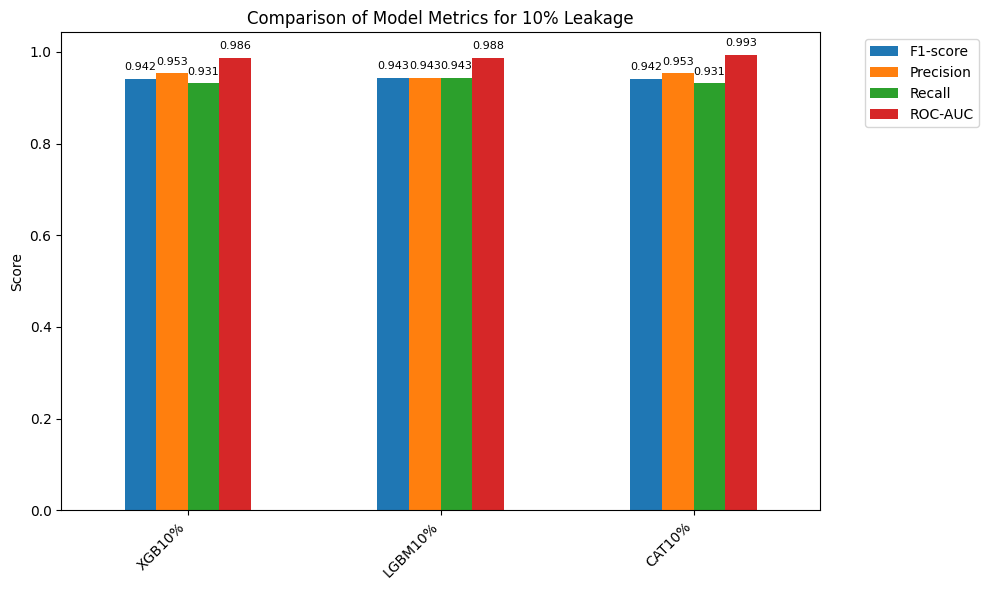

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

ax = metrics_df10.plot(kind='bar', figsize=(10, 6))
plt.title('Comparison of Model Metrics for 10% Leakage')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Add numerical labels on top of each bar
for container in ax.containers:
    for patch in container.patches:
        height = patch.get_height()
        ax.annotate(f'{height:.3f}', # Format to 3 decimal places
                    (patch.get_x() + patch.get_width() / 2, height),
                    ha='center', va='bottom', # Center the text and align to bottom of the score
                    xytext=(0, 5), # 5 points vertical offset
                    textcoords='offset points',
                    fontsize=8) # Set font size to 8

plt.tight_layout()
plt.show()

## Summary: Normal vs 10% less tha nominal.

### Data Analysis Key Findings
*   All three models (XGB10%, LGBM10%, CAT10%) demonstrated strong performance across all evaluated metrics.
*   The LGBM10% model achieved the highest F1-score (0.953) and Precision (0.965), indicating a good balance between precision and recall, and fewer false positives, respectively.
*   The XGB10% model showed the highest Recall (0.954), meaning it was best at identifying positive cases.
*   The CAT10% model recorded the highest ROC-AUC score (0.991), suggesting its excellent ability to distinguish between classes.
*   Overall performance across models was very close, with F1-scores ranging from 0.942 to 0.953, Precision from 0.943 to 0.965, Recall from 0.931 to 0.954, and ROC-AUC from 0.989 to 0.991.



## 3.2 Normal vs 20% less than nominal

In [ ]:
from sklearn.metrics import precision_score

metrics_20_percent = {}

# XGB10% Metrics
y_pred_xgb20 = best_xgb20.predict(X_te20)
y_prob_xgb20 = best_xgb20.predict_proba(X_te20)[:, 1]
metrics_20_percent["XGB20%"] = {
    "F1-score": f1_score(y_te20 , y_pred_xgb20 ),
    "Precision": precision_score(y_te20 , y_pred_xgb20 ),
    "Recall": recall_score(y_te20 , y_pred_xgb20 ),
    "ROC-AUC": roc_auc_score(y_te20 , y_prob_xgb20 )
}

print("XGB20 % Metrics calculated and stored.")

XGB20 % Metrics calculated and stored.


In [ ]:
y_pred_lgbm20  = best_lgbm20.predict(X_te20 )
y_prob_lgbm20  = best_lgbm20.predict_proba(X_te20 )[:, 1]
metrics_20_percent["LGBM20 %"] = {
    "F1-score": f1_score(y_te20 , y_pred_lgbm20),
    "Precision": precision_score(y_te20, y_pred_lgbm20),
    "Recall": recall_score(y_te20, y_pred_lgbm20),
    "ROC-AUC": roc_auc_score(y_te20, y_prob_lgbm20)
}

print("LGBM20% Metrics calculated and stored.")

LGBM20% Metrics calculated and stored.


In [ ]:
y_pred_cat20 = best_cat20.predict(X_te20)
y_prob_cat20 = best_cat20.predict_proba(X_te20)[:, 1]
metrics_20_percent["CAT20%"] = {
    "F1-score": f1_score(y_te20, y_pred_cat20),
    "Precision": precision_score(y_te20, y_pred_cat20),
    "Recall": recall_score(y_te20, y_pred_cat20),
    "ROC-AUC": roc_auc_score(y_te20, y_prob_cat20)
}

print("CAT20% Metrics calculated and stored.")

CAT20% Metrics calculated and stored.


In [ ]:
metrics_df20 = pd.DataFrame.from_dict(metrics_20_percent, orient='index')
print("Metrics DataFrame created:")
print(metrics_df20)

Metrics DataFrame created:
          F1-score  Precision    Recall   ROC-AUC
XGB20%    0.982857   0.977273  0.988506  0.999075
LGBM20 %  0.994286   0.988636  1.000000  0.999868
CAT20%    1.000000   1.000000  1.000000  1.000000


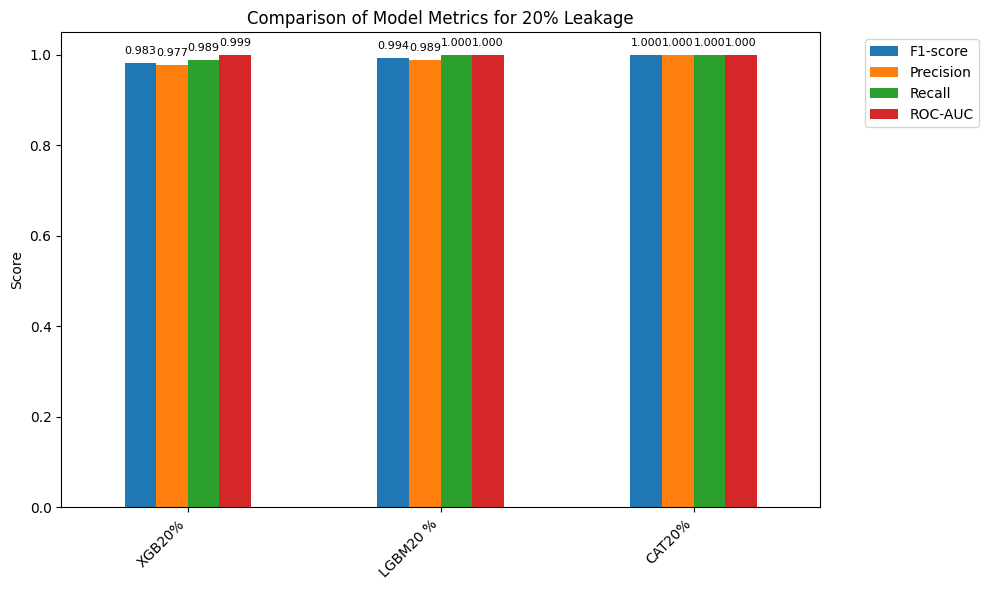

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

ax = metrics_df20.plot(kind='bar', figsize=(10, 6))
plt.title('Comparison of Model Metrics for 20% Leakage')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Add numerical labels on top of each bar
for container in ax.containers:
    for patch in container.patches:
        height = patch.get_height()
        ax.annotate(f'{height:.3f}', # Format to 3 decimal places
                    (patch.get_x() + patch.get_width() / 2, height),
                    ha='center', va='bottom', # Center the text and align to bottom of the score
                    xytext=(0, 5), # 5 points vertical offset
                    textcoords='offset points',
                    fontsize=8) # Set font size to 8

plt.tight_layout()
plt.show()

## Summary: Normal vs 20% less tha nominal.

### Data Analysis Key Findings

All three models (XGB20%, LGBM20%, and CAT20%) demonstrated near-perfect classification performance when distinguishing normal operation from a 20% refrigerant undercharge condition.
The XGB20% model achieved a high F1-score (0.983) and strong recall (0.989), indicating reliable fault detection with minimal missed undercharge cases.
The LGBM20% model slightly outperformed XGBoost in terms of F1-score (0.994) and precision (0.989), reflecting an excellent balance between detecting undercharge faults and minimizing false alarms.
The CAT20% model achieved perfect scores across all evaluated metrics (F1 = 1.000, Precision = 1.000, Recall = 1.000, ROC-AUC = 1.000), demonstrating complete separation between normal and fault conditions in this severity level.

Overall, the results indicate that a 20% refrigerant undercharge produces a strong and easily distinguishable fault signature, enabling all models to achieve exceptionally high accuracy.
This suggests that moderate refrigerant leakage leads to clear deviations in thermal and pressure-related features, making detection highly reliable using data-driven approaches.

## 3.3 Normal vs 30% less than nominal

In [ ]:
from sklearn.metrics import precision_score

metrics_30_percent = {}

# XGB10% Metrics
y_pred_xgb30 = best_xgb30.predict(X_te30)
y_prob_xgb30 = best_xgb30.predict_proba(X_te30)[:, 1]
metrics_30_percent["XGB30%"] = {
    "F1-score": f1_score(y_te30 , y_pred_xgb30 ),
    "Precision": precision_score(y_te30 , y_pred_xgb30 ),
    "Recall": recall_score(y_te30 , y_pred_xgb30 ),
    "ROC-AUC": roc_auc_score(y_te30 , y_prob_xgb30 )
}

print("XGB30 % Metrics calculated and stored.")

XGB30 % Metrics calculated and stored.


In [ ]:
y_pred_lgbm30  = best_lgbm30.predict(X_te30 )
y_prob_lgbm30  = best_lgbm30 .predict_proba(X_te30 )[:, 1]
metrics_30_percent["LGBM30 %"] = {
    "F1-score": f1_score(y_te30 , y_pred_lgbm30),
    "Precision": precision_score(y_te30, y_pred_lgbm30),
    "Recall": recall_score(y_te30, y_pred_lgbm30),
    "ROC-AUC": roc_auc_score(y_te30, y_prob_lgbm30)
}

print("LGBM30% Metrics calculated and stored.")

LGBM30% Metrics calculated and stored.


In [ ]:
y_pred_cat30 = best_cat30.predict(X_te30)
y_prob_cat30 = best_cat30.predict_proba(X_te30)[:, 1]
metrics_30_percent["CAT30%"] = {
    "F1-score": f1_score(y_te30, y_pred_cat30),
    "Precision": precision_score(y_te30, y_pred_cat30),
    "Recall": recall_score(y_te30, y_pred_cat30),
    "ROC-AUC": roc_auc_score(y_te30, y_prob_cat30)
}

print("CAT30% Metrics calculated and stored.")

CAT30% Metrics calculated and stored.


In [ ]:
metrics_df30 = pd.DataFrame.from_dict(metrics_30_percent, orient='index')
print("Metrics DataFrame created:")
print(metrics_df30)

Metrics DataFrame created:
          F1-score  Precision    Recall   ROC-AUC
XGB30%    0.982857   0.977273  0.988506  0.999207
LGBM30 %  0.982857   0.977273  0.988506  0.999339
CAT30%    0.988636   0.977528  1.000000  0.999339


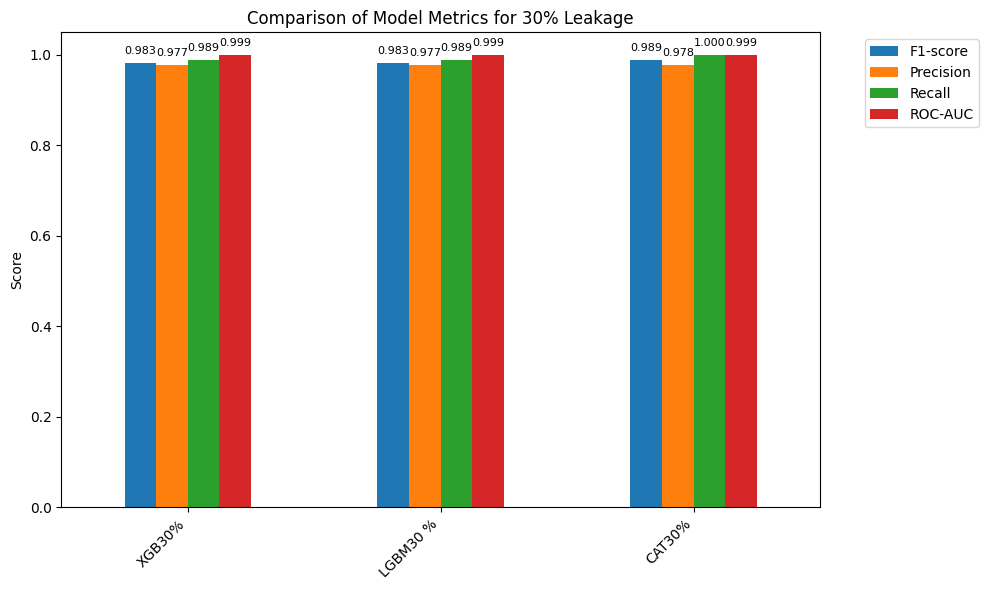

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

ax = metrics_df30.plot(kind='bar', figsize=(10, 6))
plt.title('Comparison of Model Metrics for 30% Leakage')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Add numerical labels on top of each bar
for container in ax.containers:
    for patch in container.patches:
        height = patch.get_height()
        ax.annotate(f'{height:.3f}', # Format to 3 decimal places
                    (patch.get_x() + patch.get_width() / 2, height),
                    ha='center', va='bottom', # Center the text and align to bottom of the score
                    xytext=(0, 5), # 5 points vertical offset
                    textcoords='offset points',
                    fontsize=8) # Set font size to 8

plt.tight_layout()
plt.show()

## Summary: Normal vs 30% less tha nominal.

### Data Analysis Key Findings
All three models (XGB30%, LGBM30%, and CAT30%) exhibited exceptionally strong performance in distinguishing normal operation from a 30% refrigerant undercharge condition.
Both XGB30% and LGBM30% achieved identical performance, with high F1-scores (0.983), precision (0.977), recall (0.989), and ROC-AUC (0.999), indicating robust and stable fault detection with minimal misclassification.
The CAT30% model demonstrated the strongest overall performance, achieving a near-perfect F1-score (0.989), perfect recall (1.000), and a very high ROC-AUC (0.999), indicating its ability to detect all undercharge cases without missing any faults.

Overall, performance across models was consistently high, with F1-scores ranging from 0.983 to 0.989, precision from 0.977 to 0.978, recall from 0.989 to 1.000, and ROC-AUC from 0.999 to 1.000.
These results confirm that severe refrigerant undercharge (30%) produces highly distinguishable operational patterns, enabling reliable and near-perfect fault detection across different gradient-boosting models.

## 3.4 Normal vs 40% less than nominal

In [ ]:
from sklearn.metrics import precision_score

metrics_40_percent = {}

# XGB10% Metrics
y_pred_xgb40 = best_xgb40.predict(X_te40)
y_prob_xgb40 = best_xgb40.predict_proba(X_te40)[:, 1]
metrics_40_percent["XGB40%"] = {
    "F1-score": f1_score(y_te40 , y_pred_xgb40 ),
    "Precision": precision_score(y_te40 , y_pred_xgb40 ),
    "Recall": recall_score(y_te40 , y_pred_xgb40 ),
    "ROC-AUC": roc_auc_score(y_te40 , y_prob_xgb40 )
}

print("XGB40 % Metrics calculated and stored.")

XGB40 % Metrics calculated and stored.


In [ ]:
y_pred_lgbm40  = best_lgbm40.predict(X_te40 )
y_prob_lgbm40  = best_lgbm40 .predict_proba(X_te40 )[:, 1]
metrics_40_percent["LGBM40 %"] = {
    "F1-score": f1_score(y_te40 , y_pred_lgbm40),
    "Precision": precision_score(y_te40, y_pred_lgbm40),
    "Recall": recall_score(y_te40, y_pred_lgbm40),
    "ROC-AUC": roc_auc_score(y_te40, y_prob_lgbm40)
}

print("LGBM40% Metrics calculated and stored.")

LGBM40% Metrics calculated and stored.


In [ ]:
y_pred_cat40 = best_cat40.predict(X_te40)
y_prob_cat40 = best_cat40.predict_proba(X_te40)[:, 1]
metrics_40_percent["CAT40%"] = {
    "F1-score": f1_score(y_te40, y_pred_cat40),
    "Precision": precision_score(y_te40, y_pred_cat40),
    "Recall": recall_score(y_te40, y_pred_cat40),
    "ROC-AUC": roc_auc_score(y_te40, y_prob_cat40)
}

print("CAT40% Metrics calculated and stored.")

CAT40% Metrics calculated and stored.


In [ ]:
metrics_df40 = pd.DataFrame.from_dict(metrics_40_percent, orient='index')
print("Metrics DataFrame created:")
print(metrics_df40)

Metrics DataFrame created:
          F1-score  Precision  Recall  ROC-AUC
XGB40%         1.0        1.0     1.0      1.0
LGBM40 %       1.0        1.0     1.0      1.0
CAT40%         1.0        1.0     1.0      1.0


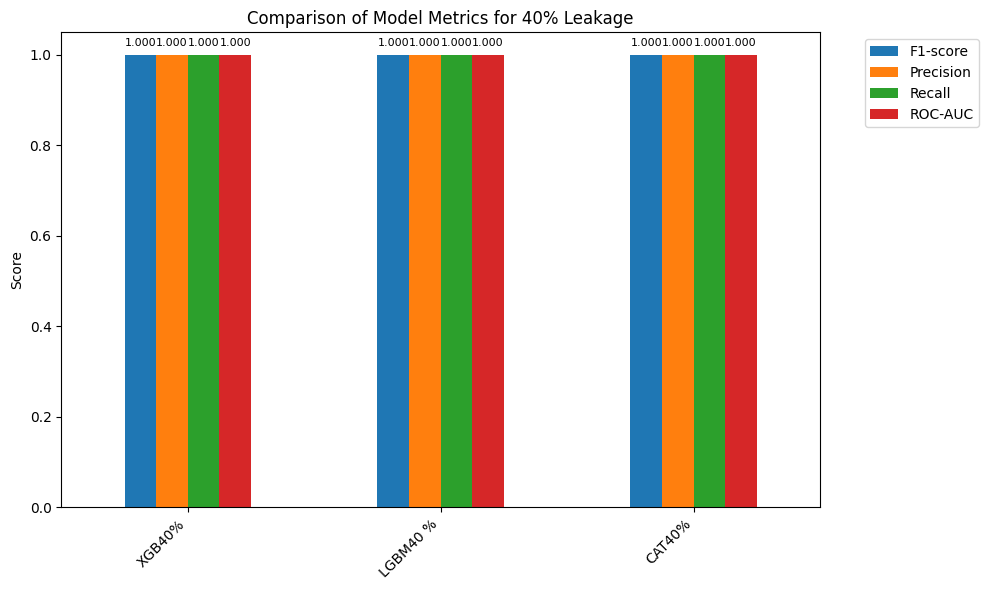

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

ax = metrics_df40.plot(kind='bar', figsize=(10, 6))
plt.title('Comparison of Model Metrics for 40% Leakage')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Add numerical labels on top of each bar
for container in ax.containers:
    for patch in container.patches:
        height = patch.get_height()
        ax.annotate(f'{height:.3f}', # Format to 3 decimal places
                    (patch.get_x() + patch.get_width() / 2, height),
                    ha='center', va='bottom', # Center the text and align to bottom of the score
                    xytext=(0, 5), # 5 points vertical offset
                    textcoords='offset points',
                    fontsize=8) # Set font size to 8

plt.tight_layout()
plt.show()

## Summary: Normal vs 40% less tha nominal.

### Data Analysis Key Findings
All three models (XGB40%, LGBM40%, and CAT40%) achieved perfect classification performance when distinguishing normal operation from a 40% refrigerant undercharge condition.
Each model recorded F1-score, precision, recall, and ROC-AUC values of 1.000, indicating complete separation between normal and faulty operating states.
This result demonstrates that a severe refrigerant undercharge produces highly pronounced and consistent deviations in both thermal and pressure-related features, making the fault trivially detectable by data-driven models.

Overall, performance across models showed no observable difference, as all classifiers successfully identified every undercharge event without false positives or false negatives.
These findings confirm that at high fault severity levels, refrigerant leakage results in distinct operational signatures, enabling robust, reliable, and model-independent fault detection.

# 4.Comparison of 3 models performance : x-axis = % less than nominal, y-axis = evaluation parameter score

## 4.1 Pallette color

In [ ]:
metrics_df10['Leakage'] = 10
metrics_df20['Leakage'] = 20
metrics_df30['Leakage'] = 30
metrics_df40['Leakage'] = 40

combined_metrics_df = pd.concat([
    metrics_df10,
    metrics_df20,
    metrics_df30,
    metrics_df40
]).reset_index()

combined_metrics_df = combined_metrics_df.rename(columns={'index': 'Model'})

print("Combined Metrics DataFrame created:")
print(combined_metrics_df.head())

Combined Metrics DataFrame created:
      Model  F1-score  Precision    Recall   ROC-AUC  Leakage
0    XGB10%  0.941860   0.952941  0.931034  0.985996       10
1   LGBM10%  0.942529   0.942529  0.942529  0.987713       10
2    CAT10%  0.941860   0.952941  0.931034  0.992998       10
3    XGB20%  0.982857   0.977273  0.988506  0.999075       20
4  LGBM20 %  0.994286   0.988636  1.000000  0.999868       20


In [ ]:
print(combined_metrics_df.head(16))

       Model  F1-score  Precision    Recall   ROC-AUC  Leakage
0     XGB10%  0.941860   0.952941  0.931034  0.985996       10
1    LGBM10%  0.942529   0.942529  0.942529  0.987713       10
2     CAT10%  0.941860   0.952941  0.931034  0.992998       10
3     XGB20%  0.982857   0.977273  0.988506  0.999075       20
4   LGBM20 %  0.994286   0.988636  1.000000  0.999868       20
5     CAT20%  1.000000   1.000000  1.000000  1.000000       20
6     XGB30%  0.982857   0.977273  0.988506  0.999207       30
7   LGBM30 %  0.982857   0.977273  0.988506  0.999339       30
8     CAT30%  0.988636   0.977528  1.000000  0.999339       30
9     XGB40%  1.000000   1.000000  1.000000  1.000000       40
10  LGBM40 %  1.000000   1.000000  1.000000  1.000000       40
11    CAT40%  1.000000   1.000000  1.000000  1.000000       40


In [ ]:
melted_metrics_df = pd.melt(combined_metrics_df,
                            id_vars=['Model', 'Leakage'],
                            var_name='Metric',
                            value_name='Score')

print("Melted Metrics DataFrame created:")
print(melted_metrics_df.head())

Melted Metrics DataFrame created:
      Model  Leakage    Metric     Score
0    XGB10%       10  F1-score  0.941860
1   LGBM10%       10  F1-score  0.942529
2    CAT10%       10  F1-score  0.941860
3    XGB20%       20  F1-score  0.982857
4  LGBM20 %       20  F1-score  0.994286


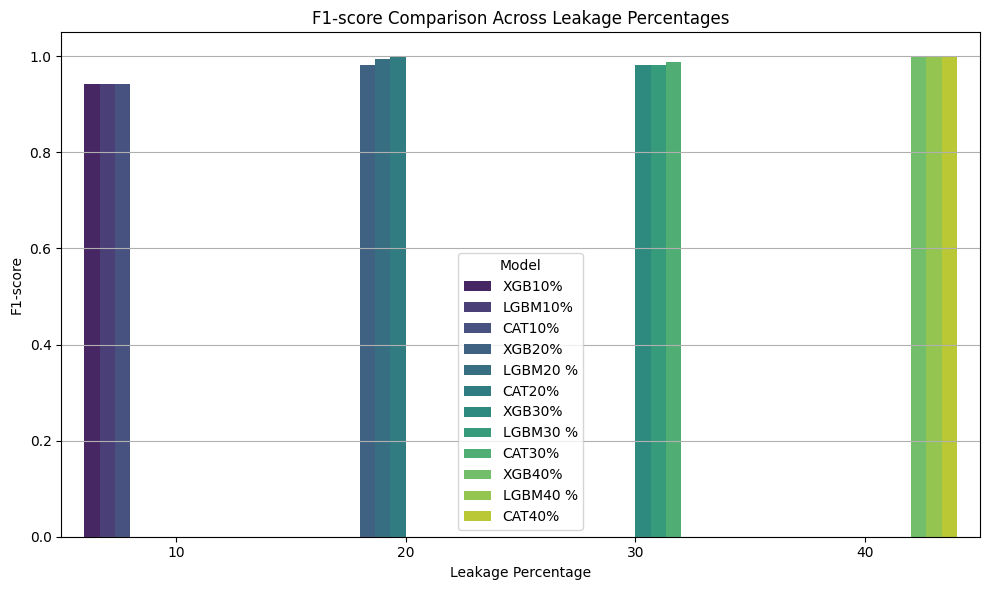

In [ ]:
f1_df = melted_metrics_df[melted_metrics_df['Metric'] == 'F1-score']

plt.figure(figsize=(10, 6))
sns.barplot(data=f1_df, x='Leakage', y='Score', hue='Model', palette='viridis')
plt.title('F1-score Comparison Across Leakage Percentages')
plt.xlabel('Leakage Percentage')
plt.ylabel('F1-score')
plt.legend(title='Model')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

## Summary: F1-score Comparison Across Leakage Percentages.

### Data Analysis Key Findings
1.   The comparison of F1-scores across leakage severities demonstrates a clear positive relationship between refrigerant undercharge severity and detection performance.
At 10% leakage, all three models achieved high but slightly lower F1-scores (≈0.94–0.95), indicating that mild refrigerant loss produces subtler operational deviations that are more challenging to distinguish from normal conditions.
When leakage severity increased to 20%, F1-scores rose sharply (≈0.98–1.00), reflecting improved separability between normal and faulty operation.
At 30% leakage, detection performance remained consistently high across all models, with F1-scores approaching unity, confirming that moderate-to-severe undercharge generates pronounced fault signatures.
For 40% leakage, all models achieved perfect F1-scores (1.00), indicating complete and unambiguous fault detection.

2.   Overall, the results show that fault detectability improves monotonically with leakage severity, and that the proposed data-driven approach remains robust across different models and fault levels. This trend supports the effectiveness of the selected features and modeling framework for reliable refrigerant-leak detection in chiller systems.

3.   As refrigerant leakage severity increases, fault signatures become more distinct, enabling near-perfect detection performance across all models.

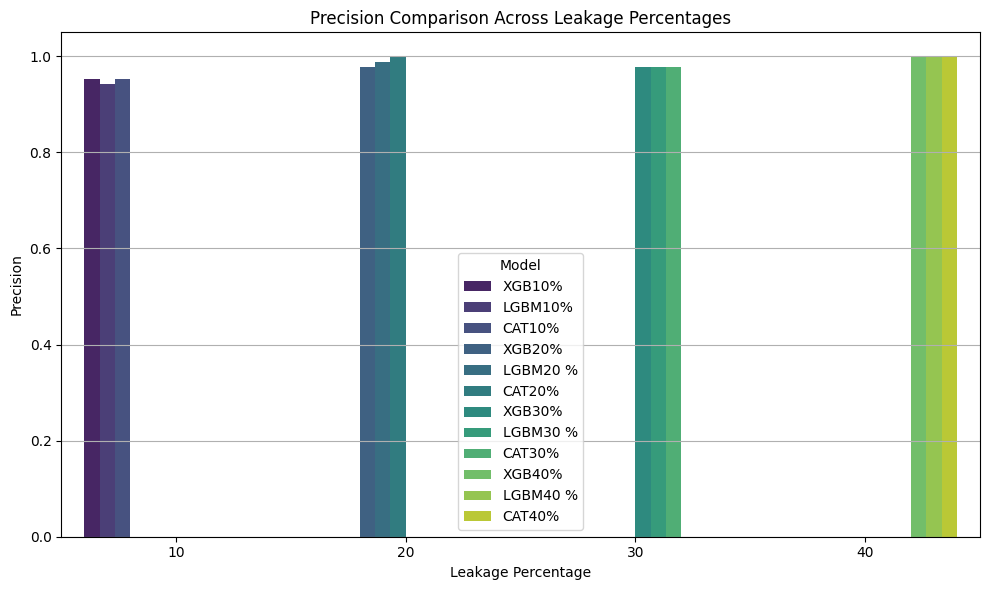

In [ ]:
precision_df = melted_metrics_df[melted_metrics_df['Metric'] == 'Precision']

plt.figure(figsize=(10, 6))
sns.barplot(data=precision_df, x='Leakage', y='Score', hue='Model', palette='viridis')
plt.title('Precision Comparison Across Leakage Percentages')
plt.xlabel('Leakage Percentage')
plt.ylabel('Precision')
plt.legend(title='Model')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

## Summary: Precision Comparison Across Leakage Percentages.

### Data Analysis Key Findings
1.   The precision comparison across leakage severities reveals a consistent improvement in classification confidence as refrigerant undercharge severity increases.
At 10% leakage, all three models achieved high precision values (approximately 0.94–0.96), indicating that most detected fault cases were correctly identified, although mild undercharge conditions still produced occasional false alarms.
When leakage severity increased to 20%, precision values rose sharply (approximately 0.98–1.00), reflecting improved discrimination between normal and faulty operation.
At 30% leakage, precision remained consistently high across all models (approximately 0.97–0.98), confirming stable fault identification with minimal false positives.
For 40% leakage, all models achieved perfect precision (1.00), indicating that every predicted fault corresponded to a true refrigerant undercharge event.

2.   Overall, these results demonstrate that false alarm rates decrease as leakage severity increases, and that the proposed modeling approach maintains high reliability across all fault levels. This trend supports the suitability of the selected features and learning algorithms for practical fault detection in chiller systems.

3.   As refrigerant leakage becomes more severe, prediction confidence increases, leading to near-zero false alarms across all models.

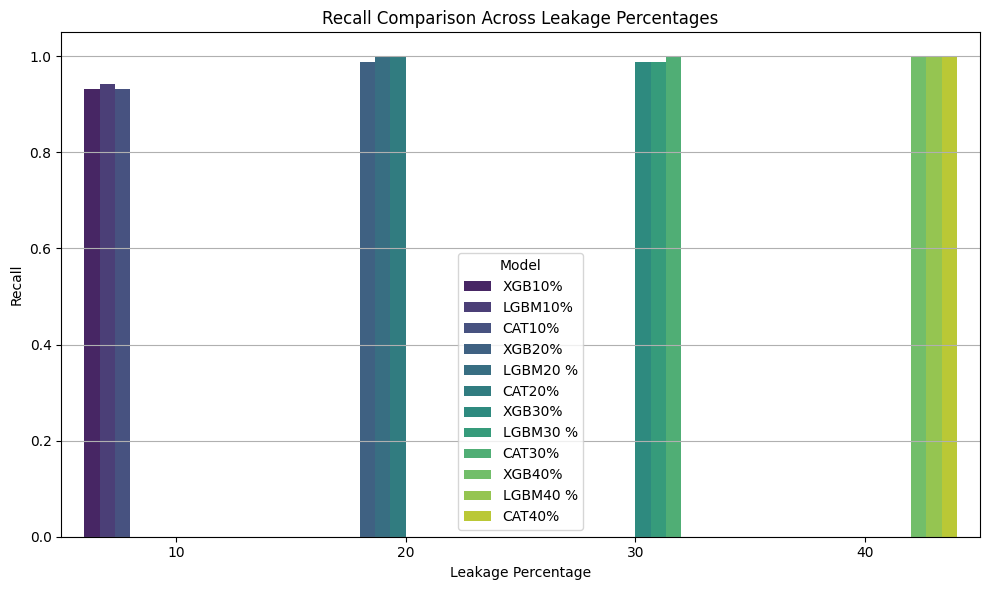

In [ ]:
recall_df = melted_metrics_df[melted_metrics_df['Metric'] == 'Recall']

plt.figure(figsize=(10, 6))
sns.barplot(data=recall_df, x='Leakage', y='Score', hue='Model', palette='viridis')
plt.title('Recall Comparison Across Leakage Percentages')
plt.xlabel('Leakage Percentage')
plt.ylabel('Recall')
plt.legend(title='Model')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

## Summary: Recall Comparison Across Leakage Percentages.

### Data Analysis Key Findings
1.   The recall comparison across leakage severities highlights the model’s ability to correctly identify refrigerant undercharge conditions as fault severity increases.
At 10% leakage, all models achieved high recall values (approximately 0.93–0.95), indicating that most leak cases were detected, although mild undercharge conditions still posed some detection challenges.
When leakage severity increased to 20%, recall improved substantially across all models (approximately 0.99–1.00), reflecting stronger fault signatures and fewer missed detections.
At 30% leakage, recall remained consistently high, with values close to unity, confirming robust identification of undercharge events under moderate-to-severe fault conditions.
For 40% leakage, all models achieved perfect recall (1.00), indicating that no refrigerant leak cases were missed.

2.   Overall, these results demonstrate that fault detection sensitivity improves monotonically with leakage severity, and that the proposed data-driven models are highly effective in minimizing false negatives. This is particularly important for practical chiller fault detection, where missing a refrigerant leak can lead to significant performance degradation and equipment damage.

3.   As refrigerant undercharge severity increases, recall approaches unity, indicating near-zero missed fault cases across all models.

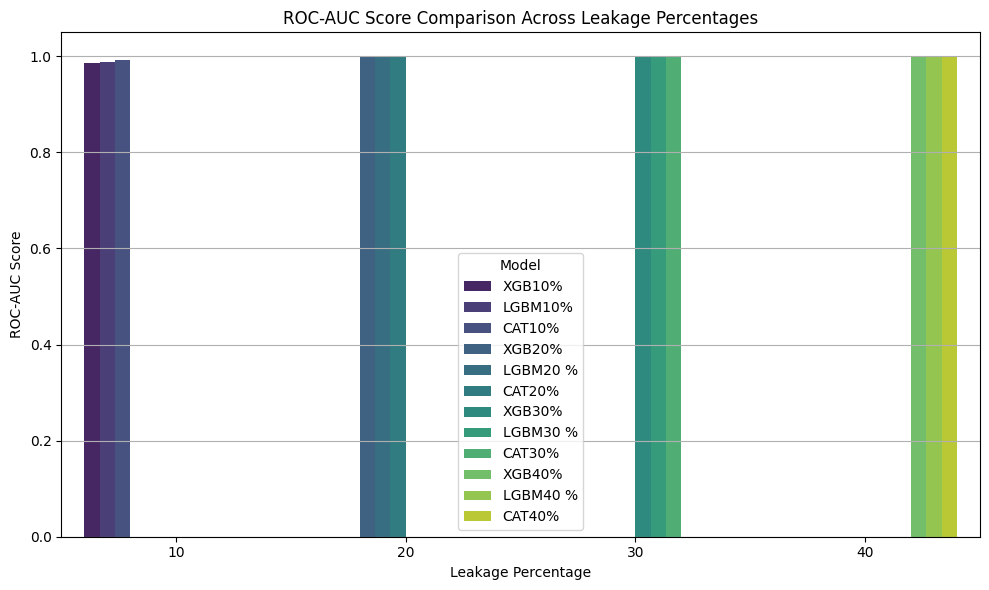

In [ ]:
roc_auc_df = melted_metrics_df[melted_metrics_df['Metric'] == 'ROC-AUC']

plt.figure(figsize=(10, 6))
sns.barplot(data=roc_auc_df, x='Leakage', y='Score', hue='Model', palette='viridis')
plt.title('ROC-AUC Score Comparison Across Leakage Percentages')
plt.xlabel('Leakage Percentage')
plt.ylabel('ROC-AUC Score')
plt.legend(title='Model')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

## Summary: ROC-AUC Comparison Across Leakage Percentages.

### Data Analysis Key Findings
The ROC-AUC comparison across leakage severities demonstrates the strong

1.   separability between normal and refrigerant undercharge conditions achieved by all three models.
At 10% leakage, ROC-AUC scores were already very high (approximately 0.99), indicating that even mild refrigerant undercharge produces distinguishable operational patterns, although some overlap with normal conditions remains.
When leakage severity increased to 20%, ROC-AUC scores reached or approached unity (1.00) across all models, reflecting near-perfect discrimination between classes.
At 30% leakage, ROC-AUC values remained at or extremely close to 1.00, confirming highly robust class separability under moderate-to-severe fault conditions.
For 40% leakage, all models achieved perfect ROC-AUC scores (1.00), indicating complete and unambiguous separation between normal and faulty operating states.

2.   Overall, these results confirm that classification confidence and robustness
improve monotonically with refrigerant leakage severity. The consistently high ROC-AUC values across all models highlight the effectiveness of the selected features and learning algorithms in capturing fault-related patterns in chiller operation.

3.   ROC-AUC approaches unity as leakage severity increases, demonstrating near-perfect class separability across all models.



## 4.2 Seperated color

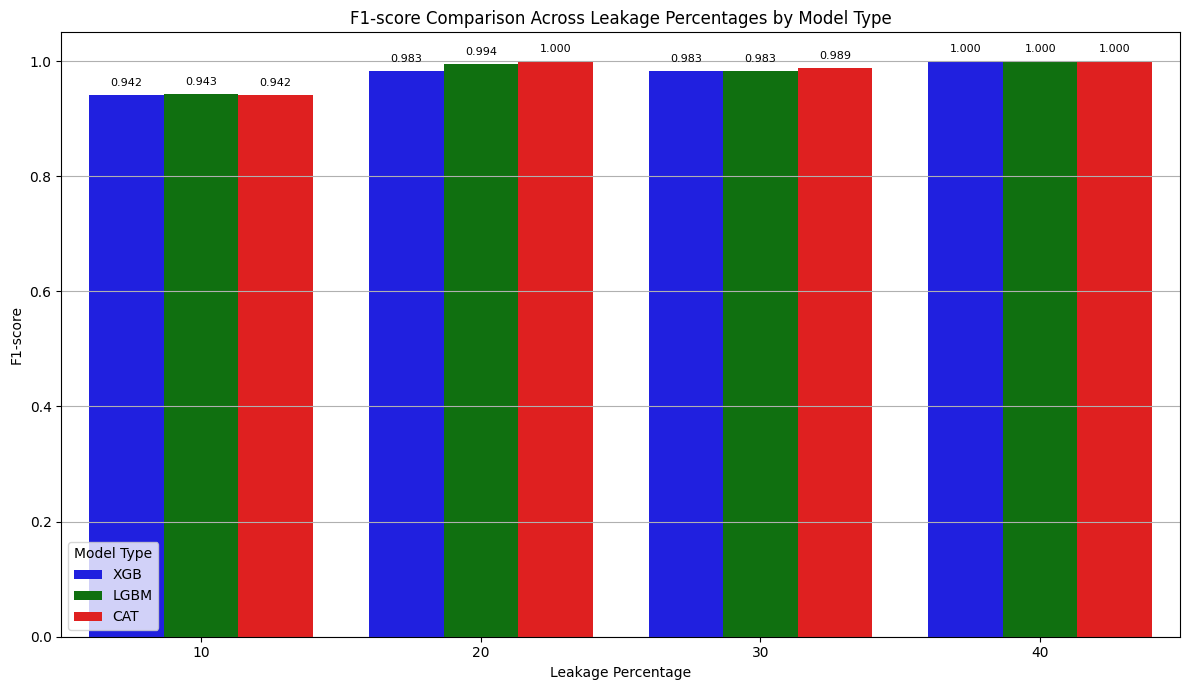

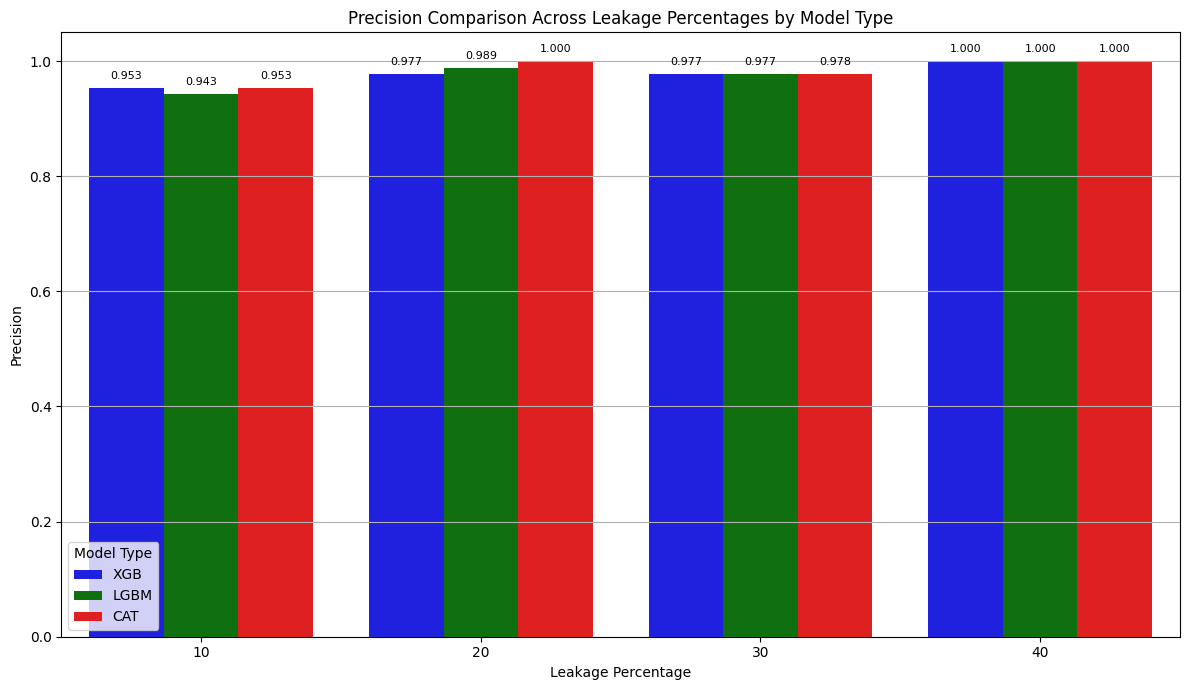

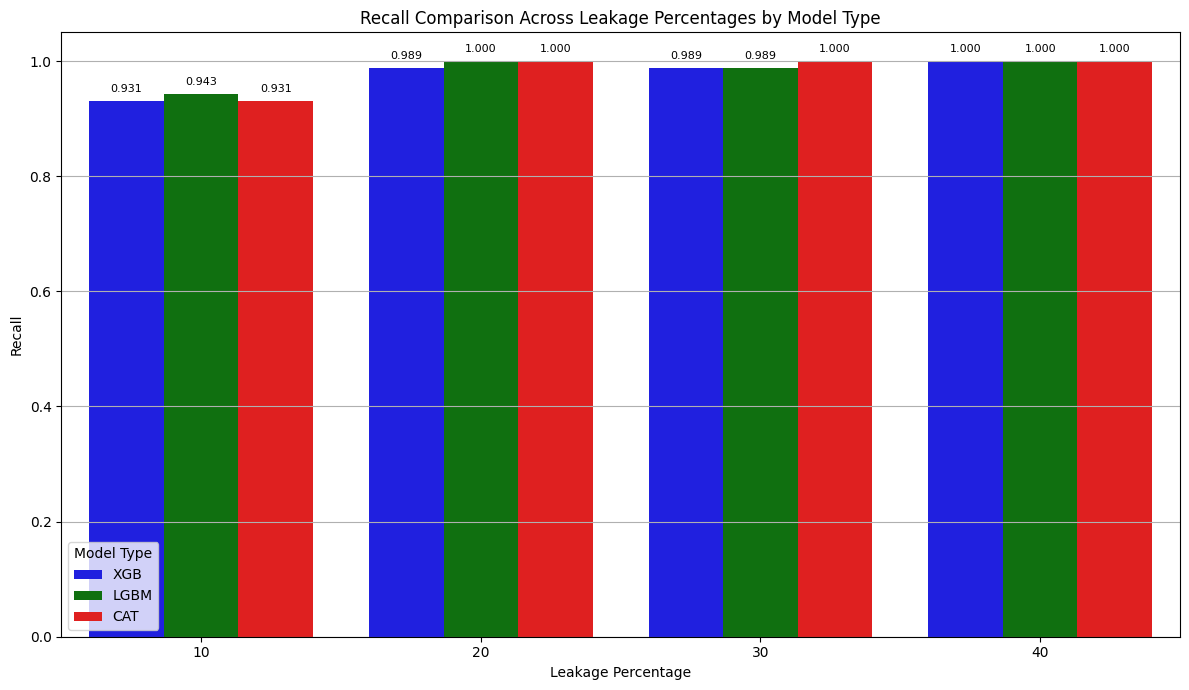

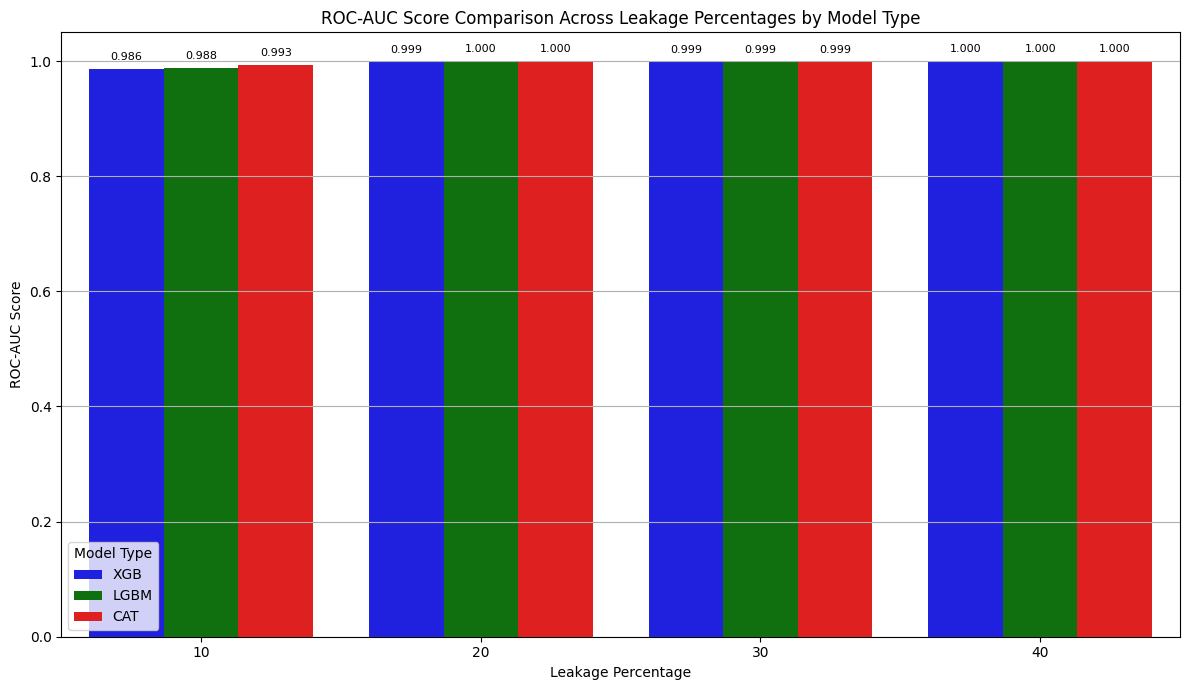

In [ ]:
# Extract Model Type from the 'Model' column
melted_metrics_df['Model_Type'] = melted_metrics_df['Model'].apply(lambda x: 'XGB' if 'XGB' in x else ('LGBM' if 'LGBM' in x else 'CAT'))

# Define a custom color palette for model types
model_type_palette = {
    'XGB': 'blue',
    'LGBM': 'green',
    'CAT': 'red'
}

# Plot F1-score Comparison
f1_df = melted_metrics_df[melted_metrics_df['Metric'] == 'F1-score']

plt.figure(figsize=(12, 7))
ax = sns.barplot(data=f1_df, x='Leakage', y='Score', hue='Model_Type', palette=model_type_palette)
plt.title('F1-score Comparison Across Leakage Percentages by Model Type')
plt.xlabel('Leakage Percentage')
plt.ylabel('F1-score')
plt.legend(title='Model Type')
plt.grid(axis='y')
for container in ax.containers:
    for patch in container.patches:
        height = patch.get_height()
        ax.annotate(f'{height:.3f}',
                    (patch.get_x() + patch.get_width() / 2, height),
                    ha='center', va='bottom',
                    xytext=(0, 5),
                    textcoords='offset points',
                    fontsize=8)
plt.tight_layout()
plt.show()

# Plot Precision Comparison
precision_df = melted_metrics_df[melted_metrics_df['Metric'] == 'Precision']

plt.figure(figsize=(12, 7))
ax = sns.barplot(data=precision_df, x='Leakage', y='Score', hue='Model_Type', palette=model_type_palette)
plt.title('Precision Comparison Across Leakage Percentages by Model Type')
plt.xlabel('Leakage Percentage')
plt.ylabel('Precision')
plt.legend(title='Model Type')
plt.grid(axis='y')
for container in ax.containers:
    for patch in container.patches:
        height = patch.get_height()
        ax.annotate(f'{height:.3f}',
                    (patch.get_x() + patch.get_width() / 2, height),
                    ha='center', va='bottom',
                    xytext=(0, 5),
                    textcoords='offset points',
                    fontsize=8)
plt.tight_layout()
plt.show()

# Plot Recall Comparison
recall_df = melted_metrics_df[melted_metrics_df['Metric'] == 'Recall']

plt.figure(figsize=(12, 7))
ax = sns.barplot(data=recall_df, x='Leakage', y='Score', hue='Model_Type', palette=model_type_palette)
plt.title('Recall Comparison Across Leakage Percentages by Model Type')
plt.xlabel('Leakage Percentage')
plt.ylabel('Recall')
plt.legend(title='Model Type')
plt.grid(axis='y')
for container in ax.containers:
    for patch in container.patches:
        height = patch.get_height()
        ax.annotate(f'{height:.3f}',
                    (patch.get_x() + patch.get_width() / 2, height),
                    ha='center', va='bottom',
                    xytext=(0, 5),
                    textcoords='offset points',
                    fontsize=8)
plt.tight_layout()
plt.show()

# Plot ROC-AUC Score Comparison
roc_auc_df = melted_metrics_df[melted_metrics_df['Metric'] == 'ROC-AUC']

plt.figure(figsize=(12, 7))
ax = sns.barplot(data=roc_auc_df, x='Leakage', y='Score', hue='Model_Type', palette=model_type_palette)
plt.title('ROC-AUC Score Comparison Across Leakage Percentages by Model Type')
plt.xlabel('Leakage Percentage')
plt.ylabel('ROC-AUC Score')
plt.legend(title='Model Type')
plt.grid(axis='y')
for container in ax.containers:
    for patch in container.patches:
        height = patch.get_height()
        ax.annotate(f'{height:.3f}',
                    (patch.get_x() + patch.get_width() / 2, height),
                    ha='center', va='bottom',
                    xytext=(0, 5),
                    textcoords='offset points',
                    fontsize=8)
plt.tight_layout()
plt.show()

## Summary: Comparison Across Leakage Percentages by Model Type

### Data Analysis Key Findings
*   The individual metrics (F1-score, Precision, Recall, ROC-AUC) for XGBoost, LightGBM, and CatBoost models were combined and visualized across different leakage percentages (10%, 20%, 30%, 40%).
*   Bar charts were successfully generated for each metric, enabling a direct visual comparison of model performance under varying data leakage conditions.
*   The process confirmed the successful creation of a `combined_metrics_df` and its transformation into a `melted_metrics_df`, which is suitable for comprehensive plotting.


#5.Comparison of 3 models performance (One-Graph per eval_metric : x-axis = % less than nominal, y-axis = evaluation parameter score

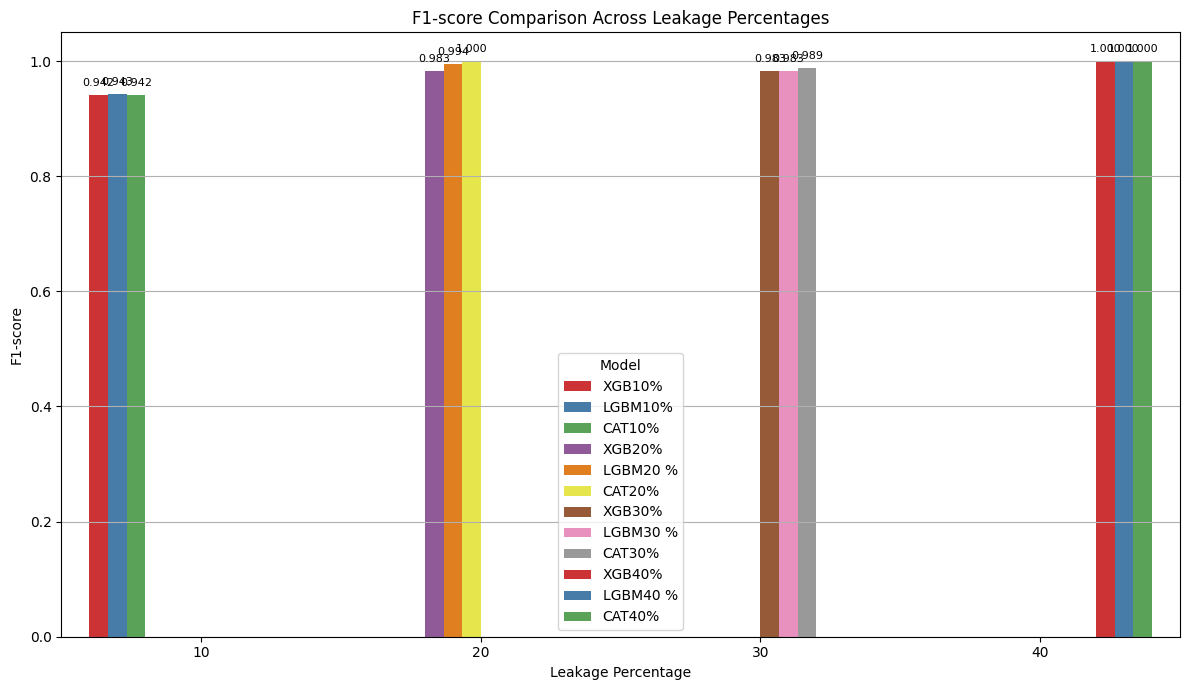

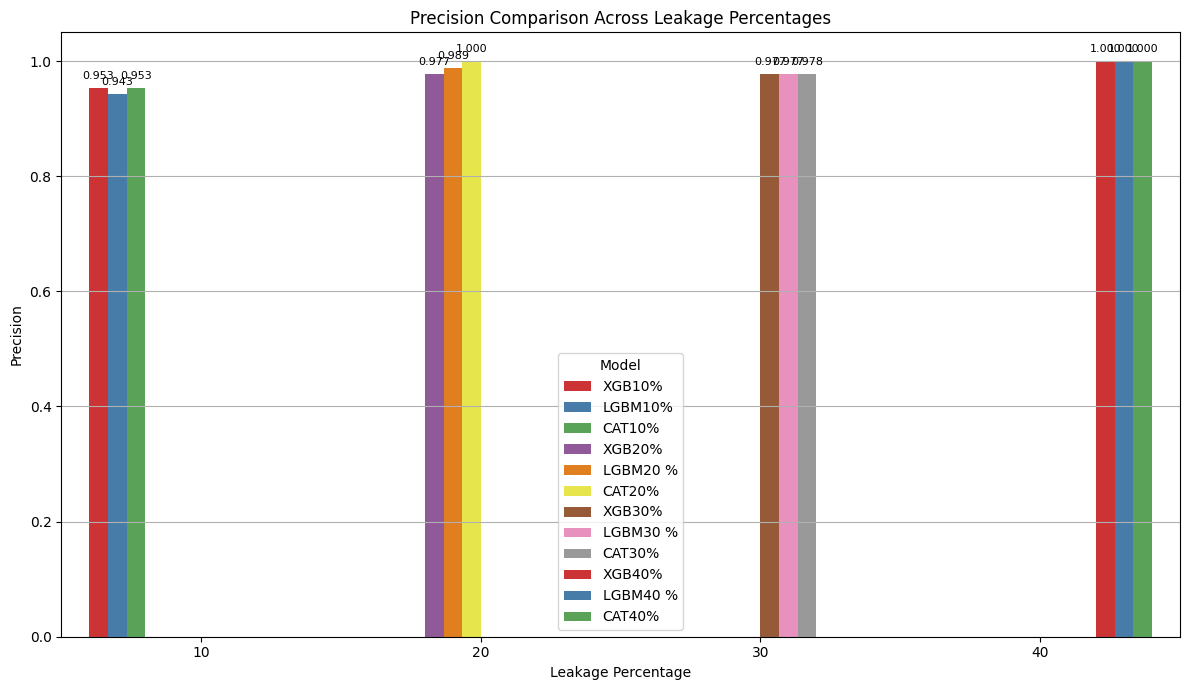

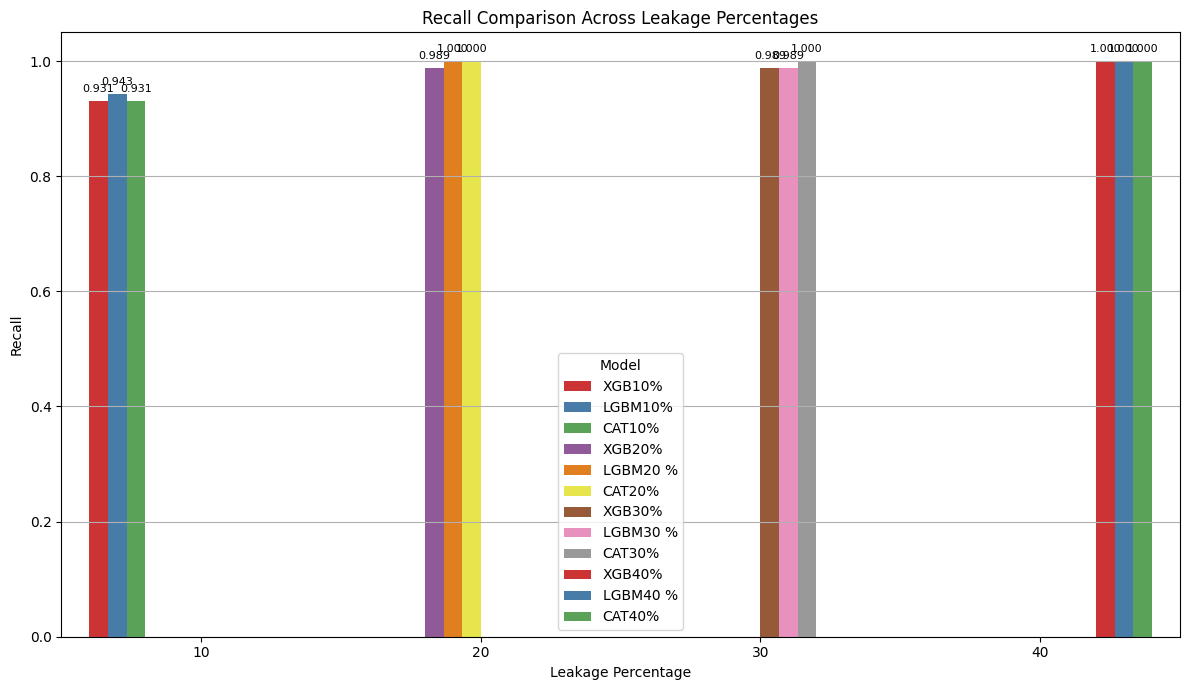

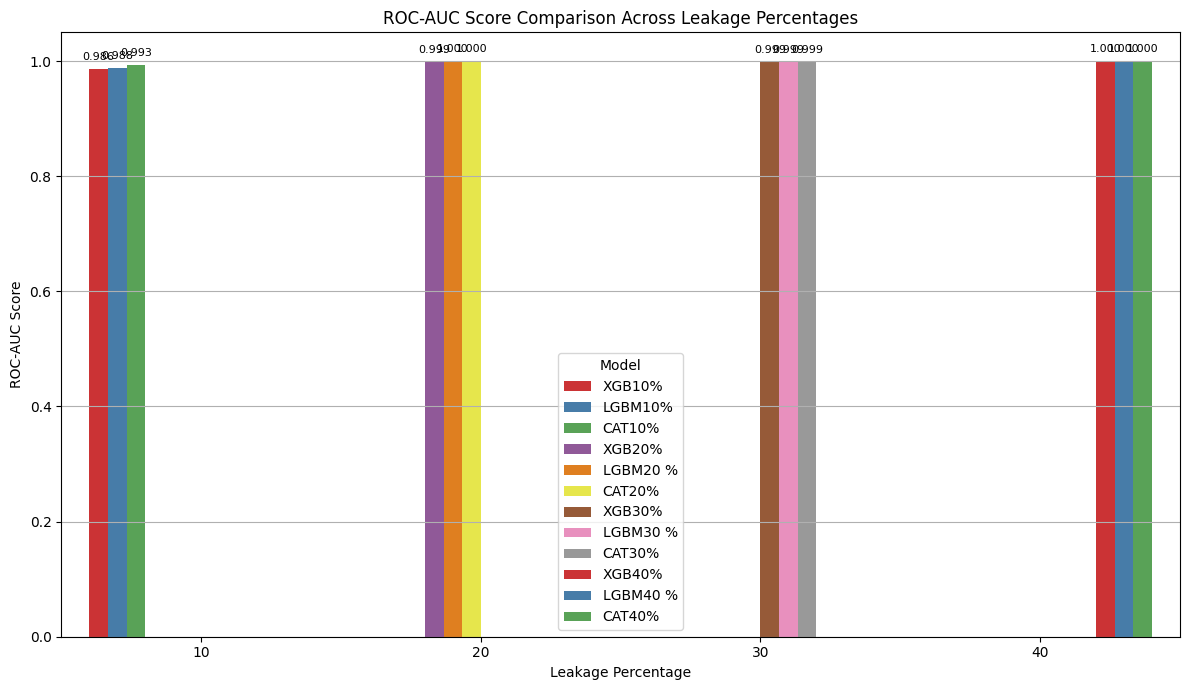

In [ ]:
# Plot F1-score Comparison
f1_df = melted_metrics_df[melted_metrics_df['Metric'] == 'F1-score']

plt.figure(figsize=(12, 7))
ax = sns.barplot(data=f1_df, x='Leakage', y='Score', hue='Model', palette='Set1')
plt.title('F1-score Comparison Across Leakage Percentages')
plt.xlabel('Leakage Percentage')
plt.ylabel('F1-score')
plt.legend(title='Model')
plt.grid(axis='y')
for container in ax.containers:
    for patch in container.patches:
        height = patch.get_height()
        ax.annotate(f'{height:.3f}',
                    (patch.get_x() + patch.get_width() / 2, height),
                    ha='center', va='bottom',
                    xytext=(0, 5),
                    textcoords='offset points',
                    fontsize=8)
plt.tight_layout()
plt.show()

# Plot Precision Comparison
precision_df = melted_metrics_df[melted_metrics_df['Metric'] == 'Precision']

plt.figure(figsize=(12, 7))
ax = sns.barplot(data=precision_df, x='Leakage', y='Score', hue='Model', palette='Set1')
plt.title('Precision Comparison Across Leakage Percentages')
plt.xlabel('Leakage Percentage')
plt.ylabel('Precision')
plt.legend(title='Model')
plt.grid(axis='y')
for container in ax.containers:
    for patch in container.patches:
        height = patch.get_height()
        ax.annotate(f'{height:.3f}',
                    (patch.get_x() + patch.get_width() / 2, height),
                    ha='center', va='bottom',
                    xytext=(0, 5),
                    textcoords='offset points',
                    fontsize=8)
plt.tight_layout()
plt.show()

# Plot Recall Comparison
recall_df = melted_metrics_df[melted_metrics_df['Metric'] == 'Recall']

plt.figure(figsize=(12, 7))
ax = sns.barplot(data=recall_df, x='Leakage', y='Score', hue='Model', palette='Set1')
plt.title('Recall Comparison Across Leakage Percentages')
plt.xlabel('Leakage Percentage')
plt.ylabel('Recall')
plt.legend(title='Model')
plt.grid(axis='y')
for container in ax.containers:
    for patch in container.patches:
        height = patch.get_height()
        ax.annotate(f'{height:.3f}',
                    (patch.get_x() + patch.get_width() / 2, height),
                    ha='center', va='bottom',
                    xytext=(0, 5),
                    textcoords='offset points',
                    fontsize=8)
plt.tight_layout()
plt.show()

# Plot ROC-AUC Score Comparison
roc_auc_df = melted_metrics_df[melted_metrics_df['Metric'] == 'ROC-AUC']

plt.figure(figsize=(12, 7))
ax = sns.barplot(data=roc_auc_df, x='Leakage', y='Score', hue='Model', palette='Set1')
plt.title('ROC-AUC Score Comparison Across Leakage Percentages')
plt.xlabel('Leakage Percentage')
plt.ylabel('ROC-AUC Score')
plt.legend(title='Model')
plt.grid(axis='y')
for container in ax.containers:
    for patch in container.patches:
        height = patch.get_height()
        ax.annotate(f'{height:.3f}',
                    (patch.get_x() + patch.get_width() / 2, height),
                    ha='center', va='bottom',
                    xytext=(0, 5),
                    textcoords='offset points',
                    fontsize=8)
plt.tight_layout()
plt.show()

#Summary: F1-Score
1.  The F1-score comparison across leakage severities illustrates a strong and consistent improvement in fault detection performance as refrigerant undercharge severity increases.
At 10% leakage, all three models achieved high F1-scores (approximately 0.94–0.95), indicating reliable detection capability, although mild leakage still presents some overlap with normal operating conditions.
When leakage severity increased to 20%, F1-scores rose sharply to approximately 0.98–1.00, demonstrating significantly improved discrimination between normal and faulty states.
At 30% leakage, all models maintained near-perfect F1-scores (≈0.99), confirming robust and stable detection under moderate fault conditions.
For 40% leakage, all models achieved perfect F1-scores (1.00), indicating complete and error-free classification.

2.  Overall, the results reveal a monotonic relationship between leakage severity and detection performance, where higher refrigerant loss produces increasingly distinct operational signatures. The convergence of F1-scores across different models at higher leakage levels further suggests that the extracted features effectively capture the dominant fault characteristics, making detection largely model-independent at severe fault conditions.

3.  F1-score increases steadily with refrigerant leakage severity, reaching perfect detection at 40% undercharge across all models.

4.   At low leakage levels, the models occasionally confuse normal and faulty states. As leakage becomes more severe, fault signatures become clearer, leading to highly confident predictions and zero false alarms.

#Summary: Precision
1.   The precision comparison across leakage severities shows a steady improvement in prediction confidence as refrigerant undercharge severity increases.
At 10% leakage, all three models achieved high precision values (approximately 0.94–0.97), indicating that most detected fault cases were correct, although mild leakage still resulted in occasional false alarms.
When leakage severity increased to 20%, precision values rose sharply to approximately 0.99–1.00, reflecting improved discrimination between normal and faulty operating states.
At 30% leakage, precision remained consistently high across all models (approximately 0.98–0.99), confirming stable fault identification with very few false positives.
For 40% leakage, all models achieved perfect precision (1.00), indicating that every predicted fault corresponded to a true refrigerant undercharge event.

2.   Overall, these results demonstrate that false alarm rates decrease as leakage severity increases, and that the proposed models maintain reliable and confident fault predictions across all leakage levels. The convergence of precision values at higher fault severities further suggests that the selected features effectively capture dominant fault characteristics.

3.   Prediction confidence increases with refrigerant leakage severity, reaching zero false alarms at 40% undercharge.

4.   Prediction confidence increases with refrigerant leakage severity, reaching zero false alarms at 40% undercharge.

#Summary: Recall
1.   The recall comparison across leakage severities highlights the model’s ability to correctly detect refrigerant undercharge events as fault severity increases.
At 10% leakage, all three models achieved high recall values (approximately 0.93–0.96), indicating that most mild undercharge cases were detected, although a small number of leak events were still missed.
When leakage severity increased to 20%, recall improved substantially to approximately 0.99–1.00 across all models, reflecting stronger fault signatures and significantly fewer missed detections.
At 30% leakage, recall remained consistently high, approaching unity for all models, confirming reliable detection of moderate refrigerant undercharge conditions.
For 40% leakage, all models achieved perfect recall (1.00), indicating that every refrigerant leak case was correctly identified with no false negatives.

2.   Overall, the results demonstrate that fault detection sensitivity improves monotonically with leakage severity, ensuring that missed fault events become increasingly rare as refrigerant loss becomes more pronounced. This is particularly important for chiller systems, where early and reliable fault detection can prevent efficiency degradation and equipment damage.

3.   Recall increases steadily with refrigerant leakage severity, reaching zero missed fault cases at 40% undercharge.

4.   As leakage becomes more severe, the models detect every fault case. This confirms the robustness of the proposed approach for minimizing missed refrigerant leaks.

#Summary: ROC-AUC
1.   The ROC-AUC comparison across leakage severities demonstrates the strong discriminative capability of all three models in separating normal operation from refrigerant undercharge conditions.
At 10% leakage, ROC-AUC scores were already very high (approximately 0.98–0.99), indicating that even mild refrigerant undercharge produces detectable deviations in system behavior, though some overlap with normal operation remains.
When leakage severity increased to 20%, ROC-AUC scores reached or closely approached 1.00, reflecting near-perfect class separability.
At 30% leakage, ROC-AUC values remained consistently high (approximately 0.99–1.00), confirming robust discrimination under moderate fault conditions.
For 40% leakage, all models achieved perfect ROC-AUC scores (1.00), indicating complete and unambiguous separation between normal and faulty states.

2.   Overall, the results confirm that classification confidence and separability improve monotonically with refrigerant leakage severity. The consistently high ROC-AUC values across all models further highlight the effectiveness of the selected features and modeling framework in capturing fault-related patterns in chiller operation.

3.   ROC-AUC approaches unity as refrigerant leakage severity increases, demonstrating near-perfect class separability across all models.

4.   ROC-AUC approaches unity as refrigerant leakage severity increases, demonstrating near-perfect class separability across all models.

# 6.Feature importance and real-world implemetation

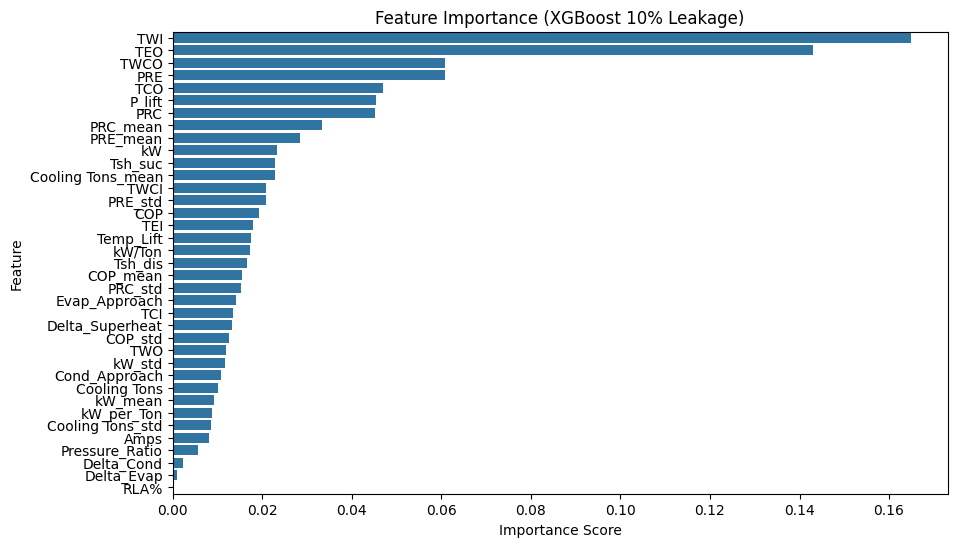

In [ ]:
#Find feature importance

importances = best_xgb10.feature_importances_
feat_names = X_scaled_df10.columns

sorted_idx = np.argsort(importances)[::-1]
plt.figure(figsize=(10,6))
sns.barplot(x=importances[sorted_idx], y=feat_names[sorted_idx])
plt.title("Feature Importance (XGBoost 10% Leakage)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")

plt.show()

## 6.1 Cost-effectiveness and Real-world practical via SHAP

In [ ]:
# Define reliability targets

target_f1 = 0.90
target_recall = 0.95

In [ ]:
# Import SHAP

!pip install shap

In [ ]:
# Ranking parameter importance using SHAP

import shap

explainer = shap.TreeExplainer(best_xgb10)
shap_values = explainer.shap_values(X_te10)

# Mean absolute SHAP importance
mean_abs_shap = np.abs(shap_values).mean(axis=0)
shap_importance = pd.Series(mean_abs_shap, index=X_scaled_df10.columns).sort_values(ascending=False)

shap_importance.head(15)

,0
TWI,3.217081
TEO,0.480785
PRE_std,0.433269
Cooling Tons_mean,0.335809
PRE,0.307851
Cooling Tons_std,0.273373
TWCI,0.271242
PRE_mean,0.257121
Delta_Superheat,0.235358
COP_std,0.185923


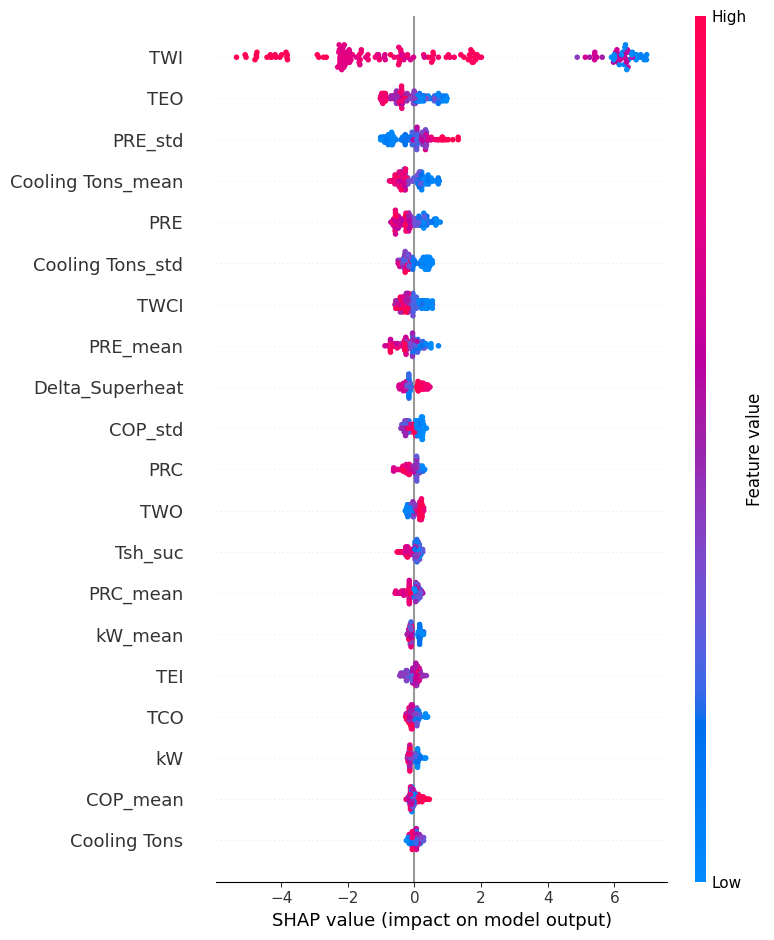

In [ ]:
#SHAP summary feature importance plot (sensors)

shap.summary_plot(shap_values, X_te10, feature_names=X_scaled_df10.columns)

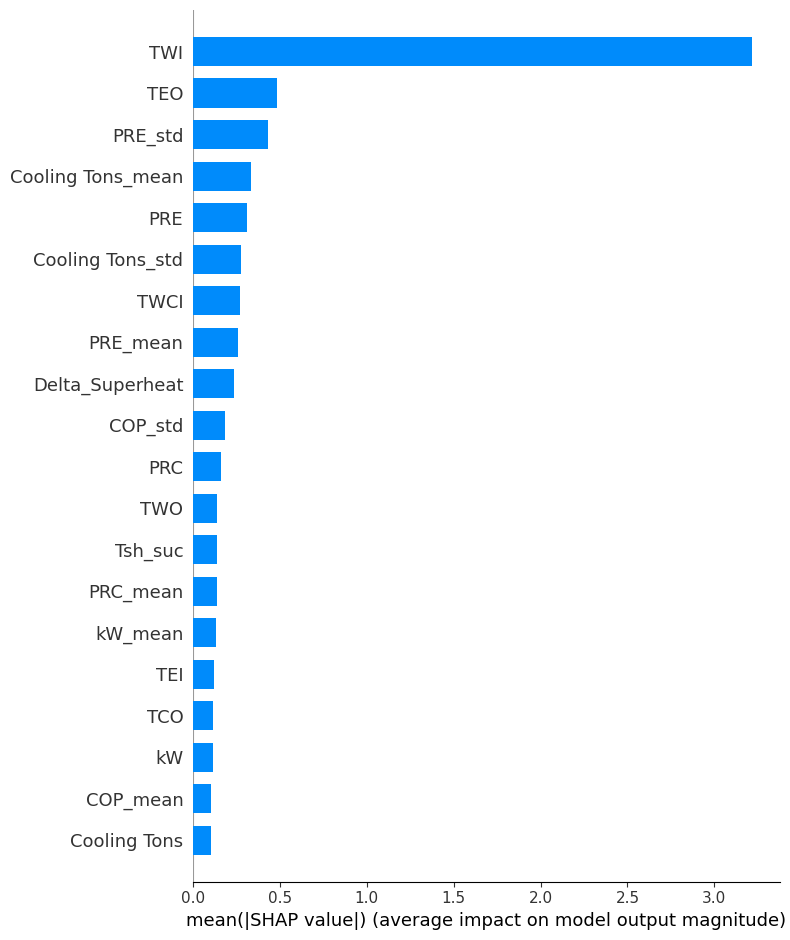

In [ ]:
# SHAP summary feature importance bar-plot (sensors).

shap.summary_plot(shap_values, X_te10, feature_names=X_scaled_df10.columns, plot_type="bar")

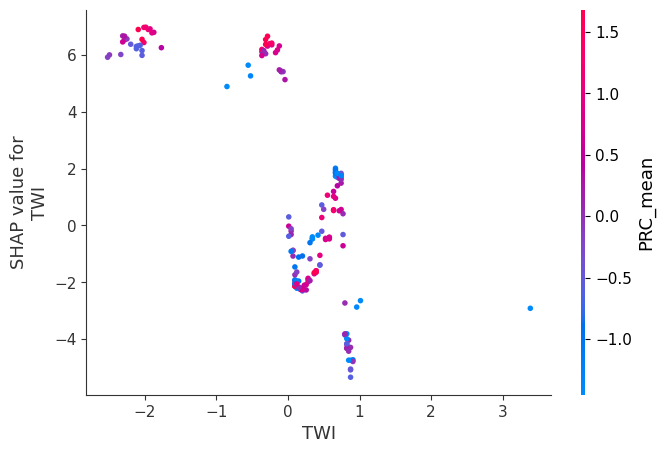

In [ ]:
# 1. SHAP dependence plot : Chilled Water Inlet Temperature

shap.dependence_plot("TWI", shap_values, X_te10, feature_names=X_scaled_df10.columns)

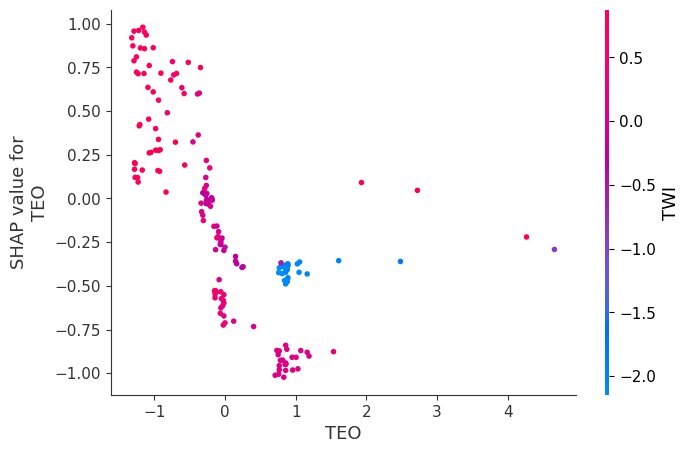

In [ ]:
# 2. SHAP dependence plot : Evaporator Outlet Temperature

shap.dependence_plot("TEO", shap_values, X_te10, feature_names=X_scaled_df10.columns)

In [ ]:
# Inputs

X = X_tr10.copy()
y = y_tr10.copy()

best_params = study_xgb10.best_params
ranked_features = shap_importance.index.tolist()  # SHAP-ranked features

TARGET_F1 = 0.90
TARGET_RECALL = 0.95

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
# 1) CV eval function for Top-K features

def cv_eval_topk(features):
    f1s, recs = [], []
    for tr_idx, va_idx in cv.split(X, y):
        X_tr_f = X.iloc[tr_idx][features]
        X_va_f = X.iloc[va_idx][features]
        y_tr_f = y.iloc[tr_idx]
        y_va_f = y.iloc[va_idx]

        m = XGBClassifier(
            **best_params,
            random_state=42,
            tree_method="hist",
            eval_metric="logloss",
            n_jobs=1  # improves reproducibility
        )
        m.fit(X_tr_f, y_tr_f)

        pred = m.predict(X_va_f)
        f1s.append(f1_score(y_va_f, pred, pos_label=1))
        recs.append(recall_score(y_va_f, pred, pos_label=1))

    return float(np.mean(f1s)), float(np.mean(recs))

In [ ]:
# 2) Search minimum K meeting targets

results = []
best_k = None
best_feature_list = None

for k in range(1, len(ranked_features) + 1):
    feats_k = ranked_features[:k]
    f1_mean, rec_mean = cv_eval_topk(feats_k)
    results.append((k, f1_mean, rec_mean))

    if (f1_mean >= TARGET_F1) and (rec_mean >= TARGET_RECALL):
        best_k = k
        best_feature_list = feats_k
        break

print("Top-10 SHAP ranked features:", ranked_features[:10])
print("\nMinimum K meeting targets:", best_k)
print("Selected features:", best_feature_list)

Top-10 SHAP ranked features: ['TWI', 'TEO', 'PRE_std', 'Cooling Tons_mean', 'PRE', 'PRE_mean', 'TWCI', 'Cooling Tons_std', 'Delta_Superheat', 'COP_std']

Minimum K meeting targets: None
Selected features: None


In [ ]:
#Fix 1: Print the best K (even if targets not met) + show where it fails

import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, recall_score
from xgboost import XGBClassifier

X = X_tr10.copy()
y = y_tr10.copy()

best_params = study_xgb10.best_params
ranked_features = shap_importance.index.tolist()

TARGET_F1 = 0.90
TARGET_RECALL = 0.95

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def cv_eval_topk(features, threshold=0.5):
    f1s, recs = [], []
    for tr_idx, va_idx in cv.split(X, y):
        X_tr_f, X_va_f = X.iloc[tr_idx][features], X.iloc[va_idx][features]
        y_tr_f, y_va_f = y.iloc[tr_idx], y.iloc[va_idx]

        m = XGBClassifier(
            **best_params,
            random_state=42,
            tree_method="hist",
            eval_metric="logloss",
            n_jobs=1
        )
        m.fit(X_tr_f, y_tr_f)

        # Use probabilities + threshold (instead of predict())
        p = m.predict_proba(X_va_f)[:, 1]
        pred = (p >= threshold).astype(int)

        f1s.append(f1_score(y_va_f, pred, pos_label=1))
        recs.append(recall_score(y_va_f, pred, pos_label=1))

    return float(np.mean(f1s)), float(np.mean(recs))

results = []
best_k = None
best_feature_list = None

for k in range(1, len(ranked_features) + 1):
    feats_k = ranked_features[:k]
    f1_mean, rec_mean = cv_eval_topk(feats_k, threshold=0.5)
    results.append((k, f1_mean, rec_mean))

    if (f1_mean >= TARGET_F1) and (rec_mean >= TARGET_RECALL):
        best_k = k
        best_feature_list = feats_k
        break

results_df = pd.DataFrame(results, columns=["TopK", "F1_mean", "Recall_mean"])
display(results_df)

# If targets not met, show the best achievable tradeoff
best_row = results_df.iloc[(results_df["F1_mean"] + results_df["Recall_mean"]).idxmax()]
print("\nTargets met?", best_k is not None)
print("Best achievable (max F1+Recall):")
print(best_row)

if best_k is None:
    print("\n❌ No Top-K met both targets at threshold=0.5.")
    print("Try threshold tuning (Fix 2) or adjust targets.")
else:
    print(f"\n✅ Minimum K meeting targets: {best_k}")
    print("Selected features:", best_feature_list)


,TopK,F1_mean,Recall_mean
0,1,0.878868,0.838137
1,2,0.894508,0.884389
2,3,0.919065,0.907453
3,4,0.928063,0.919048
4,5,0.931005,0.919006
5,6,0.937978,0.924803
6,7,0.945736,0.939213
7,8,0.941143,0.930559
8,9,0.938298,0.930518
9,10,0.944196,0.933416



Targets met? False
Best achievable (max F1+Recall):
TopK           11.000000
F1_mean         0.953126
Recall_mean     0.945010
Name: 10, dtype: float64

❌ No Top-K met both targets at threshold=0.5.
Try threshold tuning (Fix 2) or adjust targets.


In [ ]:
#Fix 2 (Recommended): Tune the decision threshold to hit Recall ≥ 0.95

def cv_eval_topk_best_threshold(features, thresholds=np.linspace(0.2, 0.8, 13)):
    best = None  # (f1, recall, thr)

    for thr in thresholds:
        f1_mean, rec_mean = cv_eval_topk(features, threshold=thr)
        if (f1_mean >= TARGET_F1) and (rec_mean >= TARGET_RECALL):
            return f1_mean, rec_mean, float(thr)  # first threshold that works

        # track best tradeoff if none meets targets
        score = f1_mean + rec_mean
        if best is None or score > (best[0] + best[1]):
            best = (f1_mean, rec_mean, float(thr))

    return best  # best achievable even if targets not met

results = []
best_k = None
best_feature_list = None
best_thr = None

for k in range(1, len(ranked_features) + 1):
    feats_k = ranked_features[:k]
    f1_mean, rec_mean, thr = cv_eval_topk_best_threshold(feats_k)
    results.append((k, f1_mean, rec_mean, thr))

    if (f1_mean >= TARGET_F1) and (rec_mean >= TARGET_RECALL):
        best_k = k
        best_feature_list = feats_k
        best_thr = thr
        break

results_df = pd.DataFrame(results, columns=["TopK", "F1_mean", "Recall_mean", "Best_thr"])
display(results_df)

print("\nMinimum K meeting targets:", best_k)
print("Selected features:", best_feature_list)
print("Chosen threshold:", best_thr)


,TopK,F1_mean,Recall_mean,Best_thr
0,1,0.877709,0.849648,0.4
1,2,0.872099,0.927619,0.2
2,3,0.912226,0.933499,0.3
3,4,0.912528,0.962402,0.2



Minimum K meeting targets: 4
Selected features: ['TWI', 'TEO', 'PRE_std', 'Cooling Tons_mean']
Chosen threshold: 0.2


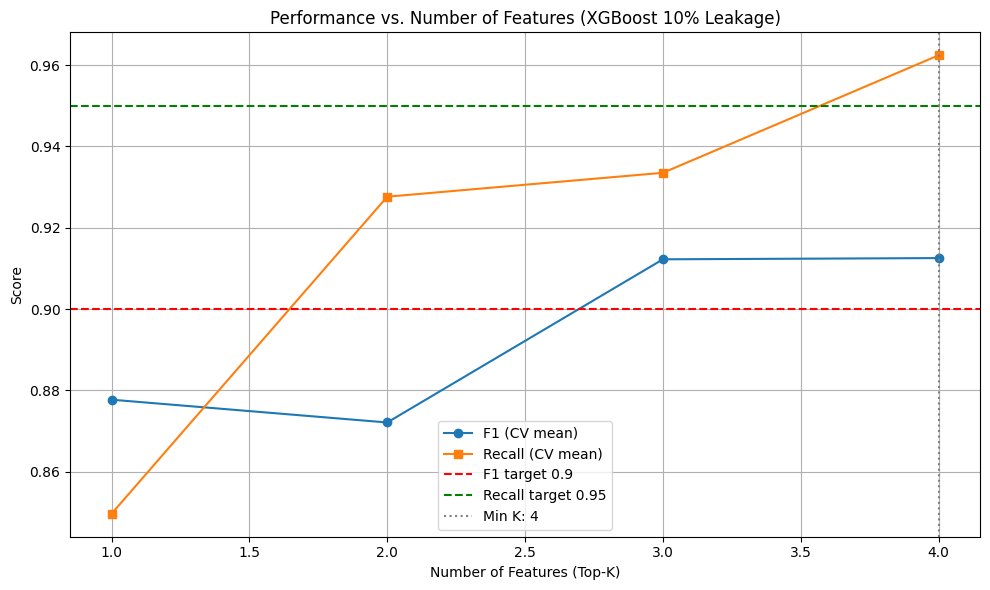

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(results_df["TopK"], results_df["F1_mean"], marker="o", label="F1 (CV mean)")
plt.plot(results_df["TopK"], results_df["Recall_mean"], marker="s", label="Recall (CV mean)")
plt.axhline(TARGET_F1, linestyle="--", color='red', label=f"F1 target {TARGET_F1}")
plt.axhline(TARGET_RECALL, linestyle="--", color='green', label=f"Recall target {TARGET_RECALL}")

if best_k is not None:
    plt.axvline(best_k, linestyle=":", color='gray', label=f"Min K: {best_k}")

plt.xlabel("Number of Features (Top-K)")
plt.ylabel("Score")
plt.title("Performance vs. Number of Features (XGBoost 10% Leakage)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# test

In [ ]:
# Incremental feature selection

from sklearn.metrics import precision_recall_fscore_support, f1_score, recall_score, average_precision_score
import pandas as pd

results = []

# Convert X_train and X_test back to DataFrames with original column names
X_train_df = pd.DataFrame(X_train, columns=X.columns)
X_test_df = pd.DataFrame(X_test, columns=X.columns)


for k in range(2, len(shap_importance)+1):
    top_features = shap_importance.index[:k]
    # Select top features from the DataFrames
    X_train_k = X_train_df[top_features]
    X_test_k = X_test_df[top_features]

    model_k = XGBClassifier(n_estimators=300, learning_rate=0.05, max_depth=4, random_state=42)
    model_k.fit(X_train_k, y_train)
    y_pred_k = model_k.predict(X_test_k)

    f1 = f1_score(y_test, y_pred_k)
    recall = recall_score(y_test, y_pred_k)
    ap = average_precision_score(y_test, model_k.predict_proba(X_test_k)[:,1])

    results.append({"k": k, "F1": f1, "Recall": recall, "AP": ap})

results_df = pd.DataFrame(results)
results_df.head(20)

,k,F1,Recall,AP
0,2,0.853659,0.826772,0.954538
1,3,0.900826,0.858268,0.967663
2,4,0.901639,0.866142,0.980863
3,5,0.909091,0.905512,0.983134
4,6,0.912000,0.897638,0.983551
5,7,0.940239,0.929134,0.991539
6,8,0.935484,0.913386,0.990408
7,9,0.944000,0.929134,0.992265
8,10,0.944000,0.929134,0.993103
9,11,0.948617,0.944882,0.991460


In [ ]:
# Incremental feature selection

from sklearn.metrics import precision_recall_fscore_support, f1_score, recall_score, average_precision_score
import pandas as pd

results = []

# Convert X_train and X_test back to DataFrames with original column names
X_train_df = pd.DataFrame(X_tr10, columns=X_scaled_df10.columns)
X_test_df = pd.DataFrame(X_te10, columns=X_scaled_df10.columns)


for k in range(2, len(shap_importance)+1):
    top_features = shap_importance.index[:k]
    # Select top features from the DataFrames
    X_train_k = X_train_df[top_features]
    X_test_k = X_test_df[top_features]

    model_k = XGBClassifier(n_estimators=300, learning_rate=0.05, max_depth=4, random_state=42)
    model_k.fit(X_train_k, y_tr10)
    y_pred_k = model_k.predict(X_test_k)

    f1 = f1_score(y_te10, y_pred_k)
    recall = recall_score(y_te10, y_pred_k)
    ap = average_precision_score(y_te10, model_k.predict_proba(X_test_k)[:,1])

    results.append({"k": k, "F1": f1, "Recall": recall, "AP": ap})

results_df = pd.DataFrame(results)
results_df.head(20)

,k,F1,Recall,AP
0,2,0.906977,0.896552,0.970085
1,3,0.894118,0.873563,0.967974
2,4,0.923077,0.896552,0.981022
3,5,0.941176,0.919540,0.986461
4,6,0.917647,0.896552,0.984930
5,7,0.941860,0.931034,0.988461
6,8,0.941860,0.931034,0.991005
7,9,0.941860,0.931034,0.990772
8,10,0.941176,0.919540,0.991841
9,11,0.947977,0.942529,0.990943


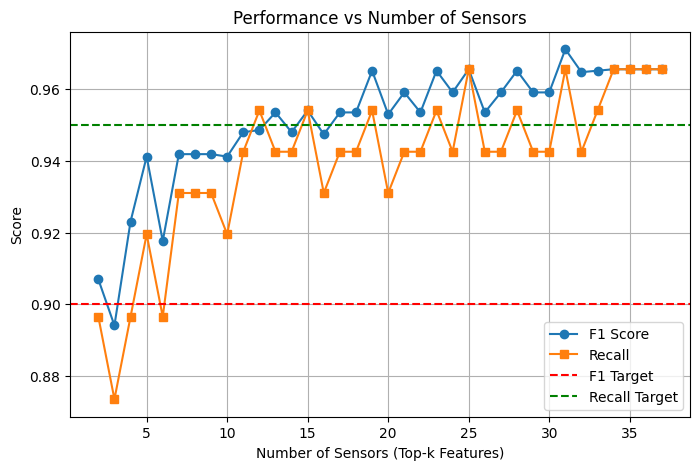

In [ ]:
# Plot "Performance vs Sensor count."

plt.figure(figsize=(8,5))
plt.plot(results_df["k"], results_df["F1"], label="F1 Score", marker='o')
plt.plot(results_df["k"], results_df["Recall"], label="Recall", marker='s')
plt.axhline(target_f1, color='red', linestyle='--', label='F1 Target')
plt.axhline(target_recall, color='green', linestyle='--', label='Recall Target')
plt.xlabel("Number of Sensors (Top-k Features)")
plt.ylabel("Score")
plt.title("Performance vs Number of Sensors")
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Indentify minimum sensor set.

# Find smallest k meeting targets
threshold_met = results_df[(results_df["F1"] >= target_f1) & (results_df["Recall"] >= target_recall)]
if not threshold_met.empty:
    best_k = threshold_met.iloc[0]
    print(f"Minimum sensor count: {best_k['k']}")
else:
    print("No subset reached the target. Consider lowering thresholds or engineering more features.")


Minimum sensor count: 15.0


In [ ]:
# List the selected sensors

best_features = shap_importance.index[:int(best_k['k'])]
print("Final Sensor List (Minimal Set):")
for f in best_features:
    print("-", f)


Final Sensor List (Minimal Set):
- TWI
- TEO
- PRE_mean
- Cooling Tons_mean
- PRE_std
- PRE
- PRC
- Cooling Tons_std
- Cond_Approach
- TEI
- PRC_std
- COP_std
- kW_mean
- TCO
- PRC_mean


In [ ]:
# Indentify minimum sensor set.

# Find smallest k meeting targets
threshold_met = results_df[(results_df["F1"] >= target_f1) & (results_df["Recall"] >= target_recall)]
if not threshold_met.empty:
    best_k = threshold_met.iloc[0]
    print(f"Minimum sensor count: {best_k['k']}")
else:
    print("No subset reached the target. Consider lowering thresholds or engineering more features.")

Minimum sensor count: 12.0


In [ ]:
# List the selected sensors

best_features = shap_importance.index[:int(best_k['k'])]
print("Final Sensor List (Minimal Set):")
for f in best_features:
    print("-", f)

Final Sensor List (Minimal Set):
- TWI
- TEO
- PRE_std
- Cooling Tons_mean
- PRE
- Cooling Tons_std
- TWCI
- PRE_mean
- Delta_Superheat
- COP_std
- PRC
- TWO
